# CUDA LAB - Convolutional Neural Networks

# Required Libraries

In [56]:
import scipy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import time

# Required Dataset

In [2]:
train_dataset = dsets.SVHN(root='data', split = "train", transform=transforms.ToTensor(), download=True)
test_dataset = dsets.SVHN(root='data', split = "test", transform=transforms.ToTensor(), download=True)
#extra_train_dataset = dsets.SVHN(root='data', split = "extra", transform=transforms.ToTensor(), download=True)

print(train_dataset)
print(test_dataset)
#print(extra_train_dataset)

Using downloaded and verified file: data\train_32x32.mat
Using downloaded and verified file: data\test_32x32.mat
Dataset SVHN
    Number of datapoints: 73257
    Root location: data
    Split: train
    StandardTransform
Transform: ToTensor()
Dataset SVHN
    Number of datapoints: 26032
    Root location: data
    Split: test
    StandardTransform
Transform: ToTensor()


# Observations made from the experiments below are written here

### 1) Using a simple CNN over the last sheet's one layer logistic regression model wasa uge improvment. Infact, the simple neural net model failed terribly for the SVHN dataset.
### 2) A simple CNN gave a high accuracy of around 87.5 percent. The in and out channels were changed, the number of layers were changed but the original 2 conv layer model gave better results which is used below.
### 3) In a simple CNN Without Regularzation the accuracy was same and usually more but the model fitted early and started oscillating and overfitting started on.
### 4) As will be evident in the plots below, L1 and L2 regularization may not give better acuuracy but the plots of accuracy and loss were comparatively smoother than simple CNN.
### 5) Elastic regularzation gave the best accuracy, sometimes over 88% and it had positives from both L1 and L2 regularization.
### 6) Dropout took more time for running the model than a simple CNN witout dropout and accuracy of CNN without dropout was more, so more experimentation was needed to get better accuracy through dropout but this particular dropout was tested on the established model.
### 7) Average pooling gave slightly better results.
### 8) A combination of average and max pooling was tried and it gave accuracy closer to original CNN and more than L1 and L2 regularization.
### 9) Batch Normalzation was tried at the end which outperformed all the models and gave accuracies more than 89.5 percent sometimes.
### 10) Some other experiments with changing activation functions, number of convolutional layers, batch size, learning rate, and changing parameters of elastic regularzation were tried but no luck there in improving accuracy.

In [156]:
print("Batch size = 128, Learning Rate = 0.001 and number of parameters = ",super_num[0])
print("\n")
for i in range(len(super_names)):
    print(super_names[i],"max accuracy is ",max(df_acc[i]))

Batch size = 128, Learning Rate = 0.001 and number of parameters =  122626


Simple CNN with ReLU max accuracy is  87.62292562999386
CNN with ReLU using L1 Regularization max accuracy is  86.45129071911494
CNN with ReLU using L2 Regularization max accuracy is  87.50384142593731
CNN with ReLU using Elastic Regularization max accuracy is  87.9917025199754
CNN with ReLU using Dropout max accuracy is  84.1618008604794
CNN with ReLU using Average Pooling max accuracy is  87.91103257529194
CNN with ReLU using combination of Maximum and Average Pooling max accuracy is  87.52688998156115


# Data Preprocessing

In [3]:
train_mat = scipy.io.loadmat("data/train_32x32.mat")
test_mat = scipy.io.loadmat("data/test_32x32.mat")

train_imgs = train_mat['X']
print(train_imgs.shape)

train_imgs = np.transpose(train_imgs, (3,2,0,1))
print(train_imgs.shape)

train_labels = train_mat['y']
print(train_labels.shape)

(32, 32, 3, 73257)
(73257, 3, 32, 32)
(73257, 1)


In [4]:
X_train = torch.Tensor(train_imgs) # transform to torch tensor
y_train = torch.Tensor(train_labels)
y_train = y_train.squeeze(1)
y_train=y_train-1
y_train = y_train.to(dtype=torch.int64)
#https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
train_data = torch.utils.data.TensorDataset(X_train,y_train)

In [5]:
test_imgs = test_mat['X']
print(test_imgs.shape)
test_imgs = np.transpose(test_imgs, (3,2,0,1))
print(test_imgs.shape)
test_labels = test_mat['y']
print(test_labels.shape)
X_test = torch.Tensor(test_imgs) # transform to torch tensor
y_test = torch.Tensor(test_labels)
y_test = y_test.squeeze(1)
y_test = y_test-1
y_test = y_test.to(dtype=torch.int64)
#https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
test_data = torch.utils.data.TensorDataset(X_test,y_test)

(32, 32, 3, 26032)
(26032, 3, 32, 32)
(26032, 1)


In [6]:
# Fitting data loaders for iterating
B_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
B_SIZE = 128
test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                           batch_size=B_SIZE, 
                                           shuffle=False) 

In [7]:
dataiter = iter(train_loader)
data = dataiter.next()
imgs,label = data
print(imgs,label)

tensor([[[[105., 103.,  98.,  ...,  98., 101., 102.],
          [103.,  99.,  97.,  ...,  99., 101., 101.],
          [103.,  99.,  97.,  ..., 101., 101., 102.],
          ...,
          [102.,  86.,  59.,  ..., 101., 104., 109.],
          [105.,  91.,  66.,  ...,  98., 101., 107.],
          [111., 102.,  80.,  ...,  97., 101., 103.]],

         [[111., 109., 107.,  ..., 100., 103., 106.],
          [109., 108., 106.,  ..., 100., 102., 105.],
          [112., 108., 106.,  ..., 104., 105., 106.],
          ...,
          [112.,  96.,  69.,  ..., 107., 111., 115.],
          [116., 101.,  76.,  ..., 104., 107., 113.],
          [121., 112.,  90.,  ..., 103., 107., 112.]],

         [[109., 107., 104.,  ...,  99., 102., 105.],
          [107., 105., 105.,  ..., 102., 104., 106.],
          [109., 107., 105.,  ..., 105., 107., 109.],
          ...,
          [111.,  96.,  72.,  ..., 106., 109., 111.],
          [113., 102.,  78.,  ..., 102., 105., 111.],
          [120., 112.,  92.,  ...

tensor(4)


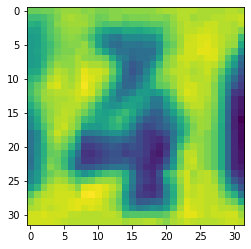

In [8]:
idx = 8
print(label[idx]+1)
plt.imshow(imgs[idx][1])

# For comparison using model from last sheet

In [14]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.LeakyReLU(negative_slope=0.001, inplace=False),
                nn.Linear(hidden_dim, output_dim)
            )
    def forward(self, x):
        x_flat = x.view(-1, self.input_dim)
        out = self.model(x_flat)
        return out

In [18]:
device = "cuda"
model_num = 30      #change here

lr = 0.001
num_epochs = 75
batch_size = 128

in_dim = 3072
hidden_dim = 1536
out_dim = 10


loss_hist30 = []
acc_hist30 = []

grad_norm30 = []
total_norm=0

print('Learning Rate = ',lr, 'Batch Size = ',batch_size, 'Hidden Dim = ', hidden_dim)

model_logistic = LogisticRegression(in_dim, hidden_dim, out_dim)
model_logistic = model_logistic.to(device)
print(model_logistic)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

Learning Rate =  0.001 Batch Size =  128 Hidden Dim =  1536
LogisticRegression(
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=1536, bias=True)
    (1): LeakyReLU(negative_slope=0.001)
    (2): Linear(in_features=1536, out_features=10, bias=True)
  )
)


In [19]:
for epoch in range(num_epochs):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (imgs, labels) in progress_bar:
        
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # forward pass
        pred_labels = model_logistic(imgs)
        
        # computing error
        loss = criterion(pred_labels, labels)
        loss_list.append(loss.item())
    
        
        # removing accumulated gradients
        optimizer.zero_grad()
        loss.backward()
        
        
# https://discuss.pytorch.org/t/check-the-norm-of-gradients/27961        
        
        total_norm=0
        for p in model.parameters():
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)
        
# https://discuss.pytorch.org/t/how-to-check-norm-of-gradients/13795/3

        #for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        #    print(p.grad.data.norm(2).item())
        
        optimizer.step()
    
        if(i % 1 == 0 or i == N_ITERS-1):
            progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
            
    loss_hist30.append(np.mean(loss_list))    #change here
    
    
    
    n_correct = 0

    with torch.no_grad():
        progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))
        for i, (imgs, labels) in progress_bar: 
            #everything needs to be on the same device
            imgs = imgs.to(device)
            labels = labels.to(device)

            # forward pass
            pred_labels = model(imgs)

            preds = torch.argmax(pred_labels, dim=-1)
            cur_correct = len(torch.where(preds == labels)[0])
            n_correct = n_correct + cur_correct

    accuracy = n_correct / len(test_dataset) * 100
    #print(f"Test accuracy: {round(accuracy,2)}%")
    
    acc_hist30.append(accuracy)            #change here
    
    grad_norm30.append(total_norm)   

100%|███████████████████████████████████████| 204/204 [00:00<00:00, 417.43it/s]


100%|████████████████████████████████████████| 204/204 [00:04<00:00, 42.66it/s]


Test accuracy: 6.96%
Learning Rate =  0.1 Batch Size =  128 Hidden Dim =  1536


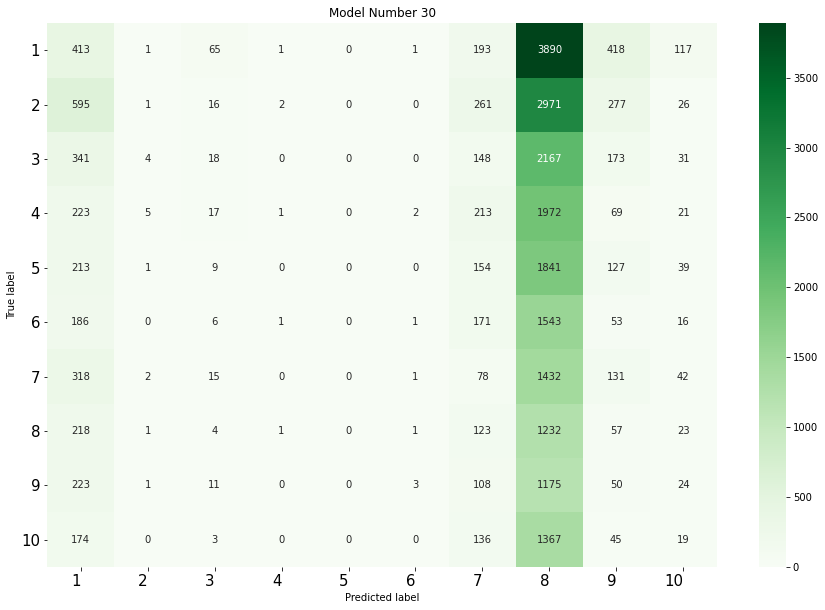

In [43]:
n_correct = 0

nb_classes = 10
confusion_matrix = np.zeros((nb_classes, nb_classes))

with torch.no_grad():
    progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))
    for i, (imgs, labels) in progress_bar: 
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # forward pass
        pred_labels = model_logistic(imgs)
        
        preds = torch.argmax(pred_labels, dim=-1)
        cur_correct = len(torch.where(preds == labels)[0])
        n_correct = n_correct + cur_correct
        
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = range(10)
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Greens")
yyl = list(range(1,11))

heatmap.yaxis.set_ticklabels(yyl, rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(yyl, rotation=0, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Model Number 30')     #change here
#https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial
        
        
accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")
print('Learning Rate = ',lr, 'Batch Size = ',batch_size, 'Hidden Dim = ', hidden_dim)

# Storing Model Name, Number of paarmeters, Loss and Accuracy of each model

In [62]:
super_names = []
super_num = []
super_loss = []
super_acc = []
super_lr_rate = []

EPOCHS = 25
LR = 0.001

# CNN Model

In [150]:
device = "cuda"
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #https://www.youtube.com/watch?v=pDdP0TFzsoQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=14
        self.conv_layer1 = nn.Conv2d(3, 6, 5)  #
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.conv_layer2 = nn.Conv2d(6, 16, 5)  #
        self.maxpool2 = nn.MaxPool2d(2,2)
        
        #n_size = self._get_conv_output(input_shape)
        #self.fc1 = nn.Linear(n_size, 512)
        
        self.fc1 = nn.Linear(16*5*5, 256)   # this 16*5*5 must be changed 
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        
    def forward(self,x):
        x = self.maxpool1(F.relu(self.conv_layer1(x)))
        x = self.maxpool2(F.relu(self.conv_layer2(x)))
        x = x.view(-1,16*5*5)  # this 16*5*5 must be changed 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [151]:
@torch.no_grad()
def eval_model(model):
    """ Computing model accuracy """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    return accuracy, loss

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [152]:
model = CNN().to(device)   

params = count_model_params(model)
print(f"Model has {params} learnable parameters")

#EPOCHS = 25
LR = 0.001
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

Model has 122626 learnable parameters


In [153]:
loss_hist = []
acc_hist = []

start = time.time()


for epoch in range( EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
    loss_hist.append(np.mean(loss_list))
    accuracy, _ = eval_model(model)
    acc_hist.append(accuracy)
    #print(f"Classification accuracy: {round(accuracy, 2)}%")
    
end = time.time()  

Epoch 25 Iter 573: loss 0.12868. : 100%|████| 573/573 [00:03<00:00, 178.54it/s]


In [67]:
time_simple_cnn= end-start
print("Time in seconds =", end - start)  

Time in seconds = 94.36746406555176


In [68]:
accuracy, _ = eval_model(model)  
print(f"Classification accuracy: {round(accuracy, 2)}%")

Classification accuracy: 86.5%


In [69]:
super_names.append("Simple CNN with ReLU")
super_num.append(params)
super_loss.append(loss_hist)
super_acc.append(acc_hist)
super_lr_rate.append(LR)

100%|████████████████████████████████████████| 204/204 [00:04<00:00, 42.75it/s]


Test accuracy: 86.5%


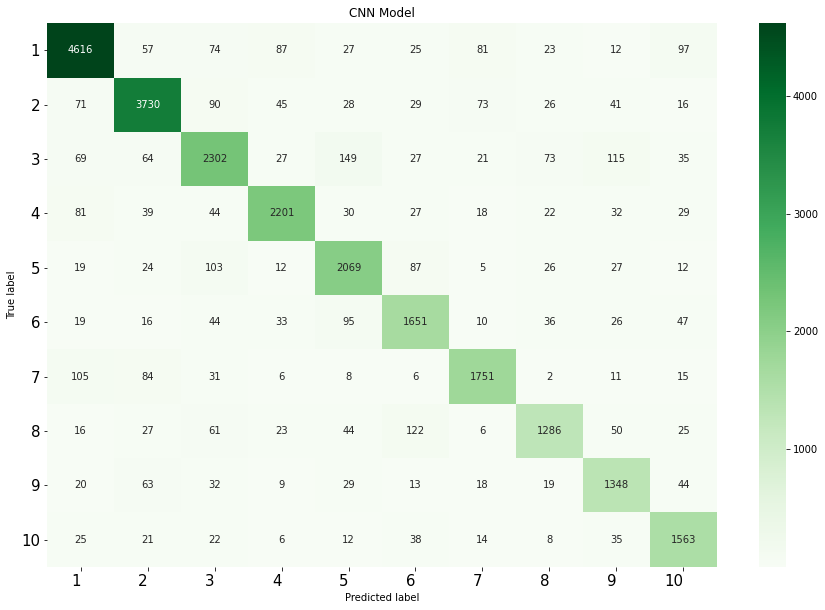

In [70]:
n_correct = 0

nb_classes = 10
confusion_matrix = np.zeros((nb_classes, nb_classes))

with torch.no_grad():
    progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))
    for i, (imgs, labels) in progress_bar: 
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # forward pass
        pred_labels = model(imgs)
        
        preds = torch.argmax(pred_labels, dim=-1)
        cur_correct = len(torch.where(preds == labels)[0])
        n_correct = n_correct + cur_correct
        
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = range(10)
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Greens")

yyl = list(range(1,11))

heatmap.yaxis.set_ticklabels(yyl, rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(yyl, rotation=0, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('CNN Model')     #change here
#https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial
        
        
accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

### Comparsion between CNN and A simple one layer logistic regression

#### A huge difference of 80 percent was reported and the logistic regression was mostly classifying every image as 8 as seen in the confusion matrix. However,the CNN with 2 convolutional layers with max pooling gave an accuracy of 86 percent and did a really good job in indentifying the number "1".

# Visualising Convolutional layers and activations

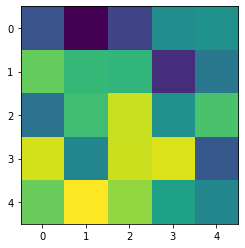

In [154]:
weight = model.conv_layer1.weight.data
weight = weight.to("cpu")
weight = weight.numpy()
plt.imshow(weight[0][2]) 

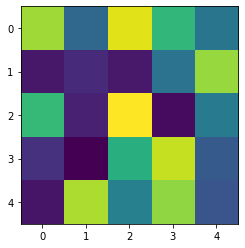

In [155]:
weight = model.conv_layer2.weight.data
weight = weight.to("cpu")
weight = weight.numpy()
plt.imshow(weight[0][2]) 

# Next we move on to trying different regularizations namely, L1, L2 and Elastic Regularization

# Regularization L1

In [71]:
device = "cuda"
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 6, 5)  #
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.conv_layer2 = nn.Conv2d(6, 16, 5)  #
        self.maxpool2 = nn.MaxPool2d(2,2)
        
        #n_size = self._get_conv_output(input_shape)
        #self.fc1 = nn.Linear(n_size, 512)
        
        self.fc1 = nn.Linear(16*5*5, 256)   # this 16*5*5 must be changed 
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        
    def forward(self,x):
        x = self.maxpool1(F.relu(self.conv_layer1(x)))
        x = self.maxpool2(F.relu(self.conv_layer2(x)))
        x = x.view(-1,16*5*5)  # this 16*5*5 must be changed 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [72]:
model = CNN().to(device)   

params = count_model_params(model)
print(f"Model has {params} learnable parameters")

#EPOCHS = 25
LR = 0.001
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

Model has 122626 learnable parameters


In [73]:
loss_hist = []
acc_hist = []

for epoch in range( EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
        
        #https://www.programmersought.com/article/52011513926/
        
        lambda1 = 0.001
        l1_norm = torch.tensor(0.).to(device)
        for param in model.parameters():
            l1_norm += torch.sum(abs(param))
        loss += lambda1 * l1_norm
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
    loss_hist.append(np.mean(loss_list))
    accuracy, _ = eval_model(model) 
    acc_hist.append(accuracy)
    #print(f"Classification accuracy: {round(accuracy, 2)}%")

Epoch 25 Iter 573: loss 0.15898. : 100%|████| 573/573 [00:03<00:00, 169.37it/s]


In [74]:
accuracy, _ = eval_model(model)  
print(f"Classification accuracy: {round(accuracy, 2)}%")

Classification accuracy: 85.21%


In [75]:
super_names.append("CNN with ReLU using L1 Regularization")
super_num.append(params)
super_loss.append(loss_hist)
super_acc.append(acc_hist)
super_lr_rate.append(LR)

# Regularization L2

In [76]:
device = "cuda"
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 6, 5)  #
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.conv_layer2 = nn.Conv2d(6, 16, 5)  #
        self.maxpool2 = nn.MaxPool2d(2,2)
        
        #n_size = self._get_conv_output(input_shape)
        #self.fc1 = nn.Linear(n_size, 512)
        
        self.fc1 = nn.Linear(16*5*5, 256)   # this 16*5*5 must be changed 
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        
    def forward(self,x):
        x = self.maxpool1(F.relu(self.conv_layer1(x)))
        x = self.maxpool2(F.relu(self.conv_layer2(x)))
        x = x.view(-1,16*5*5)  # this 16*5*5 must be changed 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [77]:
model = CNN().to(device)   

params = count_model_params(model)
print(f"Model has {params} learnable parameters")

#EPOCHS = 25
LR = 0.001
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR, weight_decay=0.0001)

Model has 122626 learnable parameters


In [78]:
loss_hist = []
acc_hist = []

for epoch in range( EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
    loss_hist.append(np.mean(loss_list))
    accuracy, _ = eval_model(model)  
    acc_hist.append(accuracy)
    #print(f"Classification accuracy: {round(accuracy, 2)}%")

Epoch 25 Iter 573: loss 0.10366. : 100%|████| 573/573 [00:03<00:00, 184.79it/s]


In [79]:
accuracy, _ = eval_model(model)  
print(f"Classification accuracy: {round(accuracy, 2)}%")

Classification accuracy: 87.5%


In [80]:
super_names.append("CNN with ReLU using L2 Regularization")
super_num.append(params)
super_loss.append(loss_hist)
super_acc.append(acc_hist)
super_lr_rate.append(LR)

# Elastic Regularization

In [81]:
device = "cuda"
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 6, 5)  #
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.conv_layer2 = nn.Conv2d(6, 16, 5)  #
        self.maxpool2 = nn.MaxPool2d(2,2)
        
        #n_size = self._get_conv_output(input_shape)
        #self.fc1 = nn.Linear(n_size, 512)
        
        self.fc1 = nn.Linear(16*5*5, 256)   # this 16*5*5 must be changed 
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        
    def forward(self,x):
        x = self.maxpool1(F.relu(self.conv_layer1(x)))
        x = self.maxpool2(F.relu(self.conv_layer2(x)))
        x = x.view(-1,16*5*5)  # this 16*5*5 must be changed 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [82]:
model = CNN().to(device)   

params = count_model_params(model)
print(f"Model has {params} learnable parameters")

#EPOCHS = 25
LR = 0.001
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

Model has 122626 learnable parameters


In [83]:
loss_hist = []
acc_hist = []

for epoch in range( EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        #https://www.machinecurve.com/index.php/2020/01/21/what-are-l1-l2-and-elastic-net-regularization-in-neural-networks/#elastic-net-regularization
        
        alpha = 0.8
        lambdaa = 0.000001
        # https://www.programmersought.com/article/52011513926/
        # https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net
        
        l1_norm = torch.tensor(0.).to(device)
        for param in model.parameters():
            l1_norm += torch.sum(abs(param))
            
        l2_norm = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_norm += torch.sum(abs(param))**2 
            
        loss = loss + lambdaa*(((1-alpha)*l1_norm) + (alpha*l2_norm))
        
        
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
    loss_hist.append(np.mean(loss_list))
    accuracy, _ = eval_model(model)  
    acc_hist.append(accuracy)
    #print(f"Classification accuracy: {round(accuracy, 2)}%")

Epoch 25 Iter 573: loss 0.87634. : 100%|████| 573/573 [00:04<00:00, 119.75it/s]


In [84]:
accuracy, _ = eval_model(model)  
print(f"Classification accuracy: {round(accuracy, 2)}%")

Classification accuracy: 87.81%


In [85]:
super_names.append("CNN with ReLU using Elastic Regularization")
super_num.append(params)
super_loss.append(loss_hist)
super_acc.append(acc_hist)
super_lr_rate.append(LR)

# Dropout

In [86]:
device = "cuda"
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 6, 5)  #
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.conv_layer2 = nn.Conv2d(6, 16, 5)  #
        self.maxpool2 = nn.MaxPool2d(2,2)
        
        self.dropout = nn.Dropout(0.2)
        
        #n_size = self._get_conv_output(input_shape)
        #self.fc1 = nn.Linear(n_size, 512)
        
        self.fc1 = nn.Linear(16*5*5, 256)   # this 16*5*5 must be changed 
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        
    def forward(self,x):
        x = self.maxpool1(F.relu(self.conv_layer1(x)))
        #x = self.dropout(x)
        x = self.maxpool2(F.relu(self.conv_layer2(x)))
        x = self.dropout(x)
        x = x.view(-1,16*5*5)  # this 16*5*5 must be changed 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [87]:
model = CNN().to(device)   

params = count_model_params(model)
print(f"Model has {params} learnable parameters")

#EPOCHS = 25
LR = 0.001
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

Model has 122626 learnable parameters


In [88]:
loss_hist = []
acc_hist = []

start = time.time()
for epoch in range( EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
    loss_hist.append(np.mean(loss_list))
    accuracy, _ = eval_model(model)  
    acc_hist.append(accuracy)
    #print(f"Classification accuracy: {round(accuracy, 2)}%")
    
end = time.time()   

Epoch 25 Iter 573: loss 0.32129. : 100%|████| 573/573 [00:03<00:00, 165.47it/s]


In [89]:
time_dropout_cnn = end - start
print("Time in seconds =", end - start) 

Time in seconds = 100.3756206035614


In [90]:
accuracy, _ = eval_model(model)  
print(f"Classification accuracy: {round(accuracy, 2)}%")

Classification accuracy: 83.52%


### Time elapsed was more with dropout 100.37562 seconds as compared to cnn without dropout 94.36746 seconds

In [91]:
super_names.append("CNN with ReLU using Dropout")
super_num.append(params)
super_loss.append(loss_hist)
super_acc.append(acc_hist)
super_lr_rate.append(LR)

# Average Pooling

In [92]:
device = "cuda"
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 6, 5)  #
        self.avgpool1 = nn.AvgPool2d(2,2)
        self.conv_layer2 = nn.Conv2d(6, 16, 5)  #
        self.avgpool2 = nn.AvgPool2d(2,2)
        
        #n_size = self._get_conv_output(input_shape)
        #self.fc1 = nn.Linear(n_size, 512)
        
        self.fc1 = nn.Linear(16*5*5, 256)   # this 16*5*5 must be changed 
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        
    def forward(self,x):
        x = self.avgpool1(F.relu(self.conv_layer1(x)))
        x = self.avgpool2(F.relu(self.conv_layer2(x)))
        x = x.view(-1,16*5*5)  # this 16*5*5 must be changed 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [93]:
model = CNN().to(device)   

params = count_model_params(model)
print(f"Model has {params} learnable parameters")

#EPOCHS = 25
LR = 0.001
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

Model has 122626 learnable parameters


In [94]:
loss_hist = []
acc_hist = []
for epoch in range( EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
    loss_hist.append(np.mean(loss_list))
    accuracy, _ = eval_model(model)  
    acc_hist.append(accuracy)
    #print(f"Classification accuracy: {round(accuracy, 2)}%")

Epoch 25 Iter 573: loss 0.11171. : 100%|████| 573/573 [00:03<00:00, 178.06it/s]


In [95]:
accuracy, _ = eval_model(model)  
print(f"Classification accuracy: {round(accuracy, 2)}%")

Classification accuracy: 86.49%


In [96]:
super_names.append("CNN with ReLU using Average Pooling")
super_num.append(params)
super_loss.append(loss_hist)
super_acc.append(acc_hist)
super_lr_rate.append(LR)

# Combination of Maximum and Average Pooling

In [97]:
device = "cuda"
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 6, 5)  #
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.conv_layer2 = nn.Conv2d(6, 16, 5)  #
        self.avgpool2 = nn.AvgPool2d(2,2)
        
        #n_size = self._get_conv_output(input_shape)
        #self.fc1 = nn.Linear(n_size, 512)
        
        self.fc1 = nn.Linear(16*5*5, 256)   # this 16*5*5 must be changed 
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        
    def forward(self,x):
        x = self.maxpool1(F.relu(self.conv_layer1(x)))
        x = self.avgpool2(F.relu(self.conv_layer2(x)))
        x = x.view(-1,16*5*5)  # this 16*5*5 must be changed 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [98]:
model = CNN().to(device)   

params = count_model_params(model)
print(f"Model has {params} learnable parameters")

#EPOCHS = 25
LR = 0.001
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

Model has 122626 learnable parameters


In [99]:
loss_hist = []
acc_hist = []
for epoch in range( EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
    loss_hist.append(np.mean(loss_list))
    accuracy, _ = eval_model(model)  
    acc_hist.append(accuracy)
    #print(f"Classification accuracy: {round(accuracy, 2)}%")

Epoch 25 Iter 573: loss 0.35833. : 100%|████| 573/573 [00:03<00:00, 175.69it/s]


In [100]:
accuracy, _ = eval_model(model)  
print(f"Classification accuracy: {round(accuracy, 2)}%")

Classification accuracy: 86.04%


In [101]:
super_names.append("CNN with ReLU using combination of Maximum and Average Pooling")
super_num.append(params)
super_loss.append(loss_hist)
super_acc.append(acc_hist)
super_lr_rate.append(LR)

In [102]:
len(super_names)

7

In [107]:
super_names

['Simple CNN with ReLU',
 'CNN with ReLU using L1 Regularization',
 'CNN with ReLU using L2 Regularization',
 'CNN with ReLU using Elastic Regularization',
 'CNN with ReLU using Dropout',
 'CNN with ReLU using Average Pooling',
 'CNN with ReLU using combination of Maximum and Average Pooling']

In [119]:
num = range(0,25)
df_loss = pd.DataFrame(num,columns = ['Epochs'])
for i in range(len(super_names)):
    df_loss[i] = pd.DataFrame(super_loss[i], columns = ['loss'])
df_loss.to_csv('cnn_origin_losses.csv', sep=',',index = False)
print("Losses table of above 7 models")
df_loss

Losses table of above 7 models


,Epochs,0,1,2,3,4,5,6
0,0,0.825763,1.054683,0.848644,1.499455,1.035183,0.931836,0.944988
1,1,0.466681,0.578294,0.492060,0.705504,0.682679,0.513890,0.529308
2,2,0.392568,0.485251,0.412902,0.624795,0.600483,0.434697,0.442297
3,3,0.345935,0.422932,0.360383,0.577130,0.553769,0.378499,0.387158
4,4,0.312317,0.379026,0.325776,0.550607,0.522169,0.340446,0.347970
5,5,0.279906,0.344319,0.293391,0.530910,0.499574,0.306326,0.313327
6,6,0.257727,0.311822,0.265205,0.514852,0.480847,0.275226,0.290292
7,7,0.237075,0.284092,0.242962,0.498089,0.463752,0.252516,0.268949
8,8,0.210110,0.263274,0.231038,0.498453,0.450295,0.232530,0.245037
9,9,0.194025,0.243776,0.207138,0.492800,0.433754,0.208562,0.228121


In [120]:
num = range(0,25)
df_acc = pd.DataFrame(num,columns = ['Epochs'])
for i in range(len(super_names)):
    df_acc[i] = pd.DataFrame(super_acc[i], columns = ['accuracy'])
df_acc.to_csv('cnn_origin_acc.csv', sep=',',index = False)  
print("Accuracy table of above 7 models")
df_acc

Accuracy table of above 7 models


,Epochs,0,1,2,3,4,5,6
0,0,84.449908,79.029656,82.110479,77.500768,75.391825,81.680240,81.296097
1,1,85.099109,81.484327,83.109250,83.113092,78.007837,84.872465,83.777658
2,2,87.154272,83.439613,85.360326,83.996620,80.558543,84.745698,85.410264
3,3,87.265673,84.534419,87.058236,85.214352,80.205132,86.397511,85.652274
4,4,87.112016,85.951905,86.351414,85.014597,81.764751,86.508912,86.370621
5,5,86.739398,85.767517,87.081285,85.060695,82.371696,87.065919,86.850799
6,6,87.127382,85.586970,87.461586,85.863553,82.237246,87.039029,87.515366
7,7,87.622926,85.986478,87.311770,86.528119,83.051629,87.288722,86.996773
8,8,87.100492,84.907037,86.435925,86.312999,82.237246,87.911033,87.526890
9,9,86.850799,86.040258,87.096650,85.894284,83.139982,87.108175,86.931469


# Max accuracy was achieved after 10 epochs and later we observed an oscillation of the model accuracy the same number generally 86 with max accuracy close to 87.99 percent with elastic regularization.

In [115]:
print("Batch size = 128, Learning Rate = 0.001 and number of parameters = ",super_num[0])
print("\n")
for i in range(len(super_names)):
    print(super_names[i],"max accuracy is ",max(df_acc[i]))


Batch size = 128, Learning Rate = 0.001 and number of parameters =  122626


Simple CNN with ReLU max accuracy is  87.62292562999386
CNN with ReLU using L1 Regularization max accuracy is  86.45129071911494
CNN with ReLU using L2 Regularization max accuracy is  87.50384142593731
CNN with ReLU using Elastic Regularization max accuracy is  87.9917025199754
CNN with ReLU using Dropout max accuracy is  84.1618008604794
CNN with ReLU using Average Pooling max accuracy is  87.91103257529194
CNN with ReLU using combination of Maximum and Average Pooling max accuracy is  87.52688998156115


# Line plots of loss and accuracy of above models

### The plots below look somewhat similar but the ones using regularization appear slightly smoother and tries to avoid ovefitting which is not the case with simple CNN

Simple CNN with ReLU 



[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

<Figure size 432x288 with 0 Axes>

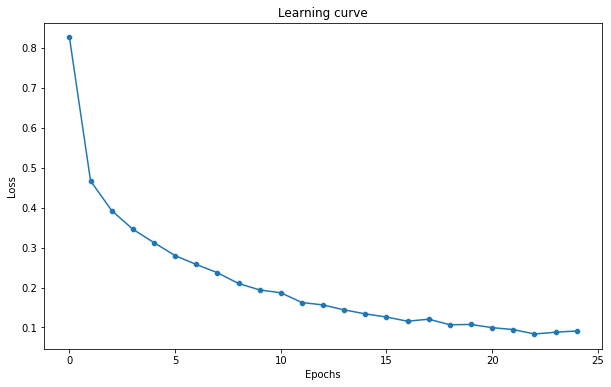

In [132]:
idx = 0
print(super_names[idx])
fig = plt.figure()
fig = plt.figure(figsize=(10,6))
p = sns.lineplot(data=df_loss, x="Epochs", y=idx)
p = sns.scatterplot(data=df_loss, x="Epochs", y=idx)
p.set_title("Learning curve")   # change here
p.set(xlabel='Epochs', ylabel='Loss')

Simple CNN with ReLU


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

<Figure size 432x288 with 0 Axes>

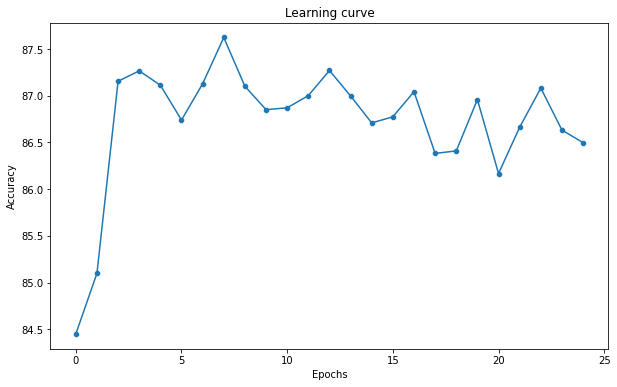

In [133]:
idx = 0
print(super_names[idx])
fig = plt.figure()
fig = plt.figure(figsize=(10,6))
p = sns.lineplot(data=df_acc, x="Epochs", y=idx)
p = sns.scatterplot(data=df_acc, x="Epochs", y=idx)
p.set_title("Learning curve")   # change here
p.set(xlabel='Epochs', ylabel='Accuracy')

CNN with ReLU using L1 Regularization


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

<Figure size 432x288 with 0 Axes>

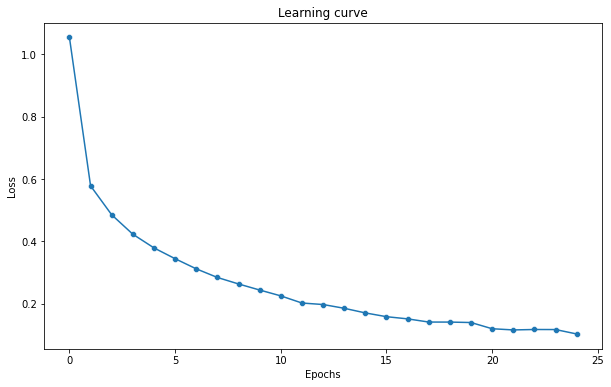

In [134]:
idx = 1
print(super_names[idx])
fig = plt.figure()
fig = plt.figure(figsize=(10,6))
p = sns.lineplot(data=df_loss, x="Epochs", y=idx)
p = sns.scatterplot(data=df_loss, x="Epochs", y=idx)
p.set_title("Learning curve")   # change here
p.set(xlabel='Epochs', ylabel='Loss')

CNN with ReLU using L1 Regularization


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

<Figure size 432x288 with 0 Axes>

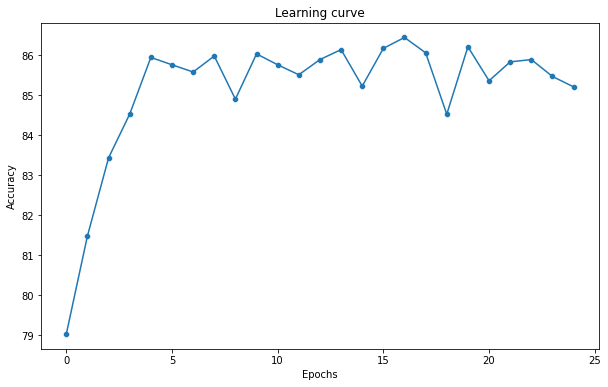

In [135]:
idx = 1
print(super_names[idx])
fig = plt.figure()
fig = plt.figure(figsize=(10,6))
p = sns.lineplot(data=df_acc, x="Epochs", y=idx)
p = sns.scatterplot(data=df_acc, x="Epochs", y=idx)
p.set_title("Learning curve")   # change here
p.set(xlabel='Epochs', ylabel='Accuracy')

CNN with ReLU using L2 Regularization


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

<Figure size 432x288 with 0 Axes>

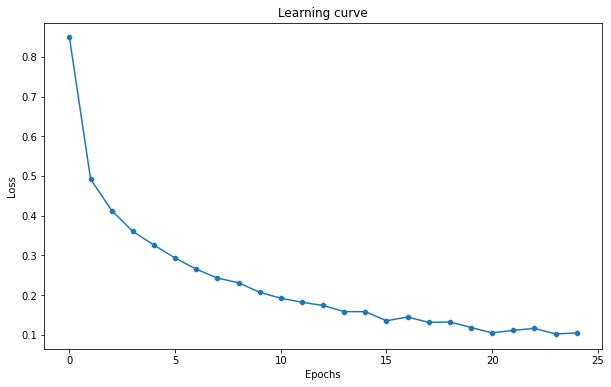

In [136]:
idx = 2
print(super_names[idx])
fig = plt.figure()
fig = plt.figure(figsize=(10,6))
p = sns.lineplot(data=df_loss, x="Epochs", y=idx)
p = sns.scatterplot(data=df_loss, x="Epochs", y=idx)
p.set_title("Learning curve")   # change here
p.set(xlabel='Epochs', ylabel='Loss')

CNN with ReLU using L2 Regularization


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

<Figure size 432x288 with 0 Axes>

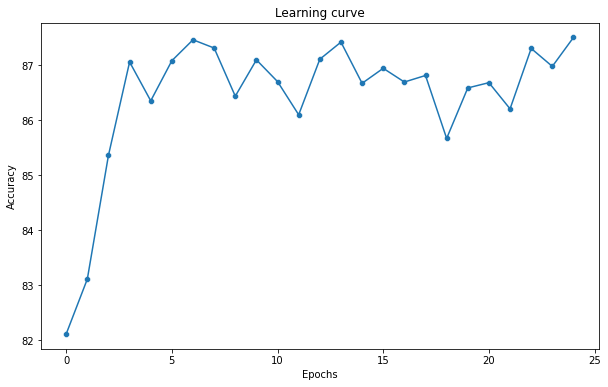

In [137]:
idx = 2
print(super_names[idx])
fig = plt.figure()
fig = plt.figure(figsize=(10,6))
p = sns.lineplot(data=df_acc, x="Epochs", y=idx)
p = sns.scatterplot(data=df_acc, x="Epochs", y=idx)
p.set_title("Learning curve")   # change here
p.set(xlabel='Epochs', ylabel='Accuracy')

CNN with ReLU using Elastic Regularization


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

<Figure size 432x288 with 0 Axes>

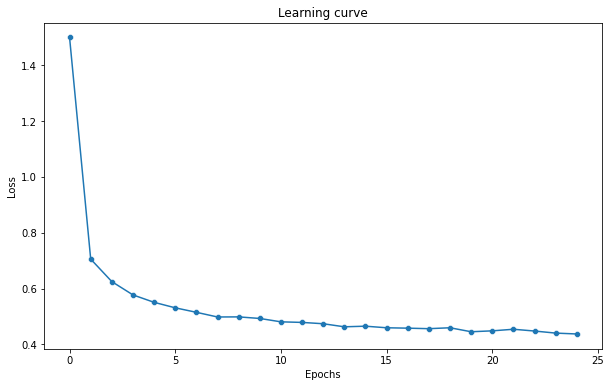

In [138]:
idx = 3
print(super_names[idx])
fig = plt.figure()
fig = plt.figure(figsize=(10,6))
p = sns.lineplot(data=df_loss, x="Epochs", y=idx)
p = sns.scatterplot(data=df_loss, x="Epochs", y=idx)
p.set_title("Learning curve")   # change here
p.set(xlabel='Epochs', ylabel='Loss')

CNN with ReLU using Elastic Regularization


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

<Figure size 432x288 with 0 Axes>

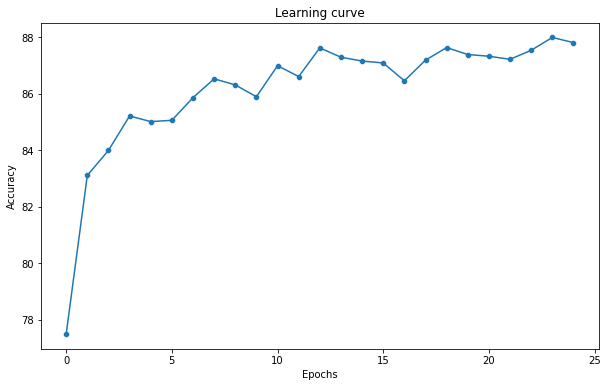

In [139]:
idx = 3
print(super_names[idx])
fig = plt.figure()
fig = plt.figure(figsize=(10,6))
p = sns.lineplot(data=df_acc, x="Epochs", y=idx)
p = sns.scatterplot(data=df_acc, x="Epochs", y=idx)
p.set_title("Learning curve")   # change here
p.set(xlabel='Epochs', ylabel='Accuracy')

CNN with ReLU using Dropout


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

<Figure size 432x288 with 0 Axes>

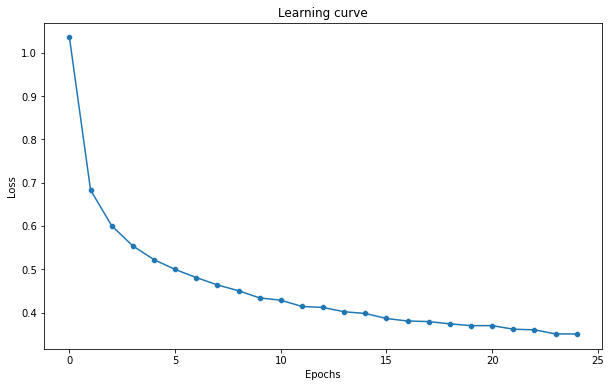

In [140]:
idx = 4
print(super_names[idx])
fig = plt.figure()
fig = plt.figure(figsize=(10,6))
p = sns.lineplot(data=df_loss, x="Epochs", y=idx)
p = sns.scatterplot(data=df_loss, x="Epochs", y=idx)
p.set_title("Learning curve")   # change here
p.set(xlabel='Epochs', ylabel='Loss')

CNN with ReLU using Dropout


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

<Figure size 432x288 with 0 Axes>

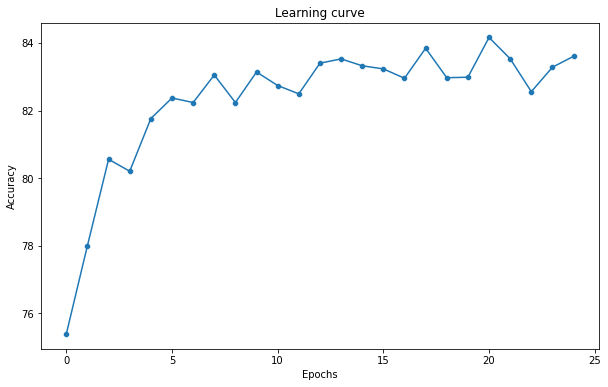

In [141]:
idx = 4
print(super_names[idx])
fig = plt.figure()
fig = plt.figure(figsize=(10,6))
p = sns.lineplot(data=df_acc, x="Epochs", y=idx)
p = sns.scatterplot(data=df_acc, x="Epochs", y=idx)
p.set_title("Learning curve")   # change here
p.set(xlabel='Epochs', ylabel='Accuracy')

CNN with ReLU using Average Pooling


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

<Figure size 432x288 with 0 Axes>

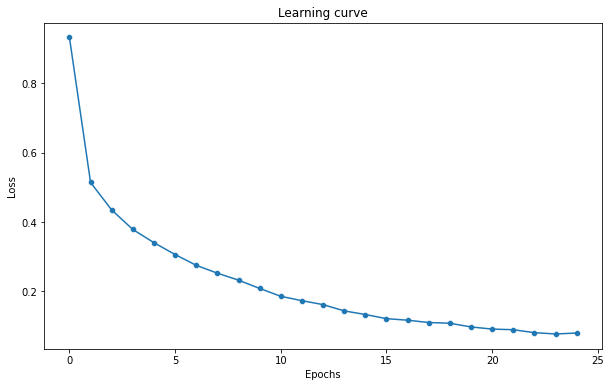

In [142]:
idx = 5
print(super_names[idx])
fig = plt.figure()
fig = plt.figure(figsize=(10,6))
p = sns.lineplot(data=df_loss, x="Epochs", y=idx)
p = sns.scatterplot(data=df_loss, x="Epochs", y=idx)
p.set_title("Learning curve")   # change here
p.set(xlabel='Epochs', ylabel='Loss')

CNN with ReLU using Average Pooling


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

<Figure size 432x288 with 0 Axes>

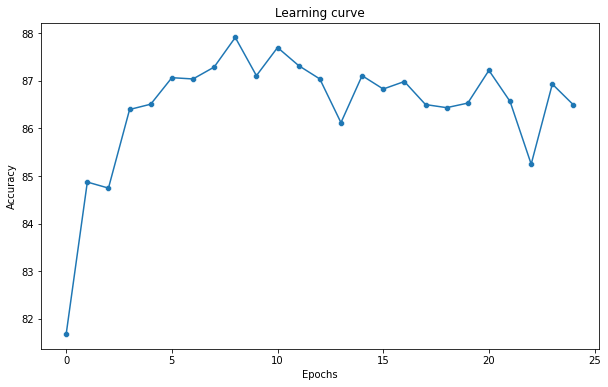

In [143]:
idx = 5
print(super_names[idx])
fig = plt.figure()
fig = plt.figure(figsize=(10,6))
p = sns.lineplot(data=df_acc, x="Epochs", y=idx)
p = sns.scatterplot(data=df_acc, x="Epochs", y=idx)
p.set_title("Learning curve")   # change here
p.set(xlabel='Epochs', ylabel='Accuracy')

CNN with ReLU using combination of Maximum and Average Pooling


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

<Figure size 432x288 with 0 Axes>

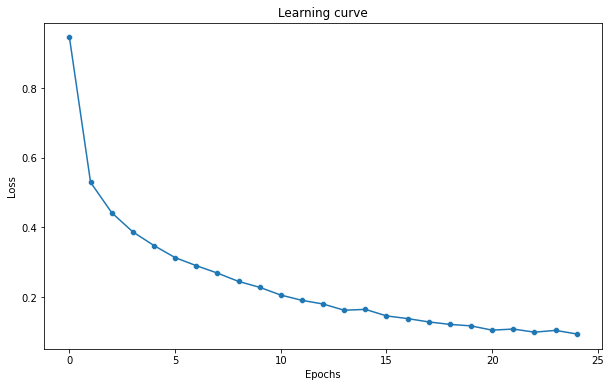

In [144]:
idx = 6
print(super_names[idx])
fig = plt.figure()
fig = plt.figure(figsize=(10,6))
p = sns.lineplot(data=df_loss, x="Epochs", y=idx)
p = sns.scatterplot(data=df_loss, x="Epochs", y=idx)
p.set_title("Learning curve")   # change here
p.set(xlabel='Epochs', ylabel='Loss')

CNN with ReLU using combination of Maximum and Average Pooling


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

<Figure size 432x288 with 0 Axes>

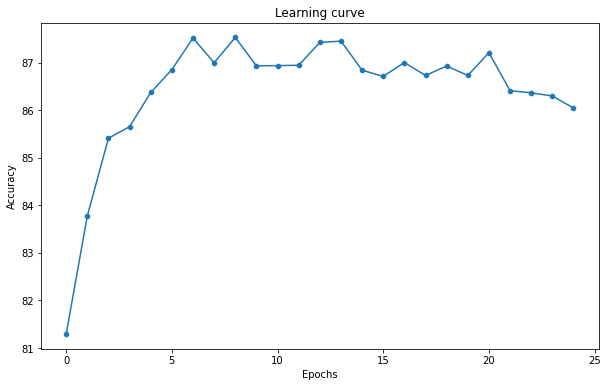

In [145]:
idx = 6
print(super_names[idx])
fig = plt.figure()
fig = plt.figure(figsize=(10,6))
p = sns.lineplot(data=df_acc, x="Epochs", y=idx)
p = sns.scatterplot(data=df_acc, x="Epochs", y=idx)
p.set_title("Learning curve")   # change here
p.set(xlabel='Epochs', ylabel='Accuracy')

# Varying alpha and lambda in elastic regularization

In [45]:
device = "cuda"
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 6, 5)  #
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.conv_layer2 = nn.Conv2d(6, 16, 5)  #
        self.maxpool2 = nn.MaxPool2d(2,2)
        
        #n_size = self._get_conv_output(input_shape)
        #self.fc1 = nn.Linear(n_size, 512)
        
        self.fc1 = nn.Linear(16*5*5, 256)   # this 16*5*5 must be changed 
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        
    def forward(self,x):
        x = self.maxpool1(F.relu(self.conv_layer1(x)))
        x = self.maxpool2(F.relu(self.conv_layer2(x)))
        x = x.view(-1,16*5*5)  # this 16*5*5 must be changed 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
loss_elastic = []
acc_elastic = []

In [46]:
alpha_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
lambda_list = [0.0001,0.00001]

for alphs in alpha_list:
    for lambds in lambda_list:
        model = CNN().to(device)   

        params = count_model_params(model)
        print(f"Model has {params} learnable parameters")

        EPOCHS = 25
        LR = 0.001
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)



        loss_hist = []
        acc_hist = []

        for epoch in range( EPOCHS):
            loss_list = []
            progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
            for i, (images, labels) in progress_bar:
                images = images.to(device)
                labels = labels.to(device)

                # Clear gradients w.r.t. parameters
                optimizer.zero_grad()

                # Forward pass to get output/logits
                outputs = model(images)

                # Calculate Loss: softmax --> cross entropy loss
                loss = criterion(outputs, labels)

                #https://www.machinecurve.com/index.php/2020/01/21/what-are-l1-l2-and-elastic-net-regularization-in-neural-networks/#elastic-net-regularization

                #alpha = 0.8
                #lambdaa = 0.000001
                # https://www.programmersought.com/article/52011513926/
                # https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net

                l1_norm = torch.tensor(0.).to(device)
                for param in model.parameters():
                    l1_norm += torch.sum(abs(param))

                l2_norm = torch.tensor(0.).to(device)
                for param in model.parameters():
                    l2_norm += torch.sum(abs(param))**2 

                loss = loss + lambdaa*(((1-alpha)*l1_norm) + (alpha*l2_norm))


                loss_list.append(loss.item())

                # Getting gradients w.r.t. parameters
                loss.backward()

                # Updating parameters
                optimizer.step()
                progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")

            loss_hist.append(np.mean(loss_list))
            accuracy, _ = eval_model(model)  
            acc_hist.append(accuracy)
            print(f"Classification accuracy: {round(accuracy, 2)}%")

        loss_elastic.append(loss_hist)
        acc_elastic.append(acc_hist)
        

Epoch 1 Iter 19: loss 4.09790. :   2%|▏       | 10/573 [00:00<00:05, 94.59it/s]

Model has 122626 learnable parameters


Epoch 2 Iter 19: loss 0.87642. :   2%|▏      | 11/573 [00:00<00:05, 106.55it/s]

Classification accuracy: 80.02%


Epoch 3 Iter 20: loss 0.56048. :   2%|▏      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 83.04%


Epoch 4 Iter 19: loss 0.75540. :   2%|▏       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 84.03%


Epoch 5 Iter 21: loss 0.58796. :   2%|▏      | 13/573 [00:00<00:04, 120.69it/s]

Classification accuracy: 84.77%


Epoch 6 Iter 18: loss 0.43486. :   2%|▏      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 85.59%


Epoch 7 Iter 19: loss 0.50178. :   2%|▏      | 12/573 [00:00<00:04, 115.69it/s]

Classification accuracy: 85.64%


Epoch 8 Iter 21: loss 0.65100. :   2%|▏      | 12/573 [00:00<00:05, 111.36it/s]

Classification accuracy: 86.88%


Epoch 9 Iter 23: loss 0.48362. :   2%|▏      | 13/573 [00:00<00:04, 126.55it/s]

Classification accuracy: 86.9%


Epoch 10 Iter 21: loss 0.63806. :   2%|      | 11/573 [00:00<00:05, 109.24it/s]

Classification accuracy: 86.12%


Epoch 11 Iter 21: loss 0.53503. :   2%|▏     | 12/573 [00:00<00:04, 119.13it/s]

Classification accuracy: 86.55%


Epoch 12 Iter 21: loss 0.46756. :   2%|▏     | 12/573 [00:00<00:05, 111.44it/s]

Classification accuracy: 87.63%


Epoch 13 Iter 22: loss 0.55383. :   2%|▏     | 12/573 [00:00<00:04, 116.81it/s]

Classification accuracy: 87.93%


Epoch 14 Iter 22: loss 0.33105. :   2%|▏     | 12/573 [00:00<00:04, 118.00it/s]

Classification accuracy: 87.13%


Epoch 15 Iter 23: loss 0.48886. :   2%|▏     | 13/573 [00:00<00:04, 121.82it/s]

Classification accuracy: 87.63%


Epoch 16 Iter 21: loss 0.36948. :   2%|▏     | 12/573 [00:00<00:04, 113.49it/s]

Classification accuracy: 85.86%


Epoch 17 Iter 22: loss 0.54435. :   2%|▏     | 12/573 [00:00<00:04, 114.59it/s]

Classification accuracy: 87.09%


Epoch 18 Iter 22: loss 0.45261. :   2%|▏     | 12/573 [00:00<00:04, 119.13it/s]

Classification accuracy: 87.25%


Epoch 19 Iter 20: loss 0.32130. :   2%|      | 11/573 [00:00<00:05, 109.20it/s]

Classification accuracy: 86.52%


Epoch 20 Iter 21: loss 0.40036. :   2%|▏     | 12/573 [00:00<00:04, 112.45it/s]

Classification accuracy: 87.9%


Epoch 21 Iter 22: loss 0.41525. :   2%|▏     | 12/573 [00:00<00:04, 115.73it/s]

Classification accuracy: 87.27%


Epoch 22 Iter 21: loss 0.58872. :   2%|▏     | 12/573 [00:00<00:05, 111.40it/s]

Classification accuracy: 87.32%


Epoch 23 Iter 22: loss 0.58619. :   2%|▏     | 12/573 [00:00<00:04, 119.12it/s]

Classification accuracy: 87.67%


Epoch 24 Iter 19: loss 0.38762. :   2%|      | 11/573 [00:00<00:05, 103.07it/s]

Classification accuracy: 87.28%


Epoch 25 Iter 19: loss 0.51113. :   2%|       | 10/573 [00:00<00:05, 96.36it/s]

Classification accuracy: 87.42%


Epoch 1 Iter 19: loss 4.42824. :   2%|▏      | 11/573 [00:00<00:05, 106.04it/s]

Classification accuracy: 87.64%
Model has 122626 learnable parameters


Epoch 2 Iter 20: loss 0.89952. :   2%|▏      | 11/573 [00:00<00:05, 107.11it/s]

Classification accuracy: 80.93%


Epoch 3 Iter 18: loss 0.65779. :   2%|▏       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 83.82%


Epoch 4 Iter 20: loss 0.61065. :   2%|▏      | 11/573 [00:00<00:05, 104.04it/s]

Classification accuracy: 84.33%


Epoch 5 Iter 19: loss 0.64356. :   2%|▏      | 11/573 [00:00<00:05, 107.11it/s]

Classification accuracy: 85.61%


Epoch 6 Iter 19: loss 0.42624. :   2%|▏       | 10/573 [00:00<00:05, 99.30it/s]

Classification accuracy: 86.22%


Epoch 7 Iter 19: loss 0.48416. :   2%|▏       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 86.59%


Epoch 8 Iter 20: loss 0.48571. :   2%|▏       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 87.55%


Epoch 9 Iter 19: loss 0.40022. :   2%|▏      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 86.99%


Epoch 10 Iter 19: loss 0.33994. :   2%|      | 11/573 [00:00<00:05, 101.18it/s]

Classification accuracy: 86.94%


Epoch 11 Iter 18: loss 0.41537. :   2%|       | 10/573 [00:00<00:05, 97.81it/s]

Classification accuracy: 86.32%


Epoch 12 Iter 20: loss 0.32585. :   2%|      | 11/573 [00:00<00:05, 105.04it/s]

Classification accuracy: 87.27%


Epoch 13 Iter 19: loss 0.39898. :   2%|      | 11/573 [00:00<00:05, 102.16it/s]

Classification accuracy: 87.45%


Epoch 14 Iter 20: loss 0.35419. :   2%|       | 10/573 [00:00<00:05, 99.30it/s]

Classification accuracy: 86.96%


Epoch 15 Iter 19: loss 0.35025. :   2%|       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 88.2%


Epoch 16 Iter 18: loss 0.51807. :   2%|       | 10/573 [00:00<00:05, 94.63it/s]

Classification accuracy: 87.83%


Epoch 17 Iter 19: loss 0.40482. :   2%|▏     | 12/573 [00:00<00:05, 110.38it/s]

Classification accuracy: 87.86%


Epoch 18 Iter 19: loss 0.50318. :   2%|      | 11/573 [00:00<00:05, 100.27it/s]

Classification accuracy: 87.82%


Epoch 19 Iter 20: loss 0.37870. :   2%|      | 11/573 [00:00<00:05, 105.06it/s]

Classification accuracy: 87.37%


Epoch 20 Iter 18: loss 0.41926. :   2%|      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 87.97%


Epoch 21 Iter 21: loss 0.36848. :   2%|      | 11/573 [00:00<00:05, 106.08it/s]

Classification accuracy: 87.92%


Epoch 22 Iter 18: loss 0.36994. :   2%|       | 10/573 [00:00<00:05, 97.34it/s]

Classification accuracy: 87.49%


Epoch 23 Iter 21: loss 0.41456. :   2%|▏     | 12/573 [00:00<00:04, 113.51it/s]

Classification accuracy: 86.84%


Epoch 24 Iter 22: loss 0.36743. :   2%|▏     | 13/573 [00:00<00:04, 122.93it/s]

Classification accuracy: 88.21%


Epoch 25 Iter 19: loss 0.41149. :   2%|      | 11/573 [00:00<00:05, 102.15it/s]

Classification accuracy: 87.74%


Epoch 1 Iter 19: loss 4.41028. :   2%|▏      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 87.95%
Model has 122626 learnable parameters


Epoch 2 Iter 18: loss 0.76823. :   2%|▏       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 79.56%


Epoch 3 Iter 19: loss 0.60937. :   2%|▏      | 11/573 [00:00<00:05, 107.08it/s]

Classification accuracy: 84.13%


Epoch 4 Iter 19: loss 0.46417. :   2%|▏      | 11/573 [00:00<00:05, 108.13it/s]

Classification accuracy: 84.64%


Epoch 5 Iter 17: loss 0.39426. :   2%|▏       | 10/573 [00:00<00:06, 93.73it/s]

Classification accuracy: 85.34%


Epoch 6 Iter 20: loss 0.59037. :   2%|▏      | 11/573 [00:00<00:05, 109.24it/s]

Classification accuracy: 85.94%


Epoch 7 Iter 20: loss 0.43443. :   2%|▏      | 11/573 [00:00<00:05, 103.05it/s]

Classification accuracy: 86.89%


Epoch 8 Iter 19: loss 0.40716. :   2%|▏       | 10/573 [00:00<00:05, 97.36it/s]

Classification accuracy: 86.16%


Epoch 9 Iter 19: loss 0.43532. :   2%|▏      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 86.11%


Epoch 10 Iter 19: loss 0.43650. :   2%|       | 10/573 [00:00<00:05, 96.41it/s]

Classification accuracy: 87.24%


Epoch 11 Iter 19: loss 0.53862. :   2%|      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 86.6%


Epoch 12 Iter 19: loss 0.35151. :   2%|      | 11/573 [00:00<00:05, 100.28it/s]

Classification accuracy: 86.8%


Epoch 13 Iter 19: loss 0.46445. :   2%|       | 10/573 [00:00<00:05, 97.35it/s]

Classification accuracy: 86.28%


Epoch 14 Iter 20: loss 0.49621. :   2%|      | 11/573 [00:00<00:05, 108.16it/s]

Classification accuracy: 86.89%


Epoch 15 Iter 19: loss 0.28068. :   2%|      | 11/573 [00:00<00:05, 101.18it/s]

Classification accuracy: 86.93%


Epoch 16 Iter 19: loss 0.56686. :   2%|      | 11/573 [00:00<00:05, 102.15it/s]

Classification accuracy: 85.94%


Epoch 17 Iter 19: loss 0.58805. :   2%|      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 87.33%


Epoch 18 Iter 19: loss 0.45906. :   2%|      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 86.79%


Epoch 19 Iter 18: loss 0.49336. :   2%|       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 86.15%


Epoch 20 Iter 19: loss 0.46871. :   2%|      | 11/573 [00:00<00:05, 102.16it/s]

Classification accuracy: 87.26%


Epoch 21 Iter 21: loss 0.53513. :   2%|      | 11/573 [00:00<00:05, 109.23it/s]

Classification accuracy: 86.59%


Epoch 22 Iter 19: loss 0.52590. :   2%|      | 11/573 [00:00<00:05, 108.15it/s]

Classification accuracy: 86.78%


Epoch 23 Iter 20: loss 0.47832. :   2%|      | 11/573 [00:00<00:05, 107.11it/s]

Classification accuracy: 86.97%


Epoch 24 Iter 19: loss 0.43803. :   2%|      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 87.34%


Epoch 25 Iter 20: loss 0.32098. :   2%|      | 11/573 [00:00<00:05, 104.08it/s]

Classification accuracy: 86.82%


Epoch 1 Iter 19: loss 4.24285. :   2%|▏       | 10/573 [00:00<00:05, 97.38it/s]

Classification accuracy: 87.1%
Model has 122626 learnable parameters


Epoch 2 Iter 18: loss 0.76498. :   2%|▏       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 80.84%


Epoch 3 Iter 20: loss 0.68619. :   2%|▏      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 83.19%


Epoch 4 Iter 19: loss 0.54093. :   2%|▏       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 84.19%


Epoch 5 Iter 20: loss 0.50931. :   2%|▏      | 11/573 [00:00<00:05, 109.20it/s]

Classification accuracy: 85.47%


Epoch 6 Iter 20: loss 0.57342. :   2%|▏      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 84.54%


Epoch 7 Iter 20: loss 0.50550. :   2%|▏      | 11/573 [00:00<00:05, 103.07it/s]

Classification accuracy: 85.74%


Epoch 8 Iter 19: loss 0.52622. :   2%|▏      | 11/573 [00:00<00:05, 103.11it/s]

Classification accuracy: 86.63%


Epoch 9 Iter 17: loss 0.51276. :   2%|▏       | 10/573 [00:00<00:05, 97.35it/s]

Classification accuracy: 85.44%


Epoch 10 Iter 19: loss 0.36621. :   2%|       | 10/573 [00:00<00:05, 96.44it/s]

Classification accuracy: 86.3%


Epoch 11 Iter 20: loss 0.41602. :   2%|      | 11/573 [00:00<00:05, 105.07it/s]

Classification accuracy: 86.57%


Epoch 12 Iter 19: loss 0.29142. :   2%|      | 11/573 [00:00<00:05, 107.08it/s]

Classification accuracy: 86.85%


Epoch 13 Iter 19: loss 0.42729. :   2%|      | 11/573 [00:00<00:05, 100.28it/s]

Classification accuracy: 86.84%


Epoch 14 Iter 18: loss 0.40121. :   2%|      | 11/573 [00:00<00:05, 101.18it/s]

Classification accuracy: 86.77%


Epoch 15 Iter 18: loss 0.39097. :   2%|      | 11/573 [00:00<00:05, 101.19it/s]

Classification accuracy: 86.58%


Epoch 16 Iter 19: loss 0.30956. :   2%|      | 11/573 [00:00<00:05, 102.15it/s]

Classification accuracy: 86.08%


Epoch 17 Iter 18: loss 0.65803. :   2%|       | 10/573 [00:00<00:05, 98.27it/s]

Classification accuracy: 86.81%


Epoch 18 Iter 18: loss 0.31990. :   2%|      | 11/573 [00:00<00:05, 101.22it/s]

Classification accuracy: 86.41%


Epoch 19 Iter 19: loss 0.38641. :   2%|      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 86.78%


Epoch 20 Iter 19: loss 0.58839. :   2%|      | 11/573 [00:00<00:05, 107.12it/s]

Classification accuracy: 86.92%


Epoch 21 Iter 20: loss 0.32537. :   2%|      | 11/573 [00:00<00:05, 106.05it/s]

Classification accuracy: 87.15%


Epoch 22 Iter 19: loss 0.32513. :   2%|▏      | 11/573 [00:00<00:05, 98.50it/s]

Classification accuracy: 86.97%


Epoch 23 Iter 20: loss 0.31865. :   2%|▏     | 12/573 [00:00<00:04, 112.45it/s]

Classification accuracy: 86.88%


Epoch 24 Iter 20: loss 0.50198. :   2%|       | 10/573 [00:00<00:05, 98.78it/s]

Classification accuracy: 87.09%


Epoch 25 Iter 18: loss 0.42181. :   2%|       | 10/573 [00:00<00:05, 95.49it/s]

Classification accuracy: 87.02%


Epoch 1 Iter 20: loss 4.18711. :   2%|▏      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 87.18%
Model has 122626 learnable parameters


Epoch 2 Iter 19: loss 0.72934. :   2%|▏       | 10/573 [00:00<00:05, 99.29it/s]

Classification accuracy: 82.15%


Epoch 3 Iter 18: loss 0.68450. :   2%|▏       | 10/573 [00:00<00:05, 99.31it/s]

Classification accuracy: 83.85%


Epoch 4 Iter 19: loss 0.36661. :   2%|▏       | 10/573 [00:00<00:05, 98.33it/s]

Classification accuracy: 84.74%


Epoch 5 Iter 19: loss 0.40381. :   2%|▏      | 11/573 [00:00<00:05, 100.26it/s]

Classification accuracy: 85.88%


Epoch 6 Iter 19: loss 0.52623. :   2%|▏      | 11/573 [00:00<00:05, 108.13it/s]

Classification accuracy: 85.31%


Epoch 7 Iter 18: loss 0.84728. :   2%|▏      | 11/573 [00:00<00:05, 100.26it/s]

Classification accuracy: 85.8%


Epoch 8 Iter 19: loss 0.50024. :   2%|▏      | 11/573 [00:00<00:05, 107.08it/s]

Classification accuracy: 86.68%


Epoch 9 Iter 18: loss 0.60048. :   2%|▏       | 10/573 [00:00<00:05, 95.51it/s]

Classification accuracy: 87.34%


Epoch 10 Iter 20: loss 0.46141. :   2%|      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 86.65%


Epoch 11 Iter 18: loss 0.34951. :   2%|       | 10/573 [00:00<00:06, 91.99it/s]

Classification accuracy: 87.28%


Epoch 12 Iter 18: loss 0.44592. :   2%|       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 87.37%


Epoch 13 Iter 17: loss 0.48245. :   2%|       | 10/573 [00:00<00:05, 97.35it/s]

Classification accuracy: 86.84%


Epoch 14 Iter 20: loss 0.52455. :   2%|      | 11/573 [00:00<00:05, 108.16it/s]

Classification accuracy: 87.71%


Epoch 15 Iter 19: loss 0.70645. :   2%|       | 10/573 [00:00<00:05, 95.49it/s]

Classification accuracy: 87.3%


Epoch 16 Iter 18: loss 0.57723. :   2%|       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 87.98%


Epoch 17 Iter 20: loss 0.35660. :   2%|      | 11/573 [00:00<00:05, 105.04it/s]

Classification accuracy: 87.29%


Epoch 18 Iter 20: loss 0.52530. :   2%|      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 88.26%


Epoch 19 Iter 18: loss 0.38875. :   2%|       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 86.6%


Epoch 20 Iter 19: loss 0.45529. :   2%|      | 11/573 [00:00<00:05, 101.19it/s]

Classification accuracy: 87.68%


Epoch 21 Iter 18: loss 0.34311. :   2%|      | 11/573 [00:00<00:05, 101.18it/s]

Classification accuracy: 87.42%


Epoch 22 Iter 19: loss 0.58308. :   2%|      | 11/573 [00:00<00:05, 105.04it/s]

Classification accuracy: 88.0%


Epoch 23 Iter 19: loss 0.46681. :   2%|      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 87.62%


Epoch 24 Iter 18: loss 0.34415. :   2%|       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 87.93%


Epoch 25 Iter 20: loss 0.33364. :   2%|      | 11/573 [00:00<00:05, 109.20it/s]

Classification accuracy: 87.88%


Epoch 1 Iter 17: loss 5.10587. :   2%|▏       | 10/573 [00:00<00:05, 96.41it/s]

Classification accuracy: 87.34%
Model has 122626 learnable parameters


Epoch 2 Iter 18: loss 0.72378. :   2%|▏       | 10/573 [00:00<00:05, 97.38it/s]

Classification accuracy: 79.61%


Epoch 3 Iter 18: loss 0.60247. :   2%|▏       | 10/573 [00:00<00:05, 97.37it/s]

Classification accuracy: 80.84%


Epoch 4 Iter 18: loss 0.64677. :   2%|▏       | 10/573 [00:00<00:05, 94.59it/s]

Classification accuracy: 82.56%


Epoch 5 Iter 20: loss 0.49142. :   2%|▏      | 11/573 [00:00<00:05, 100.26it/s]

Classification accuracy: 84.61%


Epoch 6 Iter 18: loss 0.54010. :   2%|▏       | 10/573 [00:00<00:06, 92.01it/s]

Classification accuracy: 84.23%


Epoch 7 Iter 21: loss 0.52740. :   2%|▏      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 85.13%


Epoch 8 Iter 19: loss 0.44742. :   2%|▏       | 10/573 [00:00<00:05, 96.44it/s]

Classification accuracy: 84.18%


Epoch 9 Iter 19: loss 0.45428. :   2%|▏      | 11/573 [00:00<00:05, 108.13it/s]

Classification accuracy: 84.99%


Epoch 10 Iter 18: loss 0.45195. :   2%|      | 11/573 [00:00<00:05, 101.18it/s]

Classification accuracy: 85.47%


Epoch 11 Iter 20: loss 0.45776. :   2%|      | 11/573 [00:00<00:05, 100.30it/s]

Classification accuracy: 85.13%


Epoch 12 Iter 19: loss 0.67208. :   2%|      | 11/573 [00:00<00:05, 107.08it/s]

Classification accuracy: 86.21%


Epoch 13 Iter 19: loss 0.57676. :   2%|       | 10/573 [00:00<00:05, 99.30it/s]

Classification accuracy: 85.49%


Epoch 14 Iter 21: loss 0.61028. :   2%|      | 11/573 [00:00<00:05, 108.16it/s]

Classification accuracy: 86.06%


Epoch 15 Iter 19: loss 0.49898. :   2%|      | 11/573 [00:00<00:05, 102.15it/s]

Classification accuracy: 86.79%


Epoch 16 Iter 20: loss 0.37076. :   2%|      | 11/573 [00:00<00:05, 106.60it/s]

Classification accuracy: 86.02%


Epoch 17 Iter 19: loss 0.49181. :   2%|      | 11/573 [00:00<00:05, 103.07it/s]

Classification accuracy: 86.2%


Epoch 18 Iter 19: loss 0.36315. :   2%|      | 11/573 [00:00<00:05, 100.27it/s]

Classification accuracy: 86.19%


Epoch 19 Iter 20: loss 0.45783. :   2%|      | 11/573 [00:00<00:05, 107.08it/s]

Classification accuracy: 86.97%


Epoch 20 Iter 19: loss 0.49431. :   2%|      | 11/573 [00:00<00:05, 106.08it/s]

Classification accuracy: 86.19%


Epoch 21 Iter 21: loss 0.47985. :   2%|      | 11/573 [00:00<00:05, 107.11it/s]

Classification accuracy: 86.69%


Epoch 22 Iter 20: loss 0.52277. :   2%|      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 85.91%


Epoch 23 Iter 20: loss 0.49320. :   2%|      | 11/573 [00:00<00:05, 101.18it/s]

Classification accuracy: 86.23%


Epoch 24 Iter 21: loss 0.47268. :   2%|      | 11/573 [00:00<00:05, 103.07it/s]

Classification accuracy: 85.93%


Epoch 25 Iter 20: loss 0.40273. :   2%|      | 11/573 [00:00<00:05, 106.05it/s]

Classification accuracy: 86.21%


Epoch 1 Iter 18: loss 4.24498. :   2%|▏       | 10/573 [00:00<00:05, 98.31it/s]

Classification accuracy: 86.14%
Model has 122626 learnable parameters


Epoch 2 Iter 19: loss 0.65617. :   2%|▏       | 10/573 [00:00<00:05, 97.37it/s]

Classification accuracy: 81.33%


Epoch 3 Iter 19: loss 0.51167. :   2%|▏      | 11/573 [00:00<00:05, 106.08it/s]

Classification accuracy: 83.79%


Epoch 4 Iter 20: loss 0.45090. :   2%|▏      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 83.8%


Epoch 5 Iter 19: loss 0.56336. :   2%|▏      | 11/573 [00:00<00:05, 107.11it/s]

Classification accuracy: 85.72%


Epoch 6 Iter 20: loss 0.48997. :   2%|▏      | 12/573 [00:00<00:05, 110.42it/s]

Classification accuracy: 85.3%


Epoch 7 Iter 20: loss 0.47647. :   2%|▏      | 11/573 [00:00<00:05, 106.05it/s]

Classification accuracy: 86.12%


Epoch 8 Iter 18: loss 0.50772. :   2%|▏      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 85.44%


Epoch 9 Iter 19: loss 0.37644. :   2%|▏      | 11/573 [00:00<00:05, 101.18it/s]

Classification accuracy: 86.34%


Epoch 10 Iter 19: loss 0.37148. :   2%|▏      | 11/573 [00:00<00:05, 99.36it/s]

Classification accuracy: 85.93%


Epoch 11 Iter 19: loss 0.54029. :   2%|      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 85.85%


Epoch 12 Iter 19: loss 0.45525. :   2%|      | 11/573 [00:00<00:05, 105.04it/s]

Classification accuracy: 86.41%


Epoch 13 Iter 21: loss 0.51267. :   2%|▏     | 12/573 [00:00<00:05, 110.42it/s]

Classification accuracy: 86.53%


Epoch 14 Iter 20: loss 0.59471. :   2%|▏     | 12/573 [00:00<00:04, 112.48it/s]

Classification accuracy: 86.46%


Epoch 15 Iter 19: loss 0.40551. :   2%|       | 10/573 [00:00<00:05, 99.30it/s]

Classification accuracy: 86.84%


Epoch 16 Iter 19: loss 0.34877. :   2%|      | 11/573 [00:00<00:05, 103.11it/s]

Classification accuracy: 86.95%


Epoch 17 Iter 19: loss 0.58330. :   2%|      | 11/573 [00:00<00:05, 108.13it/s]

Classification accuracy: 86.44%


Epoch 18 Iter 18: loss 0.37600. :   2%|       | 10/573 [00:00<00:05, 95.52it/s]

Classification accuracy: 85.91%


Epoch 19 Iter 18: loss 0.45168. :   2%|       | 10/573 [00:00<00:05, 95.35it/s]

Classification accuracy: 87.1%


Epoch 20 Iter 19: loss 0.48390. :   2%|       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 86.82%


Epoch 21 Iter 19: loss 0.33064. :   2%|       | 10/573 [00:00<00:05, 97.34it/s]

Classification accuracy: 86.82%


Epoch 22 Iter 20: loss 0.48603. :   2%|▏     | 12/573 [00:00<00:05, 109.41it/s]

Classification accuracy: 86.2%


Epoch 23 Iter 18: loss 0.36685. :   2%|▏      | 11/573 [00:00<00:05, 99.36it/s]

Classification accuracy: 86.74%


Epoch 24 Iter 18: loss 0.37972. :   2%|      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 87.77%


Epoch 25 Iter 20: loss 0.36026. :   2%|      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 88.05%


Epoch 1 Iter 20: loss 4.21434. :   2%|▏      | 11/573 [00:00<00:05, 105.07it/s]

Classification accuracy: 87.57%
Model has 122626 learnable parameters


Epoch 2 Iter 19: loss 0.59501. :   2%|▏      | 11/573 [00:00<00:05, 107.08it/s]

Classification accuracy: 79.07%


Epoch 3 Iter 19: loss 0.64243. :   2%|▏      | 11/573 [00:00<00:05, 103.07it/s]

Classification accuracy: 82.11%


Epoch 4 Iter 19: loss 0.76192. :   2%|▏      | 11/573 [00:00<00:05, 107.08it/s]

Classification accuracy: 84.86%


Epoch 5 Iter 19: loss 0.51643. :   2%|▏      | 11/573 [00:00<00:05, 100.29it/s]

Classification accuracy: 84.15%


Epoch 6 Iter 20: loss 0.52336. :   2%|▏      | 11/573 [00:00<00:05, 104.08it/s]

Classification accuracy: 84.47%


Epoch 7 Iter 18: loss 0.55399. :   2%|▏      | 11/573 [00:00<00:05, 105.04it/s]

Classification accuracy: 85.7%


Epoch 8 Iter 18: loss 0.43385. :   2%|▏      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 85.22%


Epoch 9 Iter 21: loss 0.34121. :   2%|▏      | 11/573 [00:00<00:05, 108.13it/s]

Classification accuracy: 85.92%


Epoch 10 Iter 20: loss 0.37861. :   2%|      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 85.9%


Epoch 11 Iter 19: loss 0.41705. :   2%|       | 10/573 [00:00<00:05, 98.33it/s]

Classification accuracy: 86.17%


Epoch 12 Iter 19: loss 0.40142. :   2%|      | 11/573 [00:00<00:05, 105.04it/s]

Classification accuracy: 86.66%


Epoch 13 Iter 19: loss 0.42379. :   2%|       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 83.96%


Epoch 14 Iter 19: loss 0.68021. :   2%|      | 11/573 [00:00<00:05, 100.29it/s]

Classification accuracy: 85.89%


Epoch 15 Iter 18: loss 0.50074. :   2%|      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 85.85%


Epoch 16 Iter 20: loss 0.51649. :   2%|      | 11/573 [00:00<00:05, 106.05it/s]

Classification accuracy: 86.99%


Epoch 17 Iter 19: loss 0.56088. :   2%|      | 11/573 [00:00<00:05, 101.19it/s]

Classification accuracy: 86.64%


Epoch 18 Iter 19: loss 0.54955. :   2%|      | 11/573 [00:00<00:05, 100.27it/s]

Classification accuracy: 86.64%


Epoch 19 Iter 20: loss 0.43210. :   2%|      | 11/573 [00:00<00:05, 104.06it/s]

Classification accuracy: 86.73%


Epoch 20 Iter 19: loss 0.42860. :   2%|      | 11/573 [00:00<00:05, 100.25it/s]

Classification accuracy: 87.35%


Epoch 21 Iter 19: loss 0.34655. :   2%|       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 86.32%


Epoch 22 Iter 19: loss 0.38363. :   2%|      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 85.74%


Epoch 23 Iter 18: loss 0.50571. :   2%|       | 10/573 [00:00<00:05, 96.41it/s]

Classification accuracy: 86.99%


Epoch 24 Iter 19: loss 0.42331. :   2%|      | 11/573 [00:00<00:05, 108.16it/s]

Classification accuracy: 86.64%


Epoch 25 Iter 18: loss 0.45839. :   2%|       | 10/573 [00:00<00:05, 97.37it/s]

Classification accuracy: 86.02%


Epoch 1 Iter 19: loss 4.57594. :   2%|▏      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 86.33%
Model has 122626 learnable parameters


Epoch 2 Iter 19: loss 0.81537. :   2%|▏       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 79.18%


Epoch 3 Iter 19: loss 0.78664. :   2%|▏       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 81.6%


Epoch 4 Iter 20: loss 0.58391. :   2%|▏      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 79.49%


Epoch 5 Iter 19: loss 0.55910. :   2%|▏      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 82.91%


Epoch 6 Iter 18: loss 0.54421. :   2%|▏       | 10/573 [00:00<00:05, 97.34it/s]

Classification accuracy: 83.4%


Epoch 7 Iter 19: loss 0.63554. :   2%|▏      | 11/573 [00:00<00:05, 102.16it/s]

Classification accuracy: 84.04%


Epoch 8 Iter 20: loss 0.45545. :   2%|▏      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 84.2%


Epoch 9 Iter 20: loss 0.45256. :   2%|▏      | 12/573 [00:00<00:04, 112.44it/s]

Classification accuracy: 83.2%


Epoch 10 Iter 19: loss 0.47104. :   2%|      | 11/573 [00:00<00:05, 104.09it/s]

Classification accuracy: 83.87%


Epoch 11 Iter 20: loss 0.34227. :   2%|       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 85.49%


Epoch 12 Iter 20: loss 0.42574. :   2%|      | 11/573 [00:00<00:05, 109.20it/s]

Classification accuracy: 85.59%


Epoch 13 Iter 19: loss 0.57290. :   2%|▏     | 12/573 [00:00<00:04, 114.62it/s]

Classification accuracy: 85.71%


Epoch 14 Iter 19: loss 0.67708. :   2%|▏     | 12/573 [00:00<00:05, 111.43it/s]

Classification accuracy: 84.78%


Epoch 15 Iter 18: loss 0.34880. :   2%|      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 86.36%


Epoch 16 Iter 20: loss 0.45920. :   2%|       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 85.74%


Epoch 17 Iter 19: loss 0.37035. :   2%|      | 11/573 [00:00<00:05, 104.08it/s]

Classification accuracy: 86.2%


Epoch 18 Iter 19: loss 0.50438. :   2%|       | 10/573 [00:00<00:05, 99.24it/s]

Classification accuracy: 85.38%


Epoch 19 Iter 19: loss 0.37489. :   2%|       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 86.58%


Epoch 20 Iter 19: loss 0.44452. :   2%|      | 11/573 [00:00<00:05, 103.11it/s]

Classification accuracy: 83.83%


Epoch 21 Iter 18: loss 0.47863. :   2%|       | 10/573 [00:00<00:05, 98.33it/s]

Classification accuracy: 86.13%


Epoch 22 Iter 20: loss 0.56018. :   2%|      | 11/573 [00:00<00:05, 101.21it/s]

Classification accuracy: 86.62%


Epoch 23 Iter 19: loss 0.36492. :   2%|      | 11/573 [00:00<00:05, 100.27it/s]

Classification accuracy: 86.18%


Epoch 24 Iter 19: loss 0.29245. :   2%|       | 10/573 [00:00<00:05, 97.34it/s]

Classification accuracy: 86.21%


Epoch 25 Iter 18: loss 0.34020. :   2%|       | 10/573 [00:00<00:05, 94.59it/s]

Classification accuracy: 86.26%


Epoch 1 Iter 19: loss 4.98497. :   2%|▏       | 10/573 [00:00<00:05, 98.29it/s]

Classification accuracy: 86.06%
Model has 122626 learnable parameters


Epoch 2 Iter 20: loss 0.93414. :   2%|▏      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 77.76%


Epoch 3 Iter 18: loss 0.72030. :   2%|▏       | 10/573 [00:00<00:05, 94.39it/s]

Classification accuracy: 80.45%


Epoch 4 Iter 18: loss 0.77858. :   2%|▏      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 82.92%


Epoch 5 Iter 18: loss 0.52839. :   2%|▏      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 83.7%


Epoch 6 Iter 18: loss 0.45924. :   2%|▏       | 10/573 [00:00<00:05, 96.41it/s]

Classification accuracy: 83.43%


Epoch 7 Iter 19: loss 0.47315. :   2%|▏       | 10/573 [00:00<00:05, 94.59it/s]

Classification accuracy: 84.12%


Epoch 8 Iter 20: loss 0.58536. :   2%|▏      | 12/573 [00:00<00:05, 110.38it/s]

Classification accuracy: 84.6%


Epoch 9 Iter 19: loss 0.66522. :   2%|▏      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 85.28%


Epoch 10 Iter 18: loss 0.45770. :   2%|      | 11/573 [00:00<00:05, 100.27it/s]

Classification accuracy: 84.22%


Epoch 11 Iter 20: loss 0.45059. :   2%|      | 11/573 [00:00<00:05, 105.07it/s]

Classification accuracy: 84.37%


Epoch 12 Iter 19: loss 0.46016. :   2%|      | 11/573 [00:00<00:05, 101.22it/s]

Classification accuracy: 84.89%


Epoch 13 Iter 19: loss 0.56820. :   2%|       | 10/573 [00:00<00:05, 97.38it/s]

Classification accuracy: 85.16%


Epoch 14 Iter 19: loss 0.41669. :   2%|      | 11/573 [00:00<00:05, 106.05it/s]

Classification accuracy: 84.96%


Epoch 15 Iter 19: loss 0.57609. :   2%|      | 11/573 [00:00<00:05, 109.20it/s]

Classification accuracy: 85.44%


Epoch 16 Iter 18: loss 0.62777. :   2%|       | 10/573 [00:00<00:05, 99.30it/s]

Classification accuracy: 85.46%


Epoch 17 Iter 20: loss 0.61260. :   2%|      | 11/573 [00:00<00:05, 106.96it/s]

Classification accuracy: 85.44%


Epoch 18 Iter 19: loss 0.41525. :   2%|      | 11/573 [00:00<00:05, 109.86it/s]

Classification accuracy: 84.78%


Epoch 19 Iter 19: loss 0.40450. :   2%|      | 11/573 [00:00<00:05, 107.11it/s]

Classification accuracy: 85.34%


Epoch 20 Iter 21: loss 0.55290. :   2%|      | 11/573 [00:00<00:05, 108.13it/s]

Classification accuracy: 85.18%


Epoch 21 Iter 18: loss 0.52324. :   2%|      | 11/573 [00:00<00:05, 100.30it/s]

Classification accuracy: 84.15%


Epoch 22 Iter 19: loss 0.44521. :   2%|       | 10/573 [00:00<00:05, 99.30it/s]

Classification accuracy: 85.61%


Epoch 23 Iter 19: loss 0.46803. :   2%|       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 85.26%


Epoch 24 Iter 19: loss 0.42261. :   2%|       | 10/573 [00:00<00:05, 97.38it/s]

Classification accuracy: 84.36%


Epoch 25 Iter 19: loss 0.46024. :   2%|      | 11/573 [00:00<00:05, 108.13it/s]

Classification accuracy: 85.61%


Epoch 1 Iter 18: loss 4.66771. :   2%|▏      | 11/573 [00:00<00:05, 105.04it/s]

Classification accuracy: 85.6%
Model has 122626 learnable parameters


Epoch 2 Iter 20: loss 0.87052. :   2%|▏      | 12/573 [00:00<00:04, 113.51it/s]

Classification accuracy: 80.73%


Epoch 3 Iter 18: loss 0.49386. :   2%|▏        | 9/573 [00:00<00:06, 88.47it/s]

Classification accuracy: 83.35%


Epoch 4 Iter 19: loss 0.49796. :   2%|▏       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 82.4%


Epoch 5 Iter 19: loss 0.54406. :   2%|▏      | 11/573 [00:00<00:05, 106.09it/s]

Classification accuracy: 84.38%


Epoch 6 Iter 19: loss 0.64267. :   2%|▏      | 11/573 [00:00<00:05, 107.08it/s]

Classification accuracy: 86.2%


Epoch 7 Iter 19: loss 0.43028. :   2%|▏      | 11/573 [00:00<00:05, 102.16it/s]

Classification accuracy: 85.32%


Epoch 8 Iter 19: loss 0.28999. :   2%|▏      | 11/573 [00:00<00:05, 100.26it/s]

Classification accuracy: 85.7%


Epoch 9 Iter 20: loss 0.51251. :   2%|▏      | 11/573 [00:00<00:05, 109.23it/s]

Classification accuracy: 85.81%


Epoch 10 Iter 19: loss 0.50849. :   2%|      | 11/573 [00:00<00:05, 105.07it/s]

Classification accuracy: 86.87%


Epoch 11 Iter 19: loss 0.65370. :   2%|      | 11/573 [00:00<00:05, 105.04it/s]

Classification accuracy: 85.94%


Epoch 12 Iter 20: loss 0.42659. :   2%|      | 11/573 [00:00<00:05, 107.11it/s]

Classification accuracy: 87.65%


Epoch 13 Iter 18: loss 0.42072. :   2%|       | 10/573 [00:00<00:05, 96.42it/s]

Classification accuracy: 86.71%


Epoch 14 Iter 19: loss 0.29622. :   2%|       | 10/573 [00:00<00:05, 94.61it/s]

Classification accuracy: 87.33%


Epoch 15 Iter 21: loss 0.44182. :   2%|▏     | 12/573 [00:00<00:05, 110.41it/s]

Classification accuracy: 87.32%


Epoch 16 Iter 19: loss 0.59318. :   2%|      | 11/573 [00:00<00:05, 101.19it/s]

Classification accuracy: 86.56%


Epoch 17 Iter 18: loss 0.33504. :   2%|      | 11/573 [00:00<00:05, 100.26it/s]

Classification accuracy: 86.93%


Epoch 18 Iter 19: loss 0.40192. :   2%|      | 11/573 [00:00<00:05, 106.05it/s]

Classification accuracy: 87.8%


Epoch 19 Iter 20: loss 0.54729. :   2%|      | 11/573 [00:00<00:05, 109.20it/s]

Classification accuracy: 87.32%


Epoch 20 Iter 18: loss 0.32995. :   2%|       | 10/573 [00:00<00:05, 96.41it/s]

Classification accuracy: 88.13%


Epoch 21 Iter 19: loss 0.47849. :   2%|      | 11/573 [00:00<00:05, 108.15it/s]

Classification accuracy: 86.97%


Epoch 22 Iter 18: loss 0.42419. :   2%|       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 87.34%


Epoch 23 Iter 20: loss 0.41956. :   2%|       | 10/573 [00:00<00:05, 98.33it/s]

Classification accuracy: 87.33%


Epoch 24 Iter 19: loss 0.39051. :   2%|       | 10/573 [00:00<00:05, 97.34it/s]

Classification accuracy: 88.07%


Epoch 25 Iter 19: loss 0.35843. :   2%|      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 87.33%


Epoch 1 Iter 18: loss 4.91672. :   2%|▏       | 10/573 [00:00<00:05, 99.32it/s]

Classification accuracy: 87.38%
Model has 122626 learnable parameters


Epoch 2 Iter 19: loss 0.82016. :   2%|▏       | 10/573 [00:00<00:05, 94.59it/s]

Classification accuracy: 77.15%


Epoch 3 Iter 19: loss 0.71612. :   2%|▏       | 10/573 [00:00<00:06, 93.71it/s]

Classification accuracy: 82.11%


Epoch 4 Iter 19: loss 0.53473. :   2%|▏      | 11/573 [00:00<00:05, 100.29it/s]

Classification accuracy: 81.27%


Epoch 5 Iter 18: loss 0.57212. :   2%|▏      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 83.37%


Epoch 6 Iter 19: loss 0.67304. :   2%|▏       | 10/573 [00:00<00:05, 97.34it/s]

Classification accuracy: 84.5%


Epoch 7 Iter 19: loss 0.53964. :   2%|▏      | 11/573 [00:00<00:05, 102.15it/s]

Classification accuracy: 84.41%


Epoch 8 Iter 18: loss 0.51057. :   2%|▏       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 85.36%


Epoch 9 Iter 18: loss 0.44389. :   2%|▏       | 10/573 [00:00<00:05, 96.41it/s]

Classification accuracy: 85.66%


Epoch 10 Iter 18: loss 0.40650. :   2%|       | 10/573 [00:00<00:05, 97.36it/s]

Classification accuracy: 86.11%


Epoch 11 Iter 19: loss 0.49848. :   2%|      | 11/573 [00:00<00:05, 101.21it/s]

Classification accuracy: 85.34%


Epoch 12 Iter 19: loss 0.42420. :   2%|       | 10/573 [00:00<00:05, 99.74it/s]

Classification accuracy: 86.86%


Epoch 13 Iter 19: loss 0.46612. :   2%|       | 10/573 [00:00<00:05, 95.48it/s]

Classification accuracy: 86.21%


Epoch 14 Iter 19: loss 0.59875. :   2%|      | 11/573 [00:00<00:05, 102.15it/s]

Classification accuracy: 85.82%


Epoch 15 Iter 21: loss 0.31615. :   2%|      | 11/573 [00:00<00:05, 107.08it/s]

Classification accuracy: 85.82%


Epoch 16 Iter 21: loss 0.54580. :   2%|      | 11/573 [00:00<00:05, 108.13it/s]

Classification accuracy: 86.12%


Epoch 17 Iter 18: loss 0.33399. :   2%|      | 11/573 [00:00<00:05, 100.27it/s]

Classification accuracy: 86.38%


Epoch 18 Iter 17: loss 0.45234. :   2%|       | 10/573 [00:00<00:06, 92.02it/s]

Classification accuracy: 86.17%


Epoch 19 Iter 19: loss 0.59928. :   2%|      | 11/573 [00:00<00:05, 105.04it/s]

Classification accuracy: 87.13%


Epoch 20 Iter 19: loss 0.41383. :   2%|      | 11/573 [00:00<00:05, 108.13it/s]

Classification accuracy: 87.11%


Epoch 21 Iter 19: loss 0.36368. :   2%|      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 86.7%


Epoch 22 Iter 21: loss 0.34944. :   2%|      | 11/573 [00:00<00:05, 107.13it/s]

Classification accuracy: 86.84%


Epoch 23 Iter 19: loss 0.27628. :   2%|       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 87.12%


Epoch 24 Iter 19: loss 0.34010. :   2%|       | 10/573 [00:00<00:05, 98.33it/s]

Classification accuracy: 86.87%


Epoch 25 Iter 19: loss 0.36903. :   2%|      | 11/573 [00:00<00:05, 101.18it/s]

Classification accuracy: 87.23%


Epoch 1 Iter 19: loss 4.50274. :   2%|▏      | 11/573 [00:00<00:05, 103.07it/s]

Classification accuracy: 86.51%
Model has 122626 learnable parameters


Epoch 2 Iter 19: loss 0.84435. :   2%|▏      | 11/573 [00:00<00:05, 104.08it/s]

Classification accuracy: 79.84%


Epoch 3 Iter 20: loss 0.65912. :   2%|▏      | 11/573 [00:00<00:05, 101.18it/s]

Classification accuracy: 83.5%


Epoch 4 Iter 19: loss 0.54104. :   2%|▏       | 11/573 [00:00<00:05, 99.39it/s]

Classification accuracy: 84.16%


Epoch 5 Iter 19: loss 0.60450. :   2%|▏      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 85.71%


Epoch 6 Iter 20: loss 0.46981. :   2%|▏       | 10/573 [00:00<00:05, 97.40it/s]

Classification accuracy: 84.81%


Epoch 7 Iter 19: loss 0.43390. :   2%|▏      | 11/573 [00:00<00:05, 108.17it/s]

Classification accuracy: 86.06%


Epoch 8 Iter 20: loss 0.62694. :   2%|▏       | 10/573 [00:00<00:05, 97.37it/s]

Classification accuracy: 85.47%


Epoch 9 Iter 20: loss 0.32522. :   2%|▏      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 86.39%


Epoch 10 Iter 20: loss 0.54130. :   2%|      | 11/573 [00:00<00:05, 104.08it/s]

Classification accuracy: 86.25%


Epoch 11 Iter 18: loss 0.47147. :   2%|      | 11/573 [00:00<00:05, 101.18it/s]

Classification accuracy: 86.39%


Epoch 12 Iter 19: loss 0.43990. :   2%|       | 10/573 [00:00<00:05, 97.34it/s]

Classification accuracy: 87.18%


Epoch 13 Iter 18: loss 0.50650. :   2%|       | 10/573 [00:00<00:05, 94.59it/s]

Classification accuracy: 86.87%


Epoch 14 Iter 20: loss 0.56172. :   2%|      | 11/573 [00:00<00:05, 106.05it/s]

Classification accuracy: 86.79%


Epoch 15 Iter 20: loss 0.49125. :   2%|      | 11/573 [00:00<00:05, 103.10it/s]

Classification accuracy: 86.47%


Epoch 16 Iter 19: loss 0.67204. :   2%|      | 11/573 [00:00<00:05, 101.22it/s]

Classification accuracy: 86.61%


Epoch 17 Iter 19: loss 0.37136. :   2%|      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 86.59%


Epoch 18 Iter 21: loss 0.39617. :   2%|▏     | 12/573 [00:00<00:05, 109.41it/s]

Classification accuracy: 86.56%


Epoch 19 Iter 19: loss 0.42995. :   2%|      | 11/573 [00:00<00:05, 103.11it/s]

Classification accuracy: 86.64%


Epoch 20 Iter 19: loss 0.32816. :   2%|      | 11/573 [00:00<00:05, 103.11it/s]

Classification accuracy: 86.28%


Epoch 21 Iter 18: loss 0.47316. :   2%|      | 11/573 [00:00<00:05, 101.22it/s]

Classification accuracy: 86.26%


Epoch 22 Iter 19: loss 0.41643. :   2%|       | 10/573 [00:00<00:05, 96.44it/s]

Classification accuracy: 87.1%


Epoch 23 Iter 18: loss 0.39578. :   2%|       | 10/573 [00:00<00:05, 98.33it/s]

Classification accuracy: 87.2%


Epoch 24 Iter 19: loss 0.38292. :   2%|      | 11/573 [00:00<00:05, 105.04it/s]

Classification accuracy: 85.59%


Epoch 25 Iter 20: loss 0.42073. :   2%|▏     | 12/573 [00:00<00:04, 112.45it/s]

Classification accuracy: 86.69%


Epoch 1 Iter 21: loss 4.47314. :   2%|▏      | 11/573 [00:00<00:05, 105.04it/s]

Classification accuracy: 86.52%
Model has 122626 learnable parameters


Epoch 2 Iter 18: loss 0.70775. :   2%|▏       | 10/573 [00:00<00:05, 98.33it/s]

Classification accuracy: 80.61%


Epoch 3 Iter 21: loss 0.57122. :   2%|▏      | 11/573 [00:00<00:05, 109.20it/s]

Classification accuracy: 83.75%


Epoch 4 Iter 20: loss 0.71593. :   2%|▏      | 11/573 [00:00<00:05, 104.08it/s]

Classification accuracy: 85.15%


Epoch 5 Iter 19: loss 0.48745. :   2%|▏       | 10/573 [00:00<00:05, 95.52it/s]

Classification accuracy: 85.44%


Epoch 6 Iter 20: loss 0.43792. :   2%|▏      | 11/573 [00:00<00:05, 103.10it/s]

Classification accuracy: 85.66%


Epoch 7 Iter 21: loss 0.48506. :   2%|▏      | 11/573 [00:00<00:05, 107.11it/s]

Classification accuracy: 85.6%


Epoch 8 Iter 18: loss 0.37753. :   2%|▏       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 86.14%


Epoch 9 Iter 21: loss 0.46258. :   2%|▏      | 11/573 [00:00<00:05, 105.07it/s]

Classification accuracy: 86.0%


Epoch 10 Iter 20: loss 0.31323. :   2%|      | 11/573 [00:00<00:05, 104.08it/s]

Classification accuracy: 86.87%


Epoch 11 Iter 20: loss 0.39958. :   2%|      | 11/573 [00:00<00:05, 101.21it/s]

Classification accuracy: 86.71%


Epoch 12 Iter 20: loss 0.47288. :   2%|      | 11/573 [00:00<00:05, 105.07it/s]

Classification accuracy: 87.34%


Epoch 13 Iter 19: loss 0.60134. :   2%|      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 87.19%


Epoch 14 Iter 19: loss 0.46649. :   2%|      | 11/573 [00:00<00:05, 101.18it/s]

Classification accuracy: 87.08%


Epoch 15 Iter 20: loss 0.53929. :   2%|       | 10/573 [00:00<00:05, 96.44it/s]

Classification accuracy: 87.03%


Epoch 16 Iter 20: loss 0.59032. :   2%|      | 11/573 [00:00<00:05, 100.29it/s]

Classification accuracy: 87.88%


Epoch 17 Iter 19: loss 0.49700. :   2%|      | 11/573 [00:00<00:05, 103.11it/s]

Classification accuracy: 87.65%


Epoch 18 Iter 19: loss 0.34644. :   2%|       | 10/573 [00:00<00:05, 98.33it/s]

Classification accuracy: 87.64%


Epoch 19 Iter 20: loss 0.48850. :   2%|      | 11/573 [00:00<00:05, 106.08it/s]

Classification accuracy: 87.09%


Epoch 20 Iter 20: loss 0.48637. :   2%|      | 11/573 [00:00<00:05, 109.23it/s]

Classification accuracy: 87.23%


Epoch 21 Iter 19: loss 0.43622. :   2%|      | 11/573 [00:00<00:05, 104.08it/s]

Classification accuracy: 87.8%


Epoch 22 Iter 19: loss 0.40186. :   2%|      | 11/573 [00:00<00:05, 106.05it/s]

Classification accuracy: 87.17%


Epoch 23 Iter 20: loss 0.35462. :   2%|      | 11/573 [00:00<00:05, 102.16it/s]

Classification accuracy: 87.42%


Epoch 24 Iter 21: loss 0.35007. :   2%|      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 86.19%


Epoch 25 Iter 20: loss 0.38084. :   2%|      | 11/573 [00:00<00:05, 100.29it/s]

Classification accuracy: 87.9%


Epoch 1 Iter 19: loss 3.87613. :   2%|▏      | 11/573 [00:00<00:05, 101.19it/s]

Classification accuracy: 87.84%
Model has 122626 learnable parameters


Epoch 2 Iter 20: loss 0.75155. :   2%|▏      | 11/573 [00:00<00:05, 103.11it/s]

Classification accuracy: 73.95%


Epoch 3 Iter 19: loss 0.58475. :   2%|▏       | 10/573 [00:00<00:05, 99.31it/s]

Classification accuracy: 80.74%


Epoch 4 Iter 19: loss 0.48861. :   2%|▏      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 82.73%


Epoch 5 Iter 19: loss 0.57361. :   2%|▏       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 83.77%


Epoch 6 Iter 19: loss 0.53292. :   2%|▏      | 11/573 [00:00<00:05, 103.11it/s]

Classification accuracy: 84.62%


Epoch 7 Iter 19: loss 0.42600. :   2%|▏      | 11/573 [00:00<00:05, 104.10it/s]

Classification accuracy: 84.71%


Epoch 8 Iter 21: loss 0.64643. :   2%|▏      | 11/573 [00:00<00:05, 107.08it/s]

Classification accuracy: 83.5%


Epoch 9 Iter 18: loss 0.52987. :   2%|▏      | 11/573 [00:00<00:05, 102.15it/s]

Classification accuracy: 84.0%


Epoch 10 Iter 20: loss 0.56015. :   2%|      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 84.86%


Epoch 11 Iter 20: loss 0.53192. :   2%|      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 83.86%


Epoch 12 Iter 19: loss 0.44746. :   2%|       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 85.14%


Epoch 13 Iter 20: loss 0.36835. :   2%|      | 11/573 [00:00<00:05, 101.18it/s]

Classification accuracy: 85.57%


Epoch 14 Iter 20: loss 0.49629. :   2%|      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 85.63%


Epoch 15 Iter 20: loss 0.46343. :   2%|       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 85.44%


Epoch 16 Iter 20: loss 0.53110. :   2%|      | 11/573 [00:00<00:05, 100.31it/s]

Classification accuracy: 84.34%


Epoch 17 Iter 19: loss 0.42490. :   2%|       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 85.42%


Epoch 18 Iter 19: loss 0.34514. :   2%|       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 85.66%


Epoch 19 Iter 19: loss 0.50865. :   2%|      | 11/573 [00:00<00:05, 104.08it/s]

Classification accuracy: 85.47%


Epoch 20 Iter 19: loss 0.30211. :   2%|      | 11/573 [00:00<00:05, 102.15it/s]

Classification accuracy: 85.01%


Epoch 21 Iter 20: loss 0.47483. :   2%|      | 11/573 [00:00<00:05, 101.19it/s]

Classification accuracy: 85.81%


Epoch 22 Iter 19: loss 0.70971. :   2%|      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 85.52%


Epoch 23 Iter 19: loss 0.45101. :   2%|      | 11/573 [00:00<00:05, 100.30it/s]

Classification accuracy: 85.71%


Epoch 24 Iter 18: loss 0.46263. :   2%|       | 10/573 [00:00<00:05, 96.44it/s]

Classification accuracy: 84.89%


Epoch 25 Iter 19: loss 0.38334. :   2%|      | 11/573 [00:00<00:05, 103.11it/s]

Classification accuracy: 85.56%


Epoch 1 Iter 19: loss 3.63509. :   2%|▏       | 10/573 [00:00<00:05, 97.38it/s]

Classification accuracy: 86.19%
Model has 122626 learnable parameters


Epoch 2 Iter 18: loss 0.62696. :   2%|▏      | 11/573 [00:00<00:05, 107.11it/s]

Classification accuracy: 82.15%


Epoch 3 Iter 20: loss 0.54496. :   2%|▏      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 84.98%


Epoch 4 Iter 20: loss 0.66752. :   2%|▏      | 11/573 [00:00<00:05, 106.05it/s]

Classification accuracy: 85.08%


Epoch 5 Iter 18: loss 0.63353. :   2%|▏       | 10/573 [00:00<00:05, 98.33it/s]

Classification accuracy: 84.82%


Epoch 6 Iter 20: loss 0.46894. :   2%|▏      | 11/573 [00:00<00:05, 107.08it/s]

Classification accuracy: 85.2%


Epoch 7 Iter 20: loss 0.58713. :   2%|▏      | 11/573 [00:00<00:05, 106.05it/s]

Classification accuracy: 85.88%


Epoch 8 Iter 18: loss 0.51206. :   2%|▏      | 11/573 [00:00<00:05, 101.19it/s]

Classification accuracy: 86.34%


Epoch 9 Iter 20: loss 0.43284. :   2%|▏      | 11/573 [00:00<00:05, 106.08it/s]

Classification accuracy: 86.46%


Epoch 10 Iter 20: loss 0.71973. :   2%|      | 11/573 [00:00<00:05, 106.08it/s]

Classification accuracy: 85.72%


Epoch 11 Iter 19: loss 0.35234. :   2%|      | 11/573 [00:00<00:05, 106.08it/s]

Classification accuracy: 85.48%


Epoch 12 Iter 20: loss 0.57039. :   2%|▏     | 12/573 [00:00<00:05, 110.38it/s]

Classification accuracy: 86.56%


Epoch 13 Iter 19: loss 0.50056. :   2%|      | 11/573 [00:00<00:05, 101.19it/s]

Classification accuracy: 83.9%


Epoch 14 Iter 19: loss 0.37817. :   2%|      | 11/573 [00:00<00:05, 104.07it/s]

Classification accuracy: 86.87%


Epoch 15 Iter 19: loss 0.49456. :   2%|      | 11/573 [00:00<00:05, 105.07it/s]

Classification accuracy: 86.34%


Epoch 16 Iter 20: loss 0.44177. :   2%|      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 87.43%


Epoch 17 Iter 19: loss 0.47180. :   2%|▏     | 12/573 [00:00<00:05, 111.44it/s]

Classification accuracy: 87.28%


Epoch 18 Iter 19: loss 0.36499. :   2%|      | 11/573 [00:00<00:05, 103.11it/s]

Classification accuracy: 86.11%


Epoch 19 Iter 16: loss 0.35795. :   2%|      | 11/573 [00:00<00:05, 105.04it/s]

Classification accuracy: 85.78%


Epoch 20 Iter 19: loss 0.37025. :   2%|      | 11/573 [00:00<00:05, 106.05it/s]

Classification accuracy: 86.79%


Epoch 21 Iter 18: loss 0.27436. :   2%|▏      | 11/573 [00:00<00:05, 99.36it/s]

Classification accuracy: 87.13%


Epoch 22 Iter 18: loss 0.45439. :   2%|▏      | 11/573 [00:00<00:05, 99.36it/s]

Classification accuracy: 86.09%


Epoch 23 Iter 19: loss 0.45950. :   2%|      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 86.99%


Epoch 24 Iter 20: loss 0.31251. :   2%|      | 11/573 [00:00<00:05, 103.11it/s]

Classification accuracy: 86.86%


Epoch 25 Iter 18: loss 0.43134. :   2%|       | 10/573 [00:00<00:05, 97.69it/s]

Classification accuracy: 87.17%


Epoch 1 Iter 20: loss 4.47556. :   2%|▏      | 11/573 [00:00<00:05, 101.23it/s]

Classification accuracy: 86.55%
Model has 122626 learnable parameters


Epoch 2 Iter 20: loss 0.85726. :   2%|▏      | 11/573 [00:00<00:05, 104.08it/s]

Classification accuracy: 80.16%


Epoch 3 Iter 20: loss 0.56576. :   2%|▏      | 11/573 [00:00<00:05, 106.05it/s]

Classification accuracy: 83.4%


Epoch 4 Iter 20: loss 0.49518. :   2%|▏      | 11/573 [00:00<00:05, 105.04it/s]

Classification accuracy: 83.88%


Epoch 5 Iter 19: loss 0.52941. :   2%|▏      | 11/573 [00:00<00:05, 103.07it/s]

Classification accuracy: 83.18%


Epoch 6 Iter 20: loss 0.48167. :   2%|▏      | 11/573 [00:00<00:05, 104.07it/s]

Classification accuracy: 83.85%


Epoch 7 Iter 20: loss 0.43367. :   2%|▏      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 85.31%


Epoch 8 Iter 18: loss 0.46971. :   2%|▏       | 10/573 [00:00<00:05, 98.31it/s]

Classification accuracy: 85.04%


Epoch 9 Iter 18: loss 0.47999. :   2%|▏       | 10/573 [00:00<00:05, 97.37it/s]

Classification accuracy: 85.49%


Epoch 10 Iter 20: loss 0.58284. :   2%|      | 11/573 [00:00<00:05, 106.05it/s]

Classification accuracy: 85.61%


Epoch 11 Iter 18: loss 0.40841. :   2%|       | 10/573 [00:00<00:05, 96.44it/s]

Classification accuracy: 86.26%


Epoch 12 Iter 19: loss 0.57813. :   2%|      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 85.84%


Epoch 13 Iter 19: loss 0.34675. :   2%|      | 11/573 [00:00<00:05, 103.05it/s]

Classification accuracy: 85.99%


Epoch 14 Iter 19: loss 0.43825. :   2%|      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 86.36%


Epoch 15 Iter 18: loss 0.39651. :   2%|       | 10/573 [00:00<00:05, 96.41it/s]

Classification accuracy: 85.99%


Epoch 16 Iter 20: loss 0.34502. :   2%|      | 11/573 [00:00<00:05, 103.12it/s]

Classification accuracy: 85.8%


Epoch 17 Iter 20: loss 0.39852. :   2%|      | 11/573 [00:00<00:05, 107.08it/s]

Classification accuracy: 86.0%


Epoch 18 Iter 18: loss 0.45587. :   2%|       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 86.12%


Epoch 19 Iter 19: loss 0.43892. :   2%|       | 10/573 [00:00<00:05, 97.37it/s]

Classification accuracy: 86.16%


Epoch 20 Iter 19: loss 0.55245. :   2%|       | 10/573 [00:00<00:05, 98.28it/s]

Classification accuracy: 86.0%


Epoch 21 Iter 20: loss 0.53722. :   2%|       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 86.45%


Epoch 22 Iter 21: loss 0.35959. :   2%|      | 11/573 [00:00<00:05, 107.08it/s]

Classification accuracy: 86.75%


Epoch 23 Iter 20: loss 0.39312. :   2%|      | 11/573 [00:00<00:05, 104.08it/s]

Classification accuracy: 86.05%


Epoch 24 Iter 20: loss 0.40263. :   2%|      | 11/573 [00:00<00:05, 106.06it/s]

Classification accuracy: 86.52%


Epoch 25 Iter 19: loss 0.68680. :   2%|      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 86.28%


Epoch 1 Iter 19: loss 4.18088. :   2%|▏      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 86.51%
Model has 122626 learnable parameters


Epoch 2 Iter 20: loss 0.96336. :   2%|▏      | 11/573 [00:00<00:05, 105.08it/s]

Classification accuracy: 81.76%


Epoch 3 Iter 21: loss 0.69071. :   2%|▏      | 11/573 [00:00<00:05, 108.13it/s]

Classification accuracy: 81.97%


Epoch 4 Iter 21: loss 0.55115. :   2%|▏      | 11/573 [00:00<00:05, 107.11it/s]

Classification accuracy: 85.27%


Epoch 5 Iter 19: loss 0.52329. :   2%|▏      | 11/573 [00:00<00:05, 105.07it/s]

Classification accuracy: 84.73%


Epoch 6 Iter 21: loss 0.52046. :   2%|▏      | 12/573 [00:00<00:05, 110.41it/s]

Classification accuracy: 85.07%


Epoch 7 Iter 18: loss 0.57362. :   2%|▏       | 10/573 [00:00<00:05, 96.44it/s]

Classification accuracy: 84.78%


Epoch 8 Iter 20: loss 0.50868. :   2%|▏      | 11/573 [00:00<00:05, 103.07it/s]

Classification accuracy: 86.08%


Epoch 9 Iter 21: loss 0.47372. :   2%|▏      | 11/573 [00:00<00:05, 105.95it/s]

Classification accuracy: 86.55%


Epoch 10 Iter 19: loss 0.47938. :   2%|      | 11/573 [00:00<00:05, 104.08it/s]

Classification accuracy: 86.95%


Epoch 11 Iter 20: loss 0.43605. :   2%|      | 11/573 [00:00<00:05, 105.07it/s]

Classification accuracy: 86.0%


Epoch 12 Iter 20: loss 0.49212. :   2%|      | 11/573 [00:00<00:05, 105.07it/s]

Classification accuracy: 86.43%


Epoch 13 Iter 18: loss 0.41400. :   2%|       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 87.27%


Epoch 14 Iter 19: loss 0.34413. :   2%|      | 11/573 [00:00<00:05, 104.08it/s]

Classification accuracy: 86.28%


Epoch 15 Iter 19: loss 0.37796. :   2%|      | 11/573 [00:00<00:05, 103.08it/s]

Classification accuracy: 86.97%


Epoch 16 Iter 18: loss 0.50815. :   2%|       | 10/573 [00:00<00:05, 99.27it/s]

Classification accuracy: 87.48%


Epoch 17 Iter 19: loss 0.60128. :   2%|      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 87.75%


Epoch 18 Iter 19: loss 0.54237. :   2%|      | 11/573 [00:00<00:05, 101.18it/s]

Classification accuracy: 87.71%


Epoch 19 Iter 19: loss 0.52344. :   2%|       | 10/573 [00:00<00:05, 98.30it/s]

Classification accuracy: 86.88%


Epoch 20 Iter 19: loss 0.53191. :   2%|      | 11/573 [00:00<00:05, 101.22it/s]

Classification accuracy: 87.88%


Epoch 21 Iter 20: loss 0.44139. :   2%|      | 11/573 [00:00<00:05, 105.08it/s]

Classification accuracy: 87.68%


Epoch 22 Iter 19: loss 0.39209. :   2%|      | 11/573 [00:00<00:05, 107.08it/s]

Classification accuracy: 87.37%


Epoch 23 Iter 20: loss 0.30635. :   2%|      | 11/573 [00:00<00:05, 103.11it/s]

Classification accuracy: 87.8%


Epoch 24 Iter 20: loss 0.44830. :   2%|      | 11/573 [00:00<00:05, 106.05it/s]

Classification accuracy: 87.2%


Epoch 25 Iter 18: loss 0.48157. :   2%|      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 87.94%


Epoch 25 Iter 573: loss 0.38664. : 100%|████| 573/573 [00:04<00:00, 124.44it/s]


Classification accuracy: 87.37%


In [148]:
num = range(0,25)
df_loss = pd.DataFrame(num,columns = ['Epochs'])
df_acc = pd.DataFrame(num,columns = ['Epochs'])
for i in range(18):
    df_loss[i] = pd.DataFrame(loss_elastic[i], columns = ['loss'])
    df_acc[i] = pd.DataFrame(acc_elastic[i], columns = ['accuracy'])
df_loss.to_csv('cnn_elastic_losses.csv', sep=',',index = False)    
df_loss.head()

,Epochs,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,1.259282,1.417131,1.399451,1.297830,1.293309,1.567759,1.283683,1.384274,1.409549,1.831212,1.437495,1.502171,1.367654,1.501268,1.294316,1.204946,1.435238,1.369433
1,1,0.677271,0.683598,0.698919,0.662164,0.681521,0.742327,0.691789,0.706274,0.738238,0.781574,0.676074,0.736602,0.696275,0.714475,0.733723,0.687883,0.677698,0.708513
2,2,0.600664,0.598581,0.612829,0.583976,0.607949,0.626756,0.613805,0.626300,0.641917,0.671814,0.592501,0.655056,0.615355,0.621101,0.649174,0.617489,0.608472,0.617685
3,3,0.562249,0.548345,0.570020,0.549942,0.561861,0.588807,0.575886,0.577525,0.604389,0.613557,0.553700,0.610434,0.569993,0.575632,0.603531,0.575822,0.574755,0.576808
4,4,0.537405,0.525163,0.542077,0.517043,0.530670,0.557454,0.545220,0.550795,0.578679,0.585212,0.525100,0.577457,0.539664,0.545916,0.571745,0.556280,0.548900,0.548862


In [149]:
df_acc.to_csv('cnn_elastic_acc.csv', sep=',',index = False)    
df_acc.head()

,Epochs,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,80.020744,80.931162,79.563614,80.835126,82.152735,79.609711,81.330670,79.068070,79.175630,77.758144,80.727566,77.147357,79.844038,80.608482,73.951291,82.152735,80.162876,81.757068
1,1,83.036263,83.823755,84.131069,83.186079,83.846804,80.842809,83.789183,82.110479,81.599570,80.450983,83.351260,82.106638,83.497234,83.754610,80.735249,84.980025,83.397357,81.968347
2,2,84.027351,84.334665,84.638138,84.188691,84.738015,82.559926,83.800707,84.864782,79.490627,82.924862,82.398586,81.269207,84.161801,85.145206,82.732790,85.076060,83.881377,85.271973
3,3,84.772588,85.613860,85.341119,85.467886,85.882760,84.611248,85.721420,84.150277,82.913337,83.704671,84.380762,83.366626,85.713737,85.444837,83.766134,84.818685,83.182237,84.734173
4,4,85.586970,86.216964,85.940381,84.542102,85.306546,84.230947,85.298863,84.469115,83.401199,83.428089,86.201598,84.503688,84.814843,85.659957,84.618931,85.195144,83.846804,85.068377


In [133]:
alpha_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
lambda_list = [0.0001,0.00001]
model_params = []
for alphs in alpha_list:
    for lambds in lambda_list:
        model_try = []
        model_try.append(alphs)
        model_try.append(lambds)
                
        model_params.append(model_try)
        
        
cols=['Alpha Value','Lambda Value']

df_model = pd.DataFrame(model_params[0])
df_model = df_model.T
df_model.columns = cols
df_model.head()
print(type(df_model))


for i in range(17):
    temp_df = pd.DataFrame(model_params[i+1])
    temp_df = temp_df.T
    temp_df.columns = cols
    df_model = pd.concat([df_model,temp_df],ignore_index =True)        
    
df_model.head()    

<class 'pandas.core.frame.DataFrame'>


,Alpha Value,Lambda Value
0,0.1,0.00010
1,0.1,0.00001
2,0.2,0.00010
3,0.2,0.00001
4,0.3,0.00010


# Varying Batch Sizes and Learning Rate

In [47]:
device = "cuda"
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 6, 5)  #
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.conv_layer2 = nn.Conv2d(6, 16, 5)  #
        self.maxpool2 = nn.MaxPool2d(2,2)
        
        #n_size = self._get_conv_output(input_shape)
        #self.fc1 = nn.Linear(n_size, 512)
        
        self.fc1 = nn.Linear(16*5*5, 256)   # this 16*5*5 must be changed 
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        
    def forward(self,x):
        x = self.maxpool1(F.relu(self.conv_layer1(x)))
        x = self.maxpool2(F.relu(self.conv_layer2(x)))
        x = x.view(-1,16*5*5)  # this 16*5*5 must be changed 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
loss_batch_rate = []
acc_batch_rate = []

In [48]:
batches_list = [64, 128, 256, 512]
rate_list = [0.001, 0.0003, 0.0005, 0.0001]

for batchsize in batches_list:
    for lr in rate_list:
        
        print("Batch size of ", batchsize, " with Learning Rate of ",lr," !")
        
        # Fitting data loaders for iterating
        B_SIZE = batchsize
        train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                                   batch_size=B_SIZE, 
                                                   shuffle=True) 
        test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                                   batch_size=B_SIZE, 
                                                   shuffle=False) 

        
        model = CNN().to(device)   

        params = count_model_params(model)
        print(f"Model has {params} learnable parameters")

        EPOCHS = 25
        LR = lr
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
        
        loss_hist = []
        acc_hist = []
        for epoch in range( EPOCHS):
            loss_list = []
            progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
            for i, (images, labels) in progress_bar:
                images = images.to(device)
                labels = labels.to(device)

                # Clear gradients w.r.t. parameters
                optimizer.zero_grad()

                # Forward pass to get output/logits
                outputs = model(images)

                # Calculate Loss: softmax --> cross entropy loss
                loss = criterion(outputs, labels)
                loss_list.append(loss.item())

                # Getting gradients w.r.t. parameters
                loss.backward()

                # Updating parameters
                optimizer.step()
                progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")

            loss_hist.append(np.mean(loss_list))
            accuracy, _ = eval_model(model)
            acc_hist.append(accuracy)
            print(f"Classification accuracy: {round(accuracy, 2)}%")
            
        loss_batch_rate.append(loss_hist)
        acc_batch_rate.append(acc_hist)

Epoch 1 Iter 33: loss 2.15313. :   2%|      | 18/1145 [00:00<00:06, 176.94it/s]

Batch size of  64  with Learning Rate of  0.001  !
Model has 122626 learnable parameters


Epoch 2 Iter 34: loss 0.29693. :   2%|      | 20/1145 [00:00<00:05, 190.98it/s]

Classification accuracy: 81.83%


Epoch 3 Iter 35: loss 0.41534. :   2%|      | 20/1145 [00:00<00:05, 194.75it/s]

Classification accuracy: 84.05%


Epoch 4 Iter 37: loss 0.34487. :   2%|      | 20/1145 [00:00<00:05, 198.61it/s]

Classification accuracy: 86.68%


Epoch 5 Iter 38: loss 0.38306. :   2%|      | 20/1145 [00:00<00:05, 198.53it/s]

Classification accuracy: 87.48%


Epoch 6 Iter 38: loss 0.33182. :   2%|      | 20/1145 [00:00<00:05, 198.61it/s]

Classification accuracy: 86.76%


Epoch 7 Iter 36: loss 0.20651. :   2%|      | 20/1145 [00:00<00:05, 196.54it/s]

Classification accuracy: 86.55%


Epoch 8 Iter 38: loss 0.22546. :   2%|      | 21/1145 [00:00<00:05, 202.53it/s]

Classification accuracy: 87.03%


Epoch 9 Iter 38: loss 0.16580. :   2%|      | 20/1145 [00:00<00:05, 191.05it/s]

Classification accuracy: 86.69%


Epoch 10 Iter 36: loss 0.13078. :   2%|     | 20/1145 [00:00<00:05, 189.12it/s]

Classification accuracy: 87.19%


Epoch 11 Iter 34: loss 0.18825. :   2%|     | 19/1145 [00:00<00:06, 183.18it/s]

Classification accuracy: 87.9%


Epoch 12 Iter 35: loss 0.11866. :   2%|     | 20/1145 [00:00<00:05, 198.54it/s]

Classification accuracy: 86.58%


Epoch 13 Iter 37: loss 0.22415. :   2%|     | 19/1145 [00:00<00:05, 188.69it/s]

Classification accuracy: 87.35%


Epoch 14 Iter 34: loss 0.12452. :   2%|     | 20/1145 [00:00<00:05, 192.88it/s]

Classification accuracy: 86.99%


Epoch 15 Iter 36: loss 0.15641. :   2%|     | 21/1145 [00:00<00:05, 203.43it/s]

Classification accuracy: 87.34%


Epoch 16 Iter 34: loss 0.34885. :   2%|     | 19/1145 [00:00<00:06, 185.01it/s]

Classification accuracy: 87.85%


Epoch 17 Iter 34: loss 0.22265. :   2%|     | 19/1145 [00:00<00:05, 188.70it/s]

Classification accuracy: 85.78%


Epoch 18 Iter 37: loss 0.13727. :   2%|     | 19/1145 [00:00<00:05, 188.68it/s]

Classification accuracy: 87.28%


Epoch 19 Iter 35: loss 0.15705. :   2%|     | 20/1145 [00:00<00:05, 196.60it/s]

Classification accuracy: 87.52%


Epoch 20 Iter 33: loss 0.11984. :   2%|     | 19/1145 [00:00<00:06, 181.49it/s]

Classification accuracy: 86.97%


Epoch 21 Iter 36: loss 0.08279. :   2%|     | 21/1145 [00:00<00:05, 200.53it/s]

Classification accuracy: 86.08%


Epoch 22 Iter 39: loss 0.13984. :   2%|     | 22/1145 [00:00<00:05, 212.16it/s]

Classification accuracy: 85.97%


Epoch 23 Iter 37: loss 0.07772. :   2%|     | 20/1145 [00:00<00:05, 191.04it/s]

Classification accuracy: 86.56%


Epoch 24 Iter 38: loss 0.05384. :   2%|     | 21/1145 [00:00<00:05, 200.59it/s]

Classification accuracy: 87.28%


Epoch 25 Iter 38: loss 0.00727. :   2%|     | 20/1145 [00:00<00:05, 198.61it/s]

Classification accuracy: 86.8%


Epoch 1 Iter 32: loss 2.24847. :   2%|      | 18/1145 [00:00<00:06, 173.60it/s]

Classification accuracy: 85.53%
Batch size of  64  with Learning Rate of  0.0003  !
Model has 122626 learnable parameters


Epoch 2 Iter 34: loss 0.36004. :   2%|      | 20/1145 [00:00<00:05, 194.75it/s]

Classification accuracy: 81.27%


Epoch 3 Iter 34: loss 0.38400. :   2%|      | 20/1145 [00:00<00:05, 189.24it/s]

Classification accuracy: 83.52%


Epoch 4 Iter 36: loss 0.33711. :   2%|      | 20/1145 [00:00<00:05, 196.66it/s]

Classification accuracy: 85.59%


Epoch 5 Iter 34: loss 0.40185. :   2%|      | 20/1145 [00:00<00:05, 192.82it/s]

Classification accuracy: 85.6%


Epoch 6 Iter 34: loss 0.29179. :   2%|      | 19/1145 [00:00<00:06, 181.48it/s]

Classification accuracy: 85.71%


Epoch 7 Iter 36: loss 0.32722. :   2%|      | 19/1145 [00:00<00:06, 186.77it/s]

Classification accuracy: 87.02%


Epoch 8 Iter 36: loss 0.34891. :   2%|      | 19/1145 [00:00<00:06, 181.43it/s]

Classification accuracy: 87.16%


Epoch 9 Iter 38: loss 0.18559. :   2%|      | 20/1145 [00:00<00:05, 189.18it/s]

Classification accuracy: 87.41%


Epoch 10 Iter 35: loss 0.27557. :   2%|     | 18/1145 [00:00<00:06, 178.69it/s]

Classification accuracy: 87.35%


Epoch 11 Iter 36: loss 0.26982. :   2%|     | 21/1145 [00:00<00:05, 202.52it/s]

Classification accuracy: 87.81%


Epoch 12 Iter 39: loss 0.07886. :   2%|     | 20/1145 [00:00<00:05, 198.61it/s]

Classification accuracy: 87.83%


Epoch 13 Iter 35: loss 0.06928. :   2%|     | 19/1145 [00:00<00:06, 183.24it/s]

Classification accuracy: 87.59%


Epoch 14 Iter 36: loss 0.04750. :   2%|     | 20/1145 [00:00<00:05, 192.87it/s]

Classification accuracy: 87.81%


Epoch 15 Iter 37: loss 0.04729. :   2%|     | 19/1145 [00:00<00:05, 188.62it/s]

Classification accuracy: 88.05%


Epoch 16 Iter 37: loss 0.11778. :   2%|     | 20/1145 [00:00<00:05, 194.77it/s]

Classification accuracy: 87.91%


Epoch 17 Iter 35: loss 0.10028. :   2%|     | 21/1145 [00:00<00:05, 200.53it/s]

Classification accuracy: 87.37%


Epoch 18 Iter 37: loss 0.05971. :   2%|     | 20/1145 [00:00<00:05, 196.60it/s]

Classification accuracy: 87.21%


Epoch 19 Iter 36: loss 0.26748. :   2%|     | 20/1145 [00:00<00:05, 198.61it/s]

Classification accuracy: 87.76%


Epoch 20 Iter 34: loss 0.03682. :   2%|     | 18/1145 [00:00<00:06, 173.58it/s]

Classification accuracy: 87.17%


Epoch 21 Iter 35: loss 0.05852. :   2%|     | 19/1145 [00:00<00:05, 188.61it/s]

Classification accuracy: 87.29%


Epoch 22 Iter 35: loss 0.01696. :   2%|     | 19/1145 [00:00<00:05, 188.62it/s]

Classification accuracy: 87.56%


Epoch 23 Iter 35: loss 0.10621. :   2%|     | 19/1145 [00:00<00:05, 189.60it/s]

Classification accuracy: 87.48%


Epoch 24 Iter 37: loss 0.08257. :   2%|     | 19/1145 [00:00<00:06, 181.50it/s]

Classification accuracy: 87.66%


Epoch 25 Iter 37: loss 0.06778. :   2%|     | 21/1145 [00:00<00:05, 200.53it/s]

Classification accuracy: 87.52%


Epoch 1 Iter 36: loss 2.22879. :   2%|      | 20/1145 [00:00<00:05, 199.61it/s]

Classification accuracy: 86.92%
Batch size of  64  with Learning Rate of  0.0005  !
Model has 122626 learnable parameters


Epoch 2 Iter 36: loss 0.63351. :   2%|      | 20/1145 [00:00<00:05, 196.66it/s]

Classification accuracy: 83.45%


Epoch 3 Iter 37: loss 0.55028. :   2%|      | 19/1145 [00:00<00:05, 188.70it/s]

Classification accuracy: 86.51%


Epoch 4 Iter 36: loss 0.42769. :   2%|      | 19/1145 [00:00<00:06, 185.00it/s]

Classification accuracy: 86.34%


Epoch 5 Iter 39: loss 0.19596. :   2%|      | 21/1145 [00:00<00:05, 204.49it/s]

Classification accuracy: 87.59%


Epoch 6 Iter 36: loss 0.17238. :   2%|      | 19/1145 [00:00<00:06, 183.24it/s]

Classification accuracy: 87.52%


Epoch 7 Iter 38: loss 0.07726. :   2%|      | 21/1145 [00:00<00:05, 204.49it/s]

Classification accuracy: 87.08%


Epoch 8 Iter 36: loss 0.10632. :   2%|      | 20/1145 [00:00<00:05, 194.69it/s]

Classification accuracy: 88.42%


Epoch 9 Iter 36: loss 0.18187. :   2%|      | 20/1145 [00:00<00:05, 194.63it/s]

Classification accuracy: 87.95%


Epoch 10 Iter 33: loss 0.15332. :   2%|     | 19/1145 [00:00<00:06, 181.43it/s]

Classification accuracy: 87.94%


Epoch 11 Iter 34: loss 0.07234. :   2%|     | 19/1145 [00:00<00:06, 183.18it/s]

Classification accuracy: 87.49%


Epoch 12 Iter 38: loss 0.26101. :   2%|     | 20/1145 [00:00<00:05, 198.55it/s]

Classification accuracy: 88.07%


Epoch 13 Iter 37: loss 0.12812. :   2%|     | 19/1145 [00:00<00:05, 188.62it/s]

Classification accuracy: 88.16%


Epoch 14 Iter 37: loss 0.14376. :   2%|     | 21/1145 [00:00<00:05, 202.45it/s]

Classification accuracy: 87.68%


Epoch 15 Iter 38: loss 0.14892. :   2%|     | 19/1145 [00:00<00:06, 183.18it/s]

Classification accuracy: 87.62%


Epoch 16 Iter 35: loss 0.18478. :   2%|     | 19/1145 [00:00<00:06, 186.77it/s]

Classification accuracy: 88.24%


Epoch 17 Iter 37: loss 0.06620. :   2%|     | 20/1145 [00:00<00:05, 196.66it/s]

Classification accuracy: 88.23%


Epoch 18 Iter 35: loss 0.07017. :   2%|     | 20/1145 [00:00<00:05, 190.99it/s]

Classification accuracy: 87.56%


Epoch 19 Iter 35: loss 0.02470. :   2%|     | 19/1145 [00:00<00:06, 183.17it/s]

Classification accuracy: 87.3%


Epoch 20 Iter 38: loss 0.08895. :   2%|     | 20/1145 [00:00<00:05, 192.88it/s]

Classification accuracy: 88.03%


Epoch 21 Iter 37: loss 0.17173. :   2%|     | 20/1145 [00:00<00:05, 191.05it/s]

Classification accuracy: 87.64%


Epoch 22 Iter 34: loss 0.03287. :   2%|     | 19/1145 [00:00<00:06, 183.23it/s]

Classification accuracy: 87.19%


Epoch 23 Iter 37: loss 0.05581. :   2%|     | 19/1145 [00:00<00:05, 188.62it/s]

Classification accuracy: 87.58%


Epoch 24 Iter 36: loss 0.07775. :   2%|     | 19/1145 [00:00<00:06, 186.77it/s]

Classification accuracy: 87.53%


Epoch 25 Iter 38: loss 0.01826. :   2%|     | 20/1145 [00:00<00:05, 196.59it/s]

Classification accuracy: 87.69%


Epoch 1 Iter 36: loss 2.22703. :   2%|      | 20/1145 [00:00<00:05, 198.55it/s]

Classification accuracy: 88.03%
Batch size of  64  with Learning Rate of  0.0001  !
Model has 122626 learnable parameters


Epoch 2 Iter 37: loss 0.41967. :   2%|      | 20/1145 [00:00<00:05, 190.98it/s]

Classification accuracy: 78.65%


Epoch 3 Iter 37: loss 0.61187. :   2%|      | 20/1145 [00:00<00:05, 194.69it/s]

Classification accuracy: 82.39%


Epoch 4 Iter 38: loss 0.27800. :   2%|      | 20/1145 [00:00<00:05, 190.98it/s]

Classification accuracy: 83.29%


Epoch 5 Iter 38: loss 0.31861. :   2%|      | 20/1145 [00:00<00:05, 191.04it/s]

Classification accuracy: 84.65%


Epoch 6 Iter 37: loss 0.25829. :   2%|      | 20/1145 [00:00<00:06, 187.44it/s]

Classification accuracy: 85.24%


Epoch 7 Iter 35: loss 0.62317. :   2%|      | 20/1145 [00:00<00:05, 190.98it/s]

Classification accuracy: 85.26%


Epoch 8 Iter 34: loss 0.35524. :   2%|      | 19/1145 [00:00<00:06, 186.83it/s]

Classification accuracy: 86.42%


Epoch 9 Iter 35: loss 0.22910. :   2%|      | 20/1145 [00:00<00:05, 190.98it/s]

Classification accuracy: 86.19%


Epoch 10 Iter 37: loss 0.36921. :   2%|     | 20/1145 [00:00<00:05, 192.88it/s]

Classification accuracy: 86.15%


Epoch 11 Iter 34: loss 0.17140. :   2%|     | 18/1145 [00:00<00:06, 178.69it/s]

Classification accuracy: 86.82%


Epoch 12 Iter 36: loss 0.12581. :   2%|     | 21/1145 [00:00<00:05, 198.64it/s]

Classification accuracy: 87.02%


Epoch 13 Iter 38: loss 0.45435. :   2%|     | 21/1145 [00:00<00:05, 208.47it/s]

Classification accuracy: 86.89%


Epoch 14 Iter 37: loss 0.13393. :   2%|     | 21/1145 [00:00<00:05, 204.49it/s]

Classification accuracy: 87.38%


Epoch 15 Iter 36: loss 0.22654. :   2%|     | 20/1145 [00:00<00:05, 194.73it/s]

Classification accuracy: 87.31%


Epoch 16 Iter 37: loss 0.45358. :   2%|     | 21/1145 [00:00<00:05, 204.49it/s]

Classification accuracy: 87.22%


Epoch 17 Iter 36: loss 0.16658. :   2%|     | 20/1145 [00:00<00:05, 194.69it/s]

Classification accuracy: 86.97%


Epoch 18 Iter 43: loss 0.33426. :   2%|     | 24/1145 [00:00<00:04, 233.66it/s]

Classification accuracy: 87.55%


Epoch 19 Iter 36: loss 0.20922. :   2%|     | 19/1145 [00:00<00:06, 184.95it/s]

Classification accuracy: 87.22%


Epoch 20 Iter 34: loss 0.25058. :   2%|     | 18/1145 [00:00<00:06, 178.69it/s]

Classification accuracy: 87.87%


Epoch 21 Iter 38: loss 0.09861. :   2%|     | 20/1145 [00:00<00:05, 190.98it/s]

Classification accuracy: 87.51%


Epoch 22 Iter 36: loss 0.12605. :   2%|     | 20/1145 [00:00<00:05, 191.04it/s]

Classification accuracy: 87.47%


Epoch 23 Iter 36: loss 0.14584. :   2%|     | 19/1145 [00:00<00:05, 188.62it/s]

Classification accuracy: 87.4%


Epoch 24 Iter 37: loss 0.04769. :   2%|     | 20/1145 [00:00<00:05, 194.75it/s]

Classification accuracy: 87.17%


Epoch 25 Iter 37: loss 0.13978. :   2%|     | 21/1145 [00:00<00:05, 200.61it/s]

Classification accuracy: 87.07%


Epoch 1 Iter 29: loss 2.01823. :   3%|▏      | 17/573 [00:00<00:03, 160.85it/s]

Classification accuracy: 87.42%
Batch size of  128  with Learning Rate of  0.001  !
Model has 122626 learnable parameters


Epoch 2 Iter 26: loss 0.70517. :   3%|▏      | 15/573 [00:00<00:03, 147.45it/s]

Classification accuracy: 80.54%


Epoch 3 Iter 31: loss 0.44868. :   3%|▏      | 16/573 [00:00<00:03, 158.89it/s]

Classification accuracy: 84.08%


Epoch 4 Iter 29: loss 0.36893. :   3%|▏      | 15/573 [00:00<00:03, 147.45it/s]

Classification accuracy: 84.96%


Epoch 5 Iter 28: loss 0.35233. :   3%|▏      | 15/573 [00:00<00:03, 148.96it/s]

Classification accuracy: 86.25%


Epoch 6 Iter 29: loss 0.16836. :   3%|▏      | 17/573 [00:00<00:03, 165.51it/s]

Classification accuracy: 85.89%


Epoch 7 Iter 29: loss 0.19226. :   3%|▏      | 17/573 [00:00<00:03, 162.39it/s]

Classification accuracy: 86.44%


Epoch 8 Iter 30: loss 0.25964. :   3%|▏      | 16/573 [00:00<00:03, 151.39it/s]

Classification accuracy: 86.82%


Epoch 9 Iter 29: loss 0.16624. :   3%|▏      | 16/573 [00:00<00:03, 152.83it/s]

Classification accuracy: 87.23%


Epoch 10 Iter 27: loss 0.18642. :   3%|▏     | 16/573 [00:00<00:03, 152.83it/s]

Classification accuracy: 86.99%


Epoch 11 Iter 32: loss 0.18431. :   3%|▏     | 18/573 [00:00<00:03, 171.93it/s]

Classification accuracy: 86.99%


Epoch 12 Iter 29: loss 0.07276. :   3%|▏     | 16/573 [00:00<00:03, 152.83it/s]

Classification accuracy: 86.96%


Epoch 13 Iter 29: loss 0.23707. :   3%|▏     | 17/573 [00:00<00:03, 163.90it/s]

Classification accuracy: 87.1%


Epoch 14 Iter 30: loss 0.10249. :   3%|▏     | 17/573 [00:00<00:03, 162.33it/s]

Classification accuracy: 86.61%


Epoch 15 Iter 30: loss 0.05850. :   3%|▏     | 16/573 [00:00<00:03, 158.88it/s]

Classification accuracy: 87.01%


Epoch 16 Iter 29: loss 0.13996. :   3%|▏     | 16/573 [00:00<00:03, 157.33it/s]

Classification accuracy: 86.5%


Epoch 17 Iter 29: loss 0.13857. :   3%|▏     | 17/573 [00:00<00:03, 167.16it/s]

Classification accuracy: 86.01%


Epoch 18 Iter 30: loss 0.07705. :   3%|▏     | 17/573 [00:00<00:03, 160.85it/s]

Classification accuracy: 86.48%


Epoch 19 Iter 32: loss 0.17000. :   3%|▏     | 18/573 [00:00<00:03, 173.53it/s]

Classification accuracy: 86.37%


Epoch 20 Iter 32: loss 0.08414. :   3%|▏     | 17/573 [00:00<00:03, 167.11it/s]

Classification accuracy: 86.32%


Epoch 21 Iter 29: loss 0.11866. :   3%|▏     | 16/573 [00:00<00:03, 158.84it/s]

Classification accuracy: 86.45%


Epoch 22 Iter 29: loss 0.06197. :   3%|▏     | 16/573 [00:00<00:03, 157.28it/s]

Classification accuracy: 86.41%


Epoch 23 Iter 30: loss 0.08974. :   3%|▏     | 17/573 [00:00<00:03, 162.39it/s]

Classification accuracy: 86.51%


Epoch 24 Iter 29: loss 0.07567. :   3%|▏     | 17/573 [00:00<00:03, 167.11it/s]

Classification accuracy: 85.89%


Epoch 25 Iter 25: loss 0.05862. :   3%|▏     | 15/573 [00:00<00:03, 140.58it/s]

Classification accuracy: 85.97%


Epoch 1 Iter 30: loss 2.10309. :   3%|▏      | 16/573 [00:00<00:03, 155.80it/s]

Classification accuracy: 84.96%
Batch size of  128  with Learning Rate of  0.0003  !
Model has 122626 learnable parameters


Epoch 2 Iter 29: loss 0.74244. :   3%|▏      | 17/573 [00:00<00:03, 162.38it/s]

Classification accuracy: 80.21%


Epoch 3 Iter 30: loss 0.46108. :   3%|▏      | 16/573 [00:00<00:03, 152.84it/s]

Classification accuracy: 83.89%


Epoch 4 Iter 28: loss 0.40764. :   3%|▏      | 16/573 [00:00<00:03, 151.34it/s]

Classification accuracy: 85.15%


Epoch 5 Iter 29: loss 0.32940. :   3%|▏      | 16/573 [00:00<00:03, 158.89it/s]

Classification accuracy: 85.62%


Epoch 6 Iter 29: loss 0.44552. :   3%|▏      | 17/573 [00:00<00:03, 165.49it/s]

Classification accuracy: 86.37%


Epoch 7 Iter 30: loss 0.20900. :   3%|▏      | 17/573 [00:00<00:03, 160.85it/s]

Classification accuracy: 87.08%


Epoch 8 Iter 29: loss 0.36456. :   3%|▏      | 16/573 [00:00<00:03, 158.83it/s]

Classification accuracy: 87.28%


Epoch 9 Iter 29: loss 0.23312. :   3%|▏      | 16/573 [00:00<00:03, 151.34it/s]

Classification accuracy: 86.97%


Epoch 10 Iter 29: loss 0.26595. :   3%|▏     | 16/573 [00:00<00:03, 152.78it/s]

Classification accuracy: 87.68%


Epoch 11 Iter 30: loss 0.18746. :   3%|▏     | 17/573 [00:00<00:03, 162.38it/s]

Classification accuracy: 87.14%


Epoch 12 Iter 28: loss 0.14630. :   3%|▏     | 17/573 [00:00<00:03, 160.80it/s]

Classification accuracy: 87.81%


Epoch 13 Iter 30: loss 0.22305. :   3%|▏     | 16/573 [00:00<00:03, 155.75it/s]

Classification accuracy: 87.19%


Epoch 14 Iter 28: loss 0.07863. :   3%|▏     | 16/573 [00:00<00:03, 154.25it/s]

Classification accuracy: 87.03%


Epoch 15 Iter 31: loss 0.15750. :   3%|▏     | 16/573 [00:00<00:03, 157.28it/s]

Classification accuracy: 87.78%


Epoch 16 Iter 30: loss 0.06718. :   3%|▏     | 15/573 [00:00<00:03, 148.96it/s]

Classification accuracy: 87.7%


Epoch 17 Iter 28: loss 0.15013. :   3%|▏     | 16/573 [00:00<00:03, 157.33it/s]

Classification accuracy: 87.26%


Epoch 18 Iter 27: loss 0.22660. :   3%|▏     | 15/573 [00:00<00:03, 148.91it/s]

Classification accuracy: 87.26%


Epoch 19 Iter 32: loss 0.22104. :   3%|▏     | 17/573 [00:00<00:03, 165.55it/s]

Classification accuracy: 87.09%


Epoch 20 Iter 30: loss 0.07383. :   3%|▏     | 16/573 [00:00<00:03, 158.80it/s]

Classification accuracy: 86.21%


Epoch 21 Iter 29: loss 0.11735. :   3%|▏     | 16/573 [00:00<00:03, 158.89it/s]

Classification accuracy: 87.42%


Epoch 22 Iter 31: loss 0.09194. :   3%|▏     | 17/573 [00:00<00:03, 163.84it/s]

Classification accuracy: 87.2%


Epoch 23 Iter 28: loss 0.10716. :   3%|▏     | 16/573 [00:00<00:03, 152.79it/s]

Classification accuracy: 86.73%


Epoch 24 Iter 30: loss 0.03836. :   3%|▏     | 16/573 [00:00<00:03, 155.77it/s]

Classification accuracy: 86.47%


Epoch 25 Iter 28: loss 0.03592. :   3%|▏     | 16/573 [00:00<00:03, 151.34it/s]

Classification accuracy: 87.14%


Epoch 1 Iter 31: loss 2.10689. :   3%|▏      | 17/573 [00:00<00:03, 160.85it/s]

Classification accuracy: 87.29%
Batch size of  128  with Learning Rate of  0.0005  !
Model has 122626 learnable parameters


Epoch 2 Iter 31: loss 0.54879. :   3%|▏      | 16/573 [00:00<00:03, 158.88it/s]

Classification accuracy: 81.94%


Epoch 3 Iter 30: loss 0.29727. :   3%|▏      | 16/573 [00:00<00:03, 154.30it/s]

Classification accuracy: 84.26%


Epoch 4 Iter 35: loss 0.48229. :   3%|▏      | 19/573 [00:00<00:03, 183.24it/s]

Classification accuracy: 86.42%


Epoch 5 Iter 29: loss 0.23100. :   3%|▏      | 16/573 [00:00<00:03, 158.89it/s]

Classification accuracy: 87.23%


Epoch 6 Iter 30: loss 0.42924. :   3%|▏      | 17/573 [00:00<00:03, 168.78it/s]

Classification accuracy: 87.25%


Epoch 7 Iter 28: loss 0.18354. :   3%|▏      | 16/573 [00:00<00:03, 151.34it/s]

Classification accuracy: 87.12%


Epoch 8 Iter 31: loss 0.11637. :   3%|▏      | 17/573 [00:00<00:03, 165.49it/s]

Classification accuracy: 87.4%


Epoch 9 Iter 30: loss 0.17500. :   3%|▏      | 16/573 [00:00<00:03, 158.83it/s]

Classification accuracy: 88.23%


Epoch 10 Iter 30: loss 0.18352. :   3%|▏     | 16/573 [00:00<00:03, 157.33it/s]

Classification accuracy: 87.26%


Epoch 11 Iter 30: loss 0.11625. :   3%|▏     | 16/573 [00:00<00:03, 155.80it/s]

Classification accuracy: 87.38%


Epoch 12 Iter 30: loss 0.14977. :   3%|▏     | 17/573 [00:00<00:03, 160.85it/s]

Classification accuracy: 87.53%


Epoch 13 Iter 27: loss 0.14606. :   3%|▏     | 15/573 [00:00<00:03, 141.93it/s]

Classification accuracy: 87.23%


Epoch 14 Iter 28: loss 0.10565. :   3%|▏     | 16/573 [00:00<00:03, 154.31it/s]

Classification accuracy: 87.52%


Epoch 15 Iter 28: loss 0.04091. :   3%|▏     | 15/573 [00:00<00:03, 143.11it/s]

Classification accuracy: 86.77%


Epoch 16 Iter 28: loss 0.14396. :   3%|▏     | 17/573 [00:00<00:03, 160.80it/s]

Classification accuracy: 86.61%


Epoch 17 Iter 30: loss 0.11858. :   3%|▏     | 16/573 [00:00<00:03, 155.80it/s]

Classification accuracy: 87.42%


Epoch 18 Iter 27: loss 0.11575. :   3%|▏     | 15/573 [00:00<00:03, 143.28it/s]

Classification accuracy: 86.89%


Epoch 19 Iter 31: loss 0.08844. :   3%|▏     | 17/573 [00:00<00:03, 168.81it/s]

Classification accuracy: 86.95%


Epoch 20 Iter 31: loss 0.04158. :   3%|▏     | 17/573 [00:00<00:03, 167.11it/s]

Classification accuracy: 86.89%


Epoch 21 Iter 30: loss 0.05444. :   3%|▏     | 16/573 [00:00<00:03, 157.28it/s]

Classification accuracy: 86.56%


Epoch 22 Iter 29: loss 0.03667. :   3%|▏     | 16/573 [00:00<00:03, 154.30it/s]

Classification accuracy: 86.76%


Epoch 23 Iter 29: loss 0.05838. :   3%|▏     | 17/573 [00:00<00:03, 162.33it/s]

Classification accuracy: 87.02%


Epoch 24 Iter 27: loss 0.02338. :   3%|▏     | 15/573 [00:00<00:03, 146.02it/s]

Classification accuracy: 87.16%


Epoch 25 Iter 30: loss 0.06846. :   3%|▏     | 17/573 [00:00<00:03, 160.80it/s]

Classification accuracy: 87.2%


Epoch 1 Iter 29: loss 2.20970. :   3%|▏      | 16/573 [00:00<00:03, 151.39it/s]

Classification accuracy: 87.59%
Batch size of  128  with Learning Rate of  0.0001  !
Model has 122626 learnable parameters


Epoch 2 Iter 29: loss 0.96129. :   3%|▏      | 17/573 [00:00<00:03, 159.35it/s]

Classification accuracy: 74.41%


Epoch 3 Iter 29: loss 0.63426. :   3%|▏      | 16/573 [00:00<00:03, 154.25it/s]

Classification accuracy: 80.63%


Epoch 4 Iter 29: loss 0.39818. :   3%|▏      | 16/573 [00:00<00:03, 154.30it/s]

Classification accuracy: 82.42%


Epoch 5 Iter 31: loss 0.50246. :   3%|▏      | 17/573 [00:00<00:03, 165.54it/s]

Classification accuracy: 83.31%


Epoch 6 Iter 30: loss 0.48347. :   3%|▏      | 17/573 [00:00<00:03, 167.16it/s]

Classification accuracy: 84.2%


Epoch 7 Iter 32: loss 0.53254. :   3%|▏      | 17/573 [00:00<00:03, 168.76it/s]

Classification accuracy: 84.26%


Epoch 8 Iter 27: loss 0.31362. :   3%|▏      | 16/573 [00:00<00:03, 148.54it/s]

Classification accuracy: 84.93%


Epoch 9 Iter 29: loss 0.60215. :   3%|▏      | 16/573 [00:00<00:03, 155.71it/s]

Classification accuracy: 85.34%


Epoch 10 Iter 30: loss 0.59714. :   3%|▏     | 16/573 [00:00<00:03, 157.23it/s]

Classification accuracy: 84.93%


Epoch 11 Iter 30: loss 0.44610. :   3%|▏     | 17/573 [00:00<00:03, 160.85it/s]

Classification accuracy: 85.19%


Epoch 12 Iter 30: loss 0.43158. :   3%|▏     | 15/573 [00:00<00:03, 146.01it/s]

Classification accuracy: 86.05%


Epoch 13 Iter 28: loss 0.24481. :   3%|▏     | 16/573 [00:00<00:03, 158.84it/s]

Classification accuracy: 85.81%


Epoch 14 Iter 30: loss 0.36488. :   3%|▏     | 16/573 [00:00<00:03, 157.28it/s]

Classification accuracy: 84.81%


Epoch 15 Iter 30: loss 0.33647. :   3%|▏     | 16/573 [00:00<00:03, 151.39it/s]

Classification accuracy: 86.01%


Epoch 16 Iter 30: loss 0.46234. :   3%|▏     | 17/573 [00:00<00:03, 160.80it/s]

Classification accuracy: 86.01%


Epoch 17 Iter 29: loss 0.22470. :   3%|▏     | 16/573 [00:00<00:03, 155.80it/s]

Classification accuracy: 86.41%


Epoch 18 Iter 29: loss 0.37901. :   3%|▏     | 16/573 [00:00<00:03, 155.75it/s]

Classification accuracy: 86.45%


Epoch 19 Iter 30: loss 0.26781. :   3%|▏     | 16/573 [00:00<00:03, 154.30it/s]

Classification accuracy: 86.31%


Epoch 20 Iter 30: loss 0.36611. :   3%|▏     | 15/573 [00:00<00:03, 147.45it/s]

Classification accuracy: 86.22%


Epoch 21 Iter 28: loss 0.40541. :   3%|▏     | 16/573 [00:00<00:03, 151.34it/s]

Classification accuracy: 86.43%


Epoch 22 Iter 30: loss 0.21403. :   3%|▏     | 16/573 [00:00<00:03, 149.97it/s]

Classification accuracy: 86.52%


Epoch 23 Iter 31: loss 0.23780. :   3%|▏     | 17/573 [00:00<00:03, 162.18it/s]

Classification accuracy: 86.36%


Epoch 24 Iter 30: loss 0.22065. :   3%|▏     | 16/573 [00:00<00:03, 158.89it/s]

Classification accuracy: 86.83%


Epoch 25 Iter 31: loss 0.19263. :   3%|▏     | 17/573 [00:00<00:03, 163.94it/s]

Classification accuracy: 86.31%


Epoch 1 Iter 18: loss 2.20506. :   3%|▎       | 10/287 [00:00<00:02, 95.93it/s]

Classification accuracy: 86.58%
Batch size of  256  with Learning Rate of  0.001  !
Model has 122626 learnable parameters


Epoch 2 Iter 19: loss 0.64183. :   4%|▎      | 11/287 [00:00<00:02, 100.26it/s]

Classification accuracy: 80.29%


Epoch 3 Iter 20: loss 0.44782. :   4%|▎      | 11/287 [00:00<00:02, 104.05it/s]

Classification accuracy: 83.34%


Epoch 4 Iter 21: loss 0.31187. :   4%|▎      | 11/287 [00:00<00:02, 104.08it/s]

Classification accuracy: 83.84%


Epoch 5 Iter 19: loss 0.44221. :   4%|▎      | 11/287 [00:00<00:02, 104.05it/s]

Classification accuracy: 84.55%


Epoch 6 Iter 21: loss 0.28710. :   4%|▎      | 12/287 [00:00<00:02, 113.51it/s]

Classification accuracy: 86.2%


Epoch 7 Iter 20: loss 0.30821. :   4%|▎      | 11/287 [00:00<00:02, 109.20it/s]

Classification accuracy: 86.5%


Epoch 8 Iter 21: loss 0.37308. :   4%|▎      | 12/287 [00:00<00:02, 113.50it/s]

Classification accuracy: 86.69%


Epoch 9 Iter 20: loss 0.32308. :   4%|▎      | 11/287 [00:00<00:02, 104.05it/s]

Classification accuracy: 86.26%


Epoch 10 Iter 19: loss 0.17959. :   4%|▏     | 11/287 [00:00<00:02, 107.08it/s]

Classification accuracy: 86.79%


Epoch 11 Iter 21: loss 0.33689. :   4%|▎     | 12/287 [00:00<00:02, 112.48it/s]

Classification accuracy: 87.38%


Epoch 12 Iter 21: loss 0.26558. :   4%|▏     | 11/287 [00:00<00:02, 109.20it/s]

Classification accuracy: 86.63%


Epoch 13 Iter 21: loss 0.13143. :   4%|▏     | 11/287 [00:00<00:02, 108.13it/s]

Classification accuracy: 86.63%


Epoch 14 Iter 20: loss 0.23206. :   4%|▏     | 11/287 [00:00<00:02, 102.09it/s]

Classification accuracy: 85.65%


Epoch 15 Iter 21: loss 0.21455. :   4%|▎     | 12/287 [00:00<00:02, 119.13it/s]

Classification accuracy: 85.75%


Epoch 16 Iter 20: loss 0.14026. :   4%|▏     | 11/287 [00:00<00:02, 105.04it/s]

Classification accuracy: 86.31%


Epoch 17 Iter 20: loss 0.18167. :   4%|▏     | 11/287 [00:00<00:02, 109.23it/s]

Classification accuracy: 86.42%


Epoch 18 Iter 20: loss 0.16392. :   4%|▏     | 11/287 [00:00<00:02, 105.54it/s]

Classification accuracy: 85.99%


Epoch 19 Iter 22: loss 0.12031. :   4%|▎     | 12/287 [00:00<00:02, 112.45it/s]

Classification accuracy: 85.72%


Epoch 20 Iter 19: loss 0.21495. :   4%|▏     | 11/287 [00:00<00:02, 101.67it/s]

Classification accuracy: 86.2%


Epoch 21 Iter 18: loss 0.09806. :   3%|▏      | 10/287 [00:00<00:02, 98.33it/s]

Classification accuracy: 86.19%


Epoch 22 Iter 20: loss 0.05865. :   4%|▏     | 11/287 [00:00<00:02, 105.04it/s]

Classification accuracy: 85.4%


Epoch 23 Iter 19: loss 0.06852. :   4%|▏     | 11/287 [00:00<00:02, 108.13it/s]

Classification accuracy: 86.47%


Epoch 24 Iter 18: loss 0.08920. :   3%|▏      | 10/287 [00:00<00:02, 94.59it/s]

Classification accuracy: 85.49%


Epoch 25 Iter 23: loss 0.03820. :   5%|▎     | 14/287 [00:00<00:02, 129.97it/s]

Classification accuracy: 85.89%


Epoch 1 Iter 15: loss 2.19674. :   3%|▎       | 10/287 [00:00<00:03, 74.27it/s]

Classification accuracy: 85.36%
Batch size of  256  with Learning Rate of  0.0003  !
Model has 122626 learnable parameters


Epoch 2 Iter 22: loss 0.81909. :   4%|▎      | 12/287 [00:00<00:02, 116.81it/s]

Classification accuracy: 78.37%


Epoch 3 Iter 20: loss 0.64215. :   4%|▎      | 11/287 [00:00<00:02, 104.05it/s]

Classification accuracy: 82.48%


Epoch 4 Iter 20: loss 0.51013. :   4%|▎      | 11/287 [00:00<00:02, 109.23it/s]

Classification accuracy: 83.6%


Epoch 5 Iter 20: loss 0.42206. :   4%|▎      | 11/287 [00:00<00:02, 107.08it/s]

Classification accuracy: 84.36%


Epoch 6 Iter 21: loss 0.45610. :   4%|▎      | 11/287 [00:00<00:02, 105.04it/s]

Classification accuracy: 84.73%


Epoch 7 Iter 21: loss 0.39380. :   4%|▎      | 11/287 [00:00<00:02, 107.11it/s]

Classification accuracy: 86.06%


Epoch 8 Iter 19: loss 0.31159. :   4%|▎      | 11/287 [00:00<00:02, 104.08it/s]

Classification accuracy: 85.43%


Epoch 9 Iter 20: loss 0.25480. :   4%|▎      | 11/287 [00:00<00:02, 103.08it/s]

Classification accuracy: 86.35%


Epoch 10 Iter 20: loss 0.27001. :   4%|▏     | 11/287 [00:00<00:02, 106.05it/s]

Classification accuracy: 86.64%


Epoch 11 Iter 19: loss 0.39584. :   4%|▏     | 11/287 [00:00<00:02, 101.20it/s]

Classification accuracy: 86.41%


Epoch 12 Iter 20: loss 0.27488. :   4%|▏     | 11/287 [00:00<00:02, 105.07it/s]

Classification accuracy: 86.87%


Epoch 13 Iter 19: loss 0.24564. :   4%|▏     | 11/287 [00:00<00:02, 101.21it/s]

Classification accuracy: 87.02%


Epoch 14 Iter 19: loss 0.21828. :   4%|▏     | 11/287 [00:00<00:02, 102.12it/s]

Classification accuracy: 87.31%


Epoch 15 Iter 20: loss 0.23879. :   4%|▏     | 11/287 [00:00<00:02, 106.05it/s]

Classification accuracy: 87.0%


Epoch 16 Iter 20: loss 0.19701. :   4%|▏     | 11/287 [00:00<00:02, 107.08it/s]

Classification accuracy: 87.41%


Epoch 17 Iter 20: loss 0.21548. :   4%|▏     | 11/287 [00:00<00:02, 104.05it/s]

Classification accuracy: 87.07%


Epoch 18 Iter 19: loss 0.10911. :   4%|▏     | 11/287 [00:00<00:02, 102.16it/s]

Classification accuracy: 86.84%


Epoch 19 Iter 20: loss 0.16232. :   4%|▏     | 11/287 [00:00<00:02, 105.06it/s]

Classification accuracy: 87.3%


Epoch 20 Iter 20: loss 0.15904. :   4%|▏     | 11/287 [00:00<00:02, 109.20it/s]

Classification accuracy: 86.97%


Epoch 21 Iter 19: loss 0.13303. :   4%|▏     | 11/287 [00:00<00:02, 107.11it/s]

Classification accuracy: 86.97%


Epoch 22 Iter 20: loss 0.19430. :   4%|▏     | 11/287 [00:00<00:02, 109.20it/s]

Classification accuracy: 87.0%


Epoch 23 Iter 20: loss 0.14386. :   4%|▏     | 11/287 [00:00<00:02, 108.16it/s]

Classification accuracy: 86.67%


Epoch 24 Iter 20: loss 0.06455. :   4%|▏     | 11/287 [00:00<00:02, 106.08it/s]

Classification accuracy: 87.07%


Epoch 25 Iter 20: loss 0.11763. :   4%|▏     | 11/287 [00:00<00:02, 107.11it/s]

Classification accuracy: 87.28%


Epoch 1 Iter 19: loss 2.22282. :   4%|▎      | 11/287 [00:00<00:02, 103.08it/s]

Classification accuracy: 86.84%
Batch size of  256  with Learning Rate of  0.0005  !
Model has 122626 learnable parameters


Epoch 2 Iter 20: loss 0.66113. :   4%|▎      | 11/287 [00:00<00:02, 107.08it/s]

Classification accuracy: 81.61%


Epoch 3 Iter 20: loss 0.48286. :   3%|▎       | 10/287 [00:00<00:02, 98.30it/s]

Classification accuracy: 84.39%


Epoch 4 Iter 20: loss 0.42205. :   4%|▎      | 11/287 [00:00<00:02, 104.08it/s]

Classification accuracy: 85.17%


Epoch 5 Iter 21: loss 0.38987. :   4%|▎      | 12/287 [00:00<00:02, 113.51it/s]

Classification accuracy: 86.16%


Epoch 6 Iter 19: loss 0.27378. :   4%|▎      | 11/287 [00:00<00:02, 102.12it/s]

Classification accuracy: 86.63%


Epoch 7 Iter 20: loss 0.38999. :   4%|▎      | 12/287 [00:00<00:02, 112.45it/s]

Classification accuracy: 87.0%


Epoch 8 Iter 20: loss 0.34826. :   4%|▎      | 11/287 [00:00<00:02, 106.05it/s]

Classification accuracy: 87.12%


Epoch 9 Iter 20: loss 0.16517. :   4%|▎      | 12/287 [00:00<00:02, 111.41it/s]

Classification accuracy: 87.59%


Epoch 10 Iter 20: loss 0.26849. :   4%|▏     | 11/287 [00:00<00:02, 106.05it/s]

Classification accuracy: 87.9%


Epoch 11 Iter 20: loss 0.21811. :   4%|▏     | 11/287 [00:00<00:02, 108.13it/s]

Classification accuracy: 87.59%


Epoch 12 Iter 20: loss 0.22966. :   4%|▏     | 11/287 [00:00<00:02, 109.23it/s]

Classification accuracy: 87.35%


Epoch 13 Iter 20: loss 0.14859. :   4%|▏     | 11/287 [00:00<00:02, 107.12it/s]

Classification accuracy: 87.57%


Epoch 14 Iter 21: loss 0.12731. :   4%|▎     | 12/287 [00:00<00:02, 113.51it/s]

Classification accuracy: 88.44%


Epoch 15 Iter 17: loss 0.12603. :   4%|▏     | 11/287 [00:00<00:02, 106.10it/s]

Classification accuracy: 87.69%


Epoch 16 Iter 20: loss 0.09065. :   4%|▏     | 11/287 [00:00<00:02, 104.08it/s]

Classification accuracy: 87.54%


Epoch 17 Iter 20: loss 0.12286. :   4%|▏     | 11/287 [00:00<00:02, 108.13it/s]

Classification accuracy: 87.47%


Epoch 18 Iter 23: loss 0.08998. :   4%|▎     | 12/287 [00:00<00:02, 119.18it/s]

Classification accuracy: 87.35%


Epoch 19 Iter 19: loss 0.09307. :   4%|▏     | 11/287 [00:00<00:02, 102.12it/s]

Classification accuracy: 87.02%


Epoch 20 Iter 18: loss 0.07941. :   3%|▏      | 10/287 [00:00<00:02, 96.43it/s]

Classification accuracy: 87.76%


Epoch 21 Iter 20: loss 0.12850. :   4%|▏     | 11/287 [00:00<00:02, 103.09it/s]

Classification accuracy: 87.66%


Epoch 22 Iter 20: loss 0.06937. :   4%|▏     | 11/287 [00:00<00:02, 108.17it/s]

Classification accuracy: 87.05%


Epoch 23 Iter 20: loss 0.04763. :   4%|▏     | 11/287 [00:00<00:02, 106.05it/s]

Classification accuracy: 87.44%


Epoch 24 Iter 20: loss 0.08107. :   4%|▏     | 11/287 [00:00<00:02, 102.12it/s]

Classification accuracy: 87.14%


Epoch 25 Iter 20: loss 0.06079. :   4%|▏     | 11/287 [00:00<00:02, 103.10it/s]

Classification accuracy: 87.25%


Epoch 1 Iter 19: loss 2.25433. :   4%|▎      | 11/287 [00:00<00:02, 103.07it/s]

Classification accuracy: 86.76%
Batch size of  256  with Learning Rate of  0.0001  !
Model has 122626 learnable parameters


Epoch 2 Iter 20: loss 1.05388. :   4%|▎      | 11/287 [00:00<00:02, 104.05it/s]

Classification accuracy: 65.77%


Epoch 3 Iter 20: loss 0.89763. :   4%|▎      | 11/287 [00:00<00:02, 104.05it/s]

Classification accuracy: 74.49%


Epoch 4 Iter 19: loss 0.75165. :   4%|▎      | 11/287 [00:00<00:02, 107.08it/s]

Classification accuracy: 77.54%


Epoch 5 Iter 20: loss 0.77655. :   4%|▎      | 11/287 [00:00<00:02, 108.16it/s]

Classification accuracy: 79.28%


Epoch 6 Iter 20: loss 0.57333. :   4%|▎      | 11/287 [00:00<00:02, 103.07it/s]

Classification accuracy: 79.46%


Epoch 7 Iter 19: loss 0.57201. :   3%|▎       | 10/287 [00:00<00:02, 99.31it/s]

Classification accuracy: 81.6%


Epoch 8 Iter 19: loss 0.42288. :   4%|▎      | 11/287 [00:00<00:02, 104.08it/s]

Classification accuracy: 81.88%


Epoch 9 Iter 19: loss 0.56587. :   4%|▎      | 11/287 [00:00<00:02, 104.05it/s]

Classification accuracy: 82.34%


Epoch 10 Iter 19: loss 0.41345. :   4%|▏     | 11/287 [00:00<00:02, 102.13it/s]

Classification accuracy: 81.98%


Epoch 11 Iter 18: loss 0.45546. :   3%|▏      | 10/287 [00:00<00:02, 98.30it/s]

Classification accuracy: 82.97%


Epoch 12 Iter 20: loss 0.47927. :   4%|▏     | 11/287 [00:00<00:02, 105.05it/s]

Classification accuracy: 83.49%


Epoch 13 Iter 20: loss 0.38212. :   4%|▏     | 11/287 [00:00<00:02, 107.08it/s]

Classification accuracy: 83.22%


Epoch 14 Iter 19: loss 0.36488. :   4%|▏     | 11/287 [00:00<00:02, 102.12it/s]

Classification accuracy: 83.99%


Epoch 15 Iter 20: loss 0.43226. :   4%|▏     | 11/287 [00:00<00:02, 104.10it/s]

Classification accuracy: 84.1%


Epoch 16 Iter 19: loss 0.53303. :   4%|▏     | 11/287 [00:00<00:02, 105.04it/s]

Classification accuracy: 83.72%


Epoch 17 Iter 18: loss 0.43215. :   3%|▏      | 10/287 [00:00<00:02, 99.30it/s]

Classification accuracy: 84.24%


Epoch 18 Iter 20: loss 0.41467. :   4%|▏     | 11/287 [00:00<00:02, 106.07it/s]

Classification accuracy: 84.52%


Epoch 19 Iter 20: loss 0.46049. :   4%|▏     | 11/287 [00:00<00:02, 105.04it/s]

Classification accuracy: 84.48%


Epoch 20 Iter 18: loss 0.39405. :   3%|▏      | 10/287 [00:00<00:02, 99.30it/s]

Classification accuracy: 84.66%


Epoch 21 Iter 19: loss 0.33943. :   4%|▏     | 11/287 [00:00<00:02, 102.13it/s]

Classification accuracy: 84.42%


Epoch 22 Iter 20: loss 0.30353. :   4%|▏     | 11/287 [00:00<00:02, 108.16it/s]

Classification accuracy: 84.48%


Epoch 23 Iter 18: loss 0.28922. :   3%|▏      | 10/287 [00:00<00:02, 98.30it/s]

Classification accuracy: 84.85%


Epoch 24 Iter 19: loss 0.29716. :   4%|▏     | 11/287 [00:00<00:02, 106.05it/s]

Classification accuracy: 84.96%


Epoch 25 Iter 20: loss 0.38813. :   3%|▏      | 10/287 [00:00<00:02, 97.38it/s]

Classification accuracy: 85.18%


Epoch 1 Iter 12: loss 2.15785. :   5%|▍        | 7/144 [00:00<00:02, 64.39it/s]

Classification accuracy: 85.31%
Batch size of  512  with Learning Rate of  0.001  !
Model has 122626 learnable parameters


Epoch 2 Iter 10: loss 0.68896. :   5%|▍        | 7/144 [00:00<00:02, 67.51it/s]

Classification accuracy: 79.09%


Epoch 3 Iter 12: loss 0.46522. :   5%|▍        | 7/144 [00:00<00:02, 66.84it/s]

Classification accuracy: 83.31%


Epoch 4 Iter 12: loss 0.36131. :   5%|▍        | 7/144 [00:00<00:02, 68.16it/s]

Classification accuracy: 84.34%


Epoch 5 Iter 12: loss 0.37439. :   6%|▌        | 8/144 [00:00<00:01, 71.62it/s]

Classification accuracy: 83.6%


Epoch 6 Iter 13: loss 0.42935. :   5%|▍        | 7/144 [00:00<00:02, 68.14it/s]

Classification accuracy: 86.15%


Epoch 7 Iter 13: loss 0.34969. :   5%|▍        | 7/144 [00:00<00:02, 66.23it/s]

Classification accuracy: 86.76%


Epoch 8 Iter 12: loss 0.34804. :   5%|▍        | 7/144 [00:00<00:01, 68.83it/s]

Classification accuracy: 85.94%


Epoch 9 Iter 14: loss 0.22654. :   6%|▌        | 8/144 [00:00<00:01, 72.92it/s]

Classification accuracy: 86.31%


Epoch 10 Iter 12: loss 0.28024. :   5%|▍       | 7/144 [00:00<00:02, 64.39it/s]

Classification accuracy: 86.09%


Epoch 11 Iter 12: loss 0.21432. :   5%|▍       | 7/144 [00:00<00:02, 67.48it/s]

Classification accuracy: 87.14%


Epoch 12 Iter 13: loss 0.19371. :   5%|▍       | 7/144 [00:00<00:02, 66.21it/s]

Classification accuracy: 86.81%


Epoch 13 Iter 14: loss 0.13987. :   6%|▍       | 8/144 [00:00<00:01, 74.30it/s]

Classification accuracy: 87.37%


Epoch 14 Iter 12: loss 0.10023. :   5%|▍       | 7/144 [00:00<00:02, 65.59it/s]

Classification accuracy: 87.2%


Epoch 15 Iter 14: loss 0.17848. :   6%|▍       | 8/144 [00:00<00:01, 71.65it/s]

Classification accuracy: 86.78%


Epoch 16 Iter 13: loss 0.11385. :   5%|▍       | 7/144 [00:00<00:01, 68.84it/s]

Classification accuracy: 86.98%


Epoch 17 Iter 13: loss 0.17342. :   5%|▍       | 7/144 [00:00<00:01, 68.81it/s]

Classification accuracy: 86.39%


Epoch 18 Iter 13: loss 0.14666. :   5%|▍       | 7/144 [00:00<00:02, 66.84it/s]

Classification accuracy: 86.77%


Epoch 19 Iter 13: loss 0.16789. :   5%|▍       | 7/144 [00:00<00:02, 67.52it/s]

Classification accuracy: 86.77%


Epoch 20 Iter 13: loss 0.10683. :   5%|▍       | 7/144 [00:00<00:01, 69.49it/s]

Classification accuracy: 85.94%


Epoch 21 Iter 13: loss 0.09391. :   6%|▍       | 8/144 [00:00<00:01, 71.62it/s]

Classification accuracy: 87.0%


Epoch 22 Iter 13: loss 0.15998. :   5%|▍       | 7/144 [00:00<00:02, 66.84it/s]

Classification accuracy: 85.33%


Epoch 23 Iter 12: loss 0.09990. :   5%|▍       | 7/144 [00:00<00:02, 67.49it/s]

Classification accuracy: 86.65%


Epoch 24 Iter 13: loss 0.07432. :   5%|▍       | 7/144 [00:00<00:01, 68.81it/s]

Classification accuracy: 86.52%


Epoch 25 Iter 12: loss 0.04262. :   5%|▍       | 7/144 [00:00<00:02, 65.59it/s]

Classification accuracy: 86.62%


Epoch 1 Iter 10: loss 2.27986. :   3%|▎        | 5/144 [00:00<00:02, 46.87it/s]

Classification accuracy: 86.29%
Batch size of  512  with Learning Rate of  0.0003  !
Model has 122626 learnable parameters


Epoch 2 Iter 13: loss 0.97429. :   5%|▍        | 7/144 [00:00<00:02, 66.21it/s]

Classification accuracy: 69.8%


Epoch 3 Iter 12: loss 0.63349. :   5%|▍        | 7/144 [00:00<00:02, 62.13it/s]

Classification accuracy: 76.13%


Epoch 4 Iter 13: loss 0.49509. :   5%|▍        | 7/144 [00:00<00:01, 68.81it/s]

Classification accuracy: 81.78%


Epoch 5 Iter 13: loss 0.52129. :   6%|▌        | 8/144 [00:00<00:01, 70.98it/s]

Classification accuracy: 83.28%


Epoch 6 Iter 13: loss 0.47211. :   5%|▍        | 7/144 [00:00<00:02, 67.49it/s]

Classification accuracy: 83.31%


Epoch 7 Iter 10: loss 0.45609. :   5%|▍        | 7/144 [00:00<00:02, 65.59it/s]

Classification accuracy: 84.02%


Epoch 8 Iter 12: loss 0.48746. :   5%|▍        | 7/144 [00:00<00:02, 64.99it/s]

Classification accuracy: 83.84%


Epoch 9 Iter 13: loss 0.38110. :   5%|▍        | 7/144 [00:00<00:01, 69.50it/s]

Classification accuracy: 84.35%


Epoch 10 Iter 13: loss 0.33572. :   5%|▍       | 7/144 [00:00<00:02, 64.39it/s]

Classification accuracy: 84.67%


Epoch 11 Iter 9: loss 0.40489. :   3%|▎        | 4/144 [00:00<00:03, 38.56it/s]

Classification accuracy: 85.36%


Epoch 12 Iter 13: loss 0.33670. :   5%|▍       | 7/144 [00:00<00:02, 65.01it/s]

Classification accuracy: 85.47%


Epoch 13 Iter 13: loss 0.35127. :   5%|▍       | 7/144 [00:00<00:02, 68.16it/s]

Classification accuracy: 85.68%


Epoch 14 Iter 13: loss 0.26874. :   6%|▍       | 8/144 [00:00<00:01, 70.98it/s]

Classification accuracy: 85.66%


Epoch 15 Iter 12: loss 0.30715. :   5%|▍       | 7/144 [00:00<00:02, 65.62it/s]

Classification accuracy: 85.88%


Epoch 16 Iter 13: loss 0.30133. :   5%|▍       | 7/144 [00:00<00:01, 69.49it/s]

Classification accuracy: 86.31%


Epoch 17 Iter 12: loss 0.29855. :   5%|▍       | 7/144 [00:00<00:02, 64.99it/s]

Classification accuracy: 86.52%


Epoch 18 Iter 9: loss 0.23448. :   3%|▎        | 4/144 [00:00<00:03, 36.79it/s]

Classification accuracy: 86.72%


Epoch 19 Iter 13: loss 0.23114. :   5%|▍       | 7/144 [00:00<00:02, 68.14it/s]

Classification accuracy: 86.18%


Epoch 20 Iter 12: loss 0.22844. :   5%|▍       | 7/144 [00:00<00:02, 68.16it/s]

Classification accuracy: 86.77%


Epoch 21 Iter 12: loss 0.20471. :   5%|▍       | 7/144 [00:00<00:02, 66.22it/s]

Classification accuracy: 85.39%


Epoch 22 Iter 13: loss 0.22913. :   6%|▍       | 8/144 [00:00<00:01, 70.36it/s]

Classification accuracy: 87.03%


Epoch 23 Iter 13: loss 0.28477. :   6%|▍       | 8/144 [00:00<00:01, 71.62it/s]

Classification accuracy: 86.66%


Epoch 24 Iter 12: loss 0.22779. :   5%|▍       | 7/144 [00:00<00:01, 68.81it/s]

Classification accuracy: 86.56%


Epoch 25 Iter 13: loss 0.21402. :   6%|▍       | 8/144 [00:00<00:01, 70.98it/s]

Classification accuracy: 86.54%


Epoch 1 Iter 12: loss 2.19983. :   5%|▍        | 7/144 [00:00<00:02, 65.72it/s]

Classification accuracy: 86.27%
Batch size of  512  with Learning Rate of  0.0005  !
Model has 122626 learnable parameters


Epoch 2 Iter 12: loss 0.67238. :   5%|▍        | 7/144 [00:00<00:02, 68.14it/s]

Classification accuracy: 80.22%


Epoch 3 Iter 12: loss 0.57329. :   5%|▍        | 7/144 [00:00<00:02, 66.84it/s]

Classification accuracy: 83.34%


Epoch 4 Iter 12: loss 0.42484. :   5%|▍        | 7/144 [00:00<00:02, 63.23it/s]

Classification accuracy: 84.83%


Epoch 5 Iter 13: loss 0.34879. :   5%|▍        | 7/144 [00:00<00:02, 67.49it/s]

Classification accuracy: 84.65%


Epoch 6 Iter 13: loss 0.42349. :   5%|▍        | 7/144 [00:00<00:01, 68.81it/s]

Classification accuracy: 84.98%


Epoch 7 Iter 12: loss 0.40793. :   5%|▍        | 7/144 [00:00<00:02, 64.97it/s]

Classification accuracy: 84.47%


Epoch 8 Iter 13: loss 0.36095. :   5%|▍        | 7/144 [00:00<00:02, 65.89it/s]

Classification accuracy: 86.24%


Epoch 9 Iter 12: loss 0.29867. :   5%|▍        | 7/144 [00:00<00:02, 65.62it/s]

Classification accuracy: 85.9%


Epoch 10 Iter 12: loss 0.24148. :   5%|▍       | 7/144 [00:00<00:02, 67.49it/s]

Classification accuracy: 86.19%


Epoch 11 Iter 14: loss 0.19844. :   6%|▍       | 8/144 [00:00<00:01, 71.64it/s]

Classification accuracy: 87.43%


Epoch 12 Iter 10: loss 0.26628. :   5%|▍       | 7/144 [00:00<00:02, 66.21it/s]

Classification accuracy: 86.93%


Epoch 13 Iter 12: loss 0.21951. :   5%|▍       | 7/144 [00:00<00:02, 64.99it/s]

Classification accuracy: 87.75%


Epoch 14 Iter 13: loss 0.20824. :   5%|▍       | 7/144 [00:00<00:01, 68.81it/s]

Classification accuracy: 86.26%


Epoch 15 Iter 14: loss 0.25668. :   6%|▍       | 8/144 [00:00<00:01, 77.13it/s]

Classification accuracy: 87.17%


Epoch 16 Iter 11: loss 0.11187. :   5%|▍       | 7/144 [00:00<00:02, 64.99it/s]

Classification accuracy: 86.46%


Epoch 17 Iter 14: loss 0.21384. :   6%|▍       | 8/144 [00:00<00:01, 71.00it/s]

Classification accuracy: 87.6%


Epoch 18 Iter 13: loss 0.14063. :   5%|▍       | 7/144 [00:00<00:02, 66.84it/s]

Classification accuracy: 87.25%


Epoch 19 Iter 13: loss 0.16829. :   5%|▍       | 7/144 [00:00<00:02, 66.86it/s]

Classification accuracy: 86.43%


Epoch 20 Iter 11: loss 0.16940. :   6%|▍       | 8/144 [00:00<00:01, 74.96it/s]

Classification accuracy: 87.38%


Epoch 21 Iter 13: loss 0.09545. :   6%|▍       | 8/144 [00:00<00:01, 72.26it/s]

Classification accuracy: 87.07%


Epoch 22 Iter 12: loss 0.16863. :   5%|▍       | 7/144 [00:00<00:02, 65.59it/s]

Classification accuracy: 86.88%


Epoch 23 Iter 12: loss 0.09838. :   5%|▍       | 7/144 [00:00<00:02, 65.59it/s]

Classification accuracy: 86.63%


Epoch 24 Iter 11: loss 0.11996. :   3%|▏       | 4/144 [00:00<00:03, 39.72it/s]

Classification accuracy: 86.98%


Epoch 25 Iter 13: loss 0.07028. :   5%|▍       | 7/144 [00:00<00:02, 67.49it/s]

Classification accuracy: 87.05%


Epoch 1 Iter 13: loss 2.19121. :   5%|▍        | 7/144 [00:00<00:01, 68.81it/s]

Classification accuracy: 87.03%
Batch size of  512  with Learning Rate of  0.0001  !
Model has 122626 learnable parameters


Epoch 2 Iter 12: loss 1.13179. :   5%|▍        | 7/144 [00:00<00:02, 67.49it/s]

Classification accuracy: 61.61%


Epoch 3 Iter 13: loss 0.94255. :   6%|▌        | 8/144 [00:00<00:01, 70.36it/s]

Classification accuracy: 73.69%


Epoch 4 Iter 13: loss 0.79002. :   5%|▍        | 7/144 [00:00<00:02, 66.84it/s]

Classification accuracy: 77.89%


Epoch 5 Iter 14: loss 0.68738. :   6%|▌        | 8/144 [00:00<00:01, 74.97it/s]

Classification accuracy: 79.66%


Epoch 6 Iter 12: loss 0.52188. :   5%|▍        | 7/144 [00:00<00:01, 68.83it/s]

Classification accuracy: 81.18%


Epoch 7 Iter 13: loss 0.60043. :   5%|▍        | 7/144 [00:00<00:02, 68.14it/s]

Classification accuracy: 81.7%


Epoch 8 Iter 12: loss 0.68916. :   5%|▍        | 7/144 [00:00<00:02, 66.23it/s]

Classification accuracy: 82.69%


Epoch 9 Iter 10: loss 0.49084. :   5%|▍        | 7/144 [00:00<00:02, 67.48it/s]

Classification accuracy: 83.06%


Epoch 10 Iter 13: loss 0.46168. :   6%|▍       | 8/144 [00:00<00:01, 70.36it/s]

Classification accuracy: 83.37%


Epoch 11 Iter 12: loss 0.54666. :   5%|▍       | 7/144 [00:00<00:02, 63.82it/s]

Classification accuracy: 83.7%


Epoch 12 Iter 13: loss 0.57404. :   6%|▍       | 8/144 [00:00<00:01, 70.98it/s]

Classification accuracy: 84.36%


Epoch 13 Iter 12: loss 0.54093. :   5%|▍       | 7/144 [00:00<00:02, 65.59it/s]

Classification accuracy: 84.22%


Epoch 14 Iter 12: loss 0.40927. :   6%|▍       | 8/144 [00:00<00:01, 70.35it/s]

Classification accuracy: 84.48%


Epoch 15 Iter 13: loss 0.44423. :   5%|▍       | 7/144 [00:00<00:02, 67.51it/s]

Classification accuracy: 84.64%


Epoch 16 Iter 12: loss 0.41656. :   5%|▍       | 7/144 [00:00<00:02, 66.22it/s]

Classification accuracy: 85.36%


Epoch 17 Iter 14: loss 0.40251. :   6%|▍       | 8/144 [00:00<00:01, 71.62it/s]

Classification accuracy: 85.01%


Epoch 18 Iter 12: loss 0.38281. :   5%|▍       | 7/144 [00:00<00:02, 61.57it/s]

Classification accuracy: 85.61%


Epoch 19 Iter 10: loss 0.47539. :   3%|▎       | 5/144 [00:00<00:03, 43.98it/s]

Classification accuracy: 85.57%


Epoch 20 Iter 13: loss 0.40946. :   5%|▍       | 7/144 [00:00<00:02, 65.59it/s]

Classification accuracy: 85.82%


Epoch 21 Iter 13: loss 0.43964. :   5%|▍       | 7/144 [00:00<00:02, 64.39it/s]

Classification accuracy: 85.57%


Epoch 22 Iter 13: loss 0.37144. :   5%|▍       | 7/144 [00:00<00:02, 68.14it/s]

Classification accuracy: 85.47%


Epoch 23 Iter 12: loss 0.35344. :   5%|▍       | 7/144 [00:00<00:02, 66.84it/s]

Classification accuracy: 86.01%


Epoch 24 Iter 10: loss 0.30688. :   4%|▎       | 6/144 [00:00<00:02, 47.01it/s]

Classification accuracy: 86.06%


Epoch 25 Iter 12: loss 0.29708. :   5%|▍       | 7/144 [00:00<00:02, 64.99it/s]

Classification accuracy: 86.17%


Epoch 25 Iter 144: loss 0.32423. : 100%|█████| 144/144 [00:01<00:00, 75.81it/s]


Classification accuracy: 86.06%


In [150]:
num = range(0,25)
df_loss = pd.DataFrame(num,columns = ['Epochs'])
df_acc = pd.DataFrame(num,columns = ['Epochs'])
for i in range(16):
    df_loss[i] = pd.DataFrame(loss_batch_rate[i], columns = ['loss'])
    df_acc[i] = pd.DataFrame(acc_batch_rate[i], columns = ['accuracy'])
df_loss.to_csv('cnn_batch_rate_losses.csv', sep=',',index = False)   
df_loss.head()

,Epochs,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0.755508,1.048086,0.825379,1.192161,0.939975,0.985744,0.872708,1.408235,1.151286,1.349665,1.197042,1.662906,1.095347,1.666572,1.253493,1.752224
1,1,0.472593,0.567494,0.468756,0.633001,0.531859,0.547222,0.502415,0.741956,0.569922,0.661413,0.563753,0.991070,0.573230,0.773251,0.598930,1.019080
2,2,0.401508,0.476698,0.389546,0.540367,0.442716,0.465057,0.422268,0.621224,0.471061,0.550772,0.481376,0.816037,0.471692,0.617946,0.509230,0.816498
3,3,0.361308,0.424258,0.339427,0.484835,0.389946,0.414011,0.367753,0.560736,0.409886,0.494688,0.422745,0.727526,0.414853,0.545061,0.449838,0.718998
4,4,0.327843,0.376820,0.297348,0.441103,0.349912,0.374118,0.328426,0.523228,0.367176,0.449735,0.386494,0.667096,0.370300,0.503953,0.413698,0.654789


In [151]:
df_acc.to_csv('cnn_batch_rate_acc.csv', sep=',',index = False)   
df_acc.head()

,Epochs,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,81.830055,81.269207,83.451137,78.653196,80.539336,80.208974,81.941457,74.412262,80.293485,78.372772,81.614935,65.769053,79.087277,69.802551,80.220498,61.608789
1,1,84.046558,83.520283,86.508912,82.394745,84.077289,83.885218,84.261678,80.631530,83.335894,82.479256,84.392286,74.485249,83.312846,76.129379,83.343577,73.693915
2,2,86.677935,85.586970,86.336048,83.285956,84.960817,85.152889,86.420559,82.417793,83.839121,83.604794,85.172096,77.539183,84.338506,81.783958,84.834050,77.892594
3,3,87.480793,85.598494,87.588353,84.645821,86.251537,85.621543,87.231100,83.305163,84.545943,84.361555,86.159342,79.275507,83.597111,83.278273,84.649662,79.663491
4,4,86.762446,85.713737,87.519207,85.237400,85.886601,86.370621,87.246466,84.200215,86.197757,84.726490,86.631838,79.456054,86.151659,83.305163,84.983866,81.177013


In [143]:
batches_list = [64, 128, 256, 512]
rate_list = [0.001, 0.0003, 0.0005, 0.0001]
model_params = []
for batchsize in batches_list:
    for lr in rate_list:
        model_try = []
        model_try.append(batchsize)
        model_try.append(lr)

        model_params.append(model_try)
        
        
cols=['Batch Size','Learning Rate']

df_model = pd.DataFrame(model_params[0])
df_model = df_model.T
df_model.columns = cols

print(type(df_model))


for i in range(15):
    temp_df = pd.DataFrame(model_params[i+1])
    temp_df = temp_df.T
    temp_df.columns = cols
    df_model = pd.concat([df_model,temp_df],ignore_index =True)        
    
df_model.head()    

<class 'pandas.core.frame.DataFrame'>


,Batch Size,Learning Rate
0,64.0,0.0010
1,64.0,0.0003
2,64.0,0.0005
3,64.0,0.0001
4,128.0,0.0010


# Changing Activation Functions

### logsigmoid, softplus, relu, sigmoid, leakyrelu. However Relu gave the best results.

In [146]:
B_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                                   batch_size=B_SIZE, 
                                                   shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                                   batch_size=B_SIZE, 
                                                   shuffle=False) 

In [147]:
device = "cuda"
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #https://www.youtube.com/watch?v=pDdP0TFzsoQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=14
        self.conv_layer1 = nn.Conv2d(3, 6, 5)  #
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.conv_layer2 = nn.Conv2d(6, 16, 5)  #
        self.maxpool2 = nn.MaxPool2d(2,2)
        
        #n_size = self._get_conv_output(input_shape)
        #self.fc1 = nn.Linear(n_size, 512)
        
        self.fc1 = nn.Linear(16*5*5, 256)   # this 16*5*5 must be changed 
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        
    def forward(self,x):
        x = self.maxpool1(F.sigmoid(self.conv_layer1(x)))
        x = self.maxpool2(F.sigmoid(self.conv_layer2(x)))
        x = x.view(-1,16*5*5)  # this 16*5*5 must be changed 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [148]:
model = CNN().to(device)   

params = count_model_params(model)
print(f"Model has {params} learnable parameters")

EPOCHS = 25
LR = 0.0003
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

Model has 122626 learnable parameters


In [149]:
loss_hist = []
acc_hist = []

for epoch in range( EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
    loss_hist.append(np.mean(loss_list))
    accuracy, _ = eval_model(model) 
    acc_hist.append(accuracy)
    print(f"Classification accuracy: {round(accuracy, 2)}%")

  0%|                                                  | 0/573 [00:00<?, ?it/s]C:\Users\Pahul\anaconda3\envs\cudalab\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 2 Iter 28: loss 2.28439. :   3%|▏      | 16/573 [00:00<00:03, 157.28it/s]

Classification accuracy: 19.59%


Epoch 3 Iter 26: loss 2.17045. :   3%|▏      | 15/573 [00:00<00:03, 144.61it/s]

Classification accuracy: 19.66%


Epoch 4 Iter 29: loss 1.66612. :   3%|▏      | 16/573 [00:00<00:03, 158.84it/s]

Classification accuracy: 37.53%


Epoch 5 Iter 28: loss 1.34652. :   3%|▏      | 16/573 [00:00<00:03, 152.85it/s]

Classification accuracy: 54.2%


Epoch 6 Iter 30: loss 1.17117. :   3%|▏      | 17/573 [00:00<00:03, 159.30it/s]

Classification accuracy: 59.02%


Epoch 7 Iter 30: loss 0.90059. :   3%|▏      | 17/573 [00:00<00:03, 162.38it/s]

Classification accuracy: 62.15%


Epoch 8 Iter 30: loss 1.02057. :   3%|▏      | 16/573 [00:00<00:03, 157.28it/s]

Classification accuracy: 66.21%


Epoch 9 Iter 29: loss 1.02249. :   3%|▏      | 17/573 [00:00<00:03, 160.80it/s]

Classification accuracy: 70.43%


Epoch 10 Iter 28: loss 0.86008. :   3%|▏     | 15/573 [00:00<00:03, 144.66it/s]

Classification accuracy: 73.71%


Epoch 11 Iter 29: loss 0.62021. :   3%|▏     | 15/573 [00:00<00:03, 148.96it/s]

Classification accuracy: 75.95%


Epoch 12 Iter 27: loss 0.85114. :   3%|▏     | 15/573 [00:00<00:03, 147.47it/s]

Classification accuracy: 76.86%


Epoch 13 Iter 25: loss 0.60794. :   3%|▏     | 16/573 [00:00<00:03, 152.79it/s]

Classification accuracy: 77.61%


Epoch 14 Iter 31: loss 0.48567. :   3%|▏     | 16/573 [00:00<00:03, 158.08it/s]

Classification accuracy: 78.68%


Epoch 15 Iter 30: loss 0.57245. :   3%|▏     | 17/573 [00:00<00:03, 162.39it/s]

Classification accuracy: 79.21%


Epoch 16 Iter 32: loss 0.53609. :   3%|▏     | 17/573 [00:00<00:03, 167.11it/s]

Classification accuracy: 79.62%


Epoch 17 Iter 30: loss 0.36941. :   3%|▏     | 16/573 [00:00<00:03, 155.80it/s]

Classification accuracy: 80.75%


Epoch 18 Iter 30: loss 0.47444. :   3%|▏     | 18/573 [00:00<00:03, 174.10it/s]

Classification accuracy: 81.15%


Epoch 19 Iter 25: loss 0.44369. :   3%|▏     | 16/573 [00:00<00:03, 151.34it/s]

Classification accuracy: 81.35%


Epoch 20 Iter 31: loss 0.58231. :   3%|▏     | 17/573 [00:00<00:03, 168.81it/s]

Classification accuracy: 81.79%


Epoch 21 Iter 27: loss 0.48720. :   3%|▏     | 15/573 [00:00<00:03, 141.93it/s]

Classification accuracy: 82.14%


Epoch 22 Iter 27: loss 0.50234. :   3%|▏     | 15/573 [00:00<00:03, 147.50it/s]

Classification accuracy: 82.46%


Epoch 23 Iter 28: loss 0.45573. :   3%|▏     | 15/573 [00:00<00:03, 146.07it/s]

Classification accuracy: 82.43%


Epoch 24 Iter 30: loss 0.47073. :   3%|▏     | 17/573 [00:00<00:03, 163.94it/s]

Classification accuracy: 82.79%


Epoch 25 Iter 29: loss 0.36191. :   3%|▏     | 17/573 [00:00<00:03, 163.90it/s]

Classification accuracy: 82.66%


Epoch 25 Iter 573: loss 0.36540. : 100%|████| 573/573 [00:03<00:00, 182.44it/s]


Classification accuracy: 83.31%


# Batch Normalisation

In [94]:
device = "cuda"
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #https://www.youtube.com/watch?v=pDdP0TFzsoQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=14
        self.conv_layer1 = nn.Conv2d(3, 6, 5)  #
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.conv2_bn1 = nn.BatchNorm2d(6)
        self.conv_layer2 = nn.Conv2d(6, 16, 5)  #
        self.maxpool2 = nn.MaxPool2d(2,2)
        self.conv2_bn2 = nn.BatchNorm2d(16)
        #n_size = self._get_conv_output(input_shape)
        #self.fc1 = nn.Linear(n_size, 512)
        self.dropout = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(16*5*5, 256)   # this 16*5*5 must be changed 
        #self.bn1 = nn.BatchNorm1d(num_features=256)
        self.fc2 = nn.Linear(256,64)
        #self.bn2 = nn.BatchNorm1d(num_features=64)
        self.fc3 = nn.Linear(64,10)
        
    def forward(self,x):
        x = self.maxpool1(self.conv2_bn1(F.relu(self.conv_layer1(x))))
        x = self.maxpool2(self.conv2_bn2(F.relu(self.conv_layer2(x))))     
        x = x.view(-1,16*5*5)  # this 16*5*5 must be changed 
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [97]:
model = CNN().to(device)   

params = count_model_params(model)
print(f"Model has {params} learnable parameters")

EPOCHS = 25
LR = 0.0001
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

Model has 122670 learnable parameters


In [98]:
loss_hist = []
acc_hist = []

for epoch in range( EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
    loss_hist.append(np.mean(loss_list))
    accuracy, _ = eval_model(model) 
    acc_hist.append(accuracy)
    print(f"Classification accuracy: {round(accuracy, 2)}%")

Epoch 2 Iter 27: loss 0.58271. :   3%|▏      | 15/573 [00:00<00:03, 141.88it/s]

Classification accuracy: 79.13%


Epoch 3 Iter 26: loss 0.43546. :   3%|▏      | 15/573 [00:00<00:03, 141.93it/s]

Classification accuracy: 82.95%


Epoch 4 Iter 27: loss 0.38941. :   2%|▏      | 14/573 [00:00<00:04, 137.62it/s]

Classification accuracy: 84.66%


Epoch 5 Iter 26: loss 0.44400. :   3%|▏      | 15/573 [00:00<00:03, 144.66it/s]

Classification accuracy: 85.33%


Epoch 6 Iter 27: loss 0.42800. :   3%|▏      | 15/573 [00:00<00:03, 146.06it/s]

Classification accuracy: 86.1%


Epoch 7 Iter 26: loss 0.43431. :   2%|▏      | 13/573 [00:00<00:04, 127.80it/s]

Classification accuracy: 86.48%


Epoch 8 Iter 25: loss 0.45599. :   3%|▏      | 15/573 [00:00<00:03, 141.88it/s]

Classification accuracy: 86.73%


Epoch 9 Iter 27: loss 0.43564. :   3%|▏      | 15/573 [00:00<00:03, 143.24it/s]

Classification accuracy: 87.0%


Epoch 10 Iter 26: loss 0.25681. :   2%|▏     | 14/573 [00:00<00:04, 137.62it/s]

Classification accuracy: 87.19%


Epoch 11 Iter 26: loss 0.38965. :   3%|▏     | 15/573 [00:00<00:03, 140.56it/s]

Classification accuracy: 87.52%


Epoch 12 Iter 26: loss 0.25843. :   2%|▏     | 14/573 [00:00<00:04, 131.19it/s]

Classification accuracy: 87.53%


Epoch 13 Iter 26: loss 0.25032. :   3%|▏     | 16/573 [00:00<00:03, 149.67it/s]

Classification accuracy: 87.95%


Epoch 14 Iter 25: loss 0.22028. :   3%|▏     | 15/573 [00:00<00:04, 139.30it/s]

Classification accuracy: 87.66%


Epoch 15 Iter 27: loss 0.26311. :   3%|▏     | 15/573 [00:00<00:03, 145.97it/s]

Classification accuracy: 88.19%


Epoch 16 Iter 28: loss 0.27053. :   3%|▏     | 15/573 [00:00<00:03, 148.91it/s]

Classification accuracy: 87.83%


Epoch 17 Iter 24: loss 0.12017. :   2%|▏     | 13/573 [00:00<00:04, 126.59it/s]

Classification accuracy: 88.23%


Epoch 18 Iter 26: loss 0.12923. :   2%|▏     | 14/573 [00:00<00:04, 135.01it/s]

Classification accuracy: 88.46%


Epoch 19 Iter 26: loss 0.15260. :   2%|▏     | 14/573 [00:00<00:04, 135.01it/s]

Classification accuracy: 88.3%


Epoch 20 Iter 26: loss 0.16512. :   2%|▏     | 14/573 [00:00<00:04, 139.02it/s]

Classification accuracy: 88.41%


Epoch 21 Iter 26: loss 0.28416. :   3%|▏     | 15/573 [00:00<00:03, 147.45it/s]

Classification accuracy: 88.68%


Epoch 22 Iter 27: loss 0.10374. :   3%|▏     | 15/573 [00:00<00:03, 144.62it/s]

Classification accuracy: 88.6%


Epoch 23 Iter 28: loss 0.24888. :   3%|▏     | 15/573 [00:00<00:03, 143.28it/s]

Classification accuracy: 88.62%


Epoch 24 Iter 28: loss 0.19477. :   3%|▏     | 15/573 [00:00<00:03, 147.45it/s]

Classification accuracy: 88.81%


Epoch 25 Iter 31: loss 0.14680. :   3%|▏     | 15/573 [00:00<00:03, 148.94it/s]

Classification accuracy: 88.55%


Epoch 25 Iter 573: loss 0.30518. : 100%|████| 573/573 [00:03<00:00, 176.62it/s]


Classification accuracy: 88.78%


# Batch Normalisation gave the best accuracy and at times it reached 89 percent.

### ------------------

# Increasing Convolutional Layers

In [95]:
device = "cuda"
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 20, 7)  #
        self.maxpool1 = nn.MaxPool2d(2,1)
        self.conv_layer2 = nn.Conv2d(20, 16, 5)  #
        self.maxpool2 = nn.MaxPool2d(2,1)
        self.conv_layer3 = nn.Conv2d(16, 10, 3)  #
        self.maxpool3 = nn.MaxPool2d(2,1)
        self.conv_layer4 = nn.Conv2d(10, 5, 7)  #
        self.maxpool4 = nn.MaxPool2d(2,1)
        self.n_size = 100
        #self.fc1 = nn.Linear(n_size, 512)
        
        self.fc1 = nn.Linear(5*10*10, 240)   # this 16*5*5 must be changed 
        self.fc2 = nn.Linear(240,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = self.maxpool1(F.relu(self.conv_layer1(x)))
        x = self.maxpool2(F.relu(self.conv_layer2(x)))
        x = self.maxpool3(F.relu(self.conv_layer3(x)))
        x = self.maxpool4(F.relu(self.conv_layer4(x)))
        #print(x.size())
        x = x.view(-1,5*10*10)  # this 16*5*5 must be changed 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
    
model = CNN().to(device)   

params = count_model_params(model)
print(f"Model has {params} learnable parameters")

EPOCHS = 20
LR = 0.0003
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

Model has 156215 learnable parameters


In [96]:
loss_hist = []

for epoch in range( EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
    loss_hist.append(np.mean(loss_list))
    accuracy, _ = eval_model(model)  
    print(f"Classification accuracy: {round(accuracy, 2)}%")   
    


Epoch 2 Iter 19: loss 0.71561. :   2%|▏       | 10/573 [00:00<00:05, 94.26it/s]

Classification accuracy: 74.82%


Epoch 3 Iter 19: loss 0.53580. :   2%|▏       | 10/573 [00:00<00:05, 98.50it/s]

Classification accuracy: 79.22%


Epoch 4 Iter 18: loss 0.39088. :   2%|▏       | 10/573 [00:00<00:05, 97.84it/s]

Classification accuracy: 82.07%


Epoch 5 Iter 20: loss 0.56408. :   2%|▏      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 82.63%


Epoch 6 Iter 21: loss 0.42998. :   2%|▏      | 12/573 [00:00<00:04, 117.19it/s]

Classification accuracy: 84.02%


Epoch 7 Iter 19: loss 0.40664. :   2%|▏      | 12/573 [00:00<00:05, 111.03it/s]

Classification accuracy: 84.56%


Epoch 8 Iter 21: loss 0.44464. :   2%|▏      | 12/573 [00:00<00:04, 112.50it/s]

Classification accuracy: 84.5%


Epoch 9 Iter 20: loss 0.34396. :   2%|▏      | 12/573 [00:00<00:04, 112.45it/s]

Classification accuracy: 84.91%


Epoch 10 Iter 23: loss 0.42605. :   2%|▏     | 13/573 [00:00<00:04, 122.97it/s]

Classification accuracy: 85.53%


Epoch 11 Iter 22: loss 0.29943. :   2%|▏     | 13/573 [00:00<00:04, 122.97it/s]

Classification accuracy: 85.67%


Epoch 12 Iter 20: loss 0.29827. :   2%|      | 11/573 [00:00<00:05, 103.89it/s]

Classification accuracy: 86.05%


Epoch 13 Iter 20: loss 0.28716. :   2%|      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 86.2%


Epoch 14 Iter 19: loss 0.39817. :   2%|      | 11/573 [00:00<00:05, 102.12it/s]

Classification accuracy: 86.11%


Epoch 15 Iter 19: loss 0.23029. :   2%|      | 11/573 [00:00<00:05, 101.22it/s]

Classification accuracy: 85.8%


Epoch 16 Iter 19: loss 0.34543. :   2%|      | 11/573 [00:00<00:05, 108.13it/s]

Classification accuracy: 86.03%


Epoch 17 Iter 19: loss 0.21565. :   2%|      | 11/573 [00:00<00:05, 108.13it/s]

Classification accuracy: 86.59%


Epoch 18 Iter 20: loss 0.18261. :   2%|      | 11/573 [00:00<00:05, 109.20it/s]

Classification accuracy: 86.05%


Epoch 19 Iter 19: loss 0.24892. :   2%|      | 11/573 [00:00<00:05, 104.05it/s]

Classification accuracy: 87.02%


Epoch 20 Iter 19: loss 0.41696. :   2%|      | 11/573 [00:00<00:05, 109.20it/s]

Classification accuracy: 86.28%


Epoch 20 Iter 573: loss 0.14660. : 100%|████| 573/573 [00:05<00:00, 112.14it/s]


Classification accuracy: 85.6%


# End of File